# Imports

In [1]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from math import log, sqrt

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


# Reading the data

In [2]:
train_data = pd.read_csv("../input/house-prices-advanced-regression-techniques/train.csv")
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Reading test data

In [3]:
test_data = pd.read_csv("../input/house-prices-advanced-regression-techniques/test.csv")
test_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

Separate the train and test data into numeric and categoric variables

In [5]:
numeric_train_data = train_data.select_dtypes(include=['int64', 'float64'])
numeric_test_data = test_data.select_dtypes(include=['int64', 'float64'])
numeric_train_data.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,192,84,0,0,0,0,0,12,2008,250000


We add the 'SalePrice' to the categoric train data to compare it later

In [6]:
categoric_train_data = train_data.select_dtypes(exclude=['int64', 'float64'])
categoric_train_data['SalePrice'] = train_data['SalePrice']
categoric_test_data = test_data.select_dtypes(exclude=['int64', 'float64'])
categoric_train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 44 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MSZoning       1460 non-null   object
 1   Street         1460 non-null   object
 2   Alley          91 non-null     object
 3   LotShape       1460 non-null   object
 4   LandContour    1460 non-null   object
 5   Utilities      1460 non-null   object
 6   LotConfig      1460 non-null   object
 7   LandSlope      1460 non-null   object
 8   Neighborhood   1460 non-null   object
 9   Condition1     1460 non-null   object
 10  Condition2     1460 non-null   object
 11  BldgType       1460 non-null   object
 12  HouseStyle     1460 non-null   object
 13  RoofStyle      1460 non-null   object
 14  RoofMatl       1460 non-null   object
 15  Exterior1st    1460 non-null   object
 16  Exterior2nd    1460 non-null   object
 17  MasVnrType     1452 non-null   object
 18  ExterQual      1460 non-null

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [7]:
numeric_train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 38 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   OverallQual    1460 non-null   int64  
 5   OverallCond    1460 non-null   int64  
 6   YearBuilt      1460 non-null   int64  
 7   YearRemodAdd   1460 non-null   int64  
 8   MasVnrArea     1452 non-null   float64
 9   BsmtFinSF1     1460 non-null   int64  
 10  BsmtFinSF2     1460 non-null   int64  
 11  BsmtUnfSF      1460 non-null   int64  
 12  TotalBsmtSF    1460 non-null   int64  
 13  1stFlrSF       1460 non-null   int64  
 14  2ndFlrSF       1460 non-null   int64  
 15  LowQualFinSF   1460 non-null   int64  
 16  GrLivArea      1460 non-null   int64  
 17  BsmtFullBath   1460 non-null   int64  
 18  BsmtHalf

# Exploring Numerical Data

<AxesSubplot:>

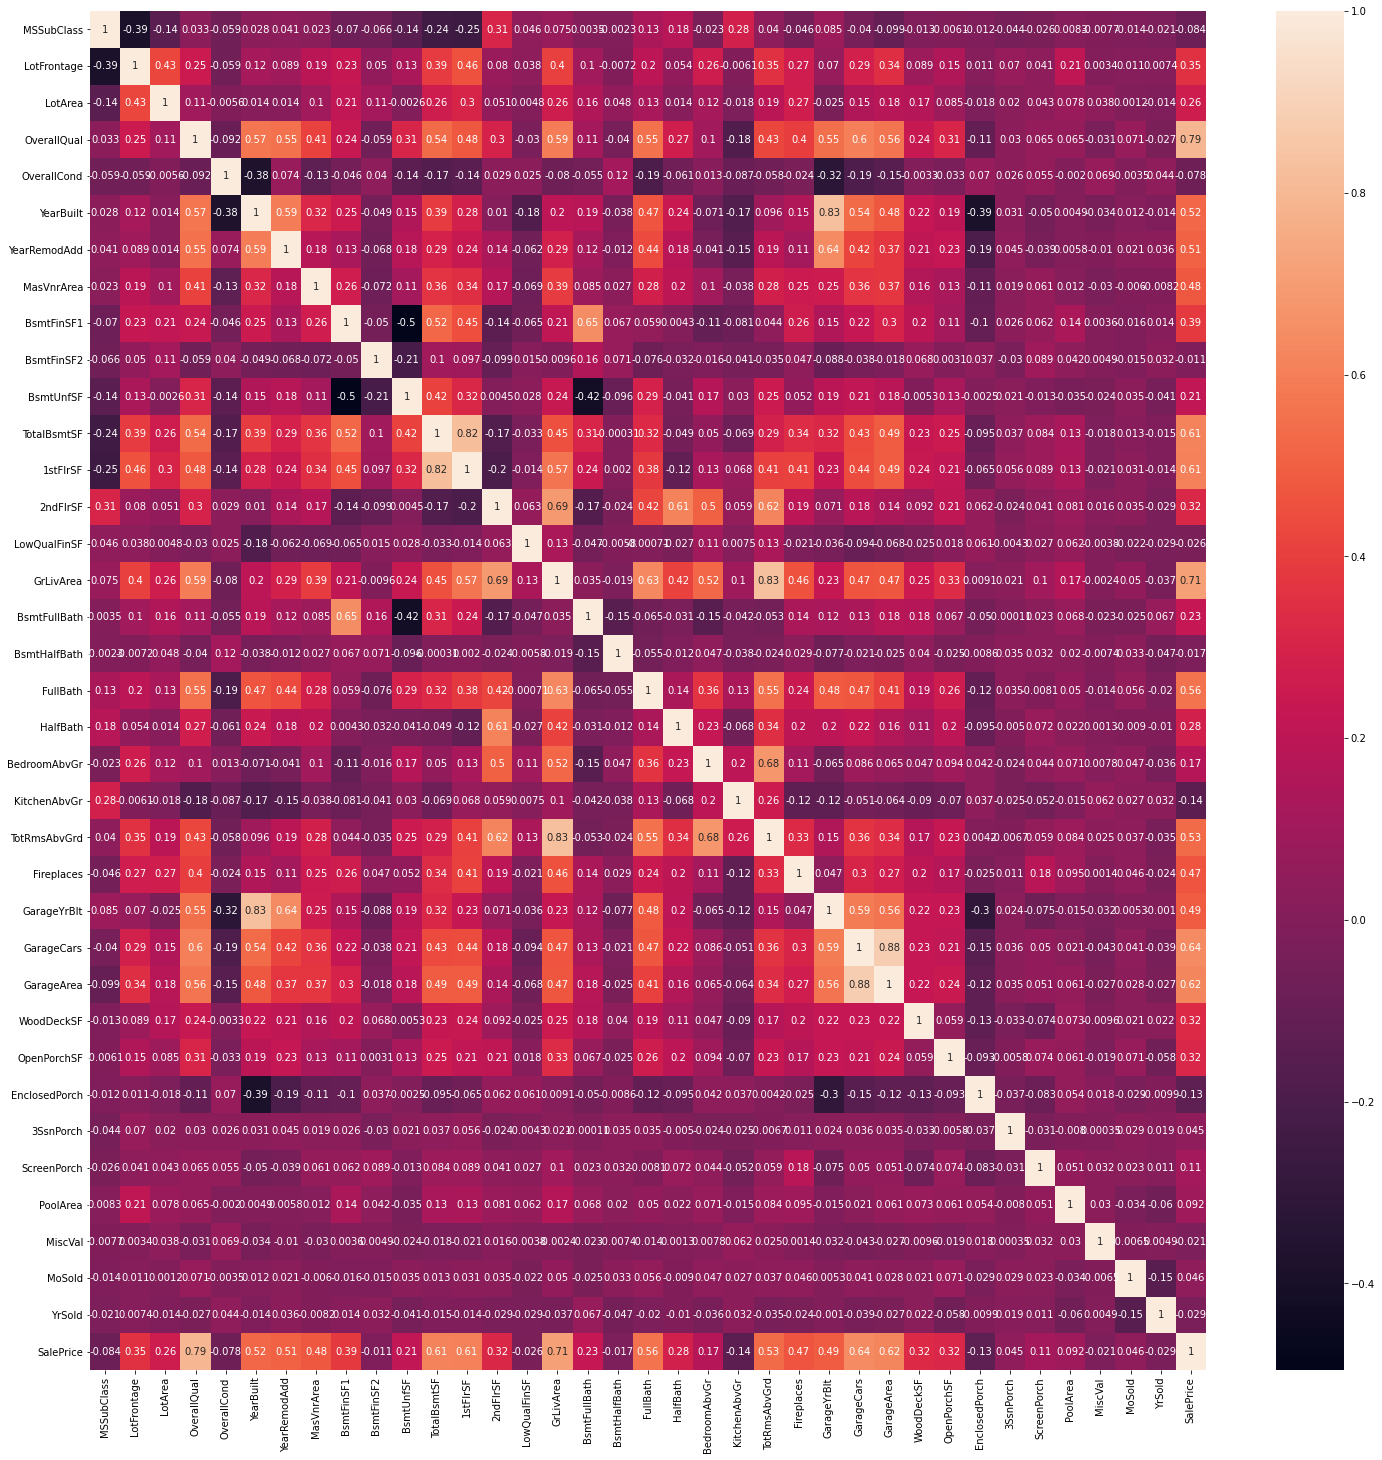

In [8]:
numerical_correlation_matrix = numeric_train_data.drop(['Id'], axis=1).corr()
plt.figure(figsize=(25,25))
sns.heatmap(data=numerical_correlation_matrix, annot=True)

Select just variables with more than 0.2 in absolute correlation with 'SalePrice'

<AxesSubplot:>

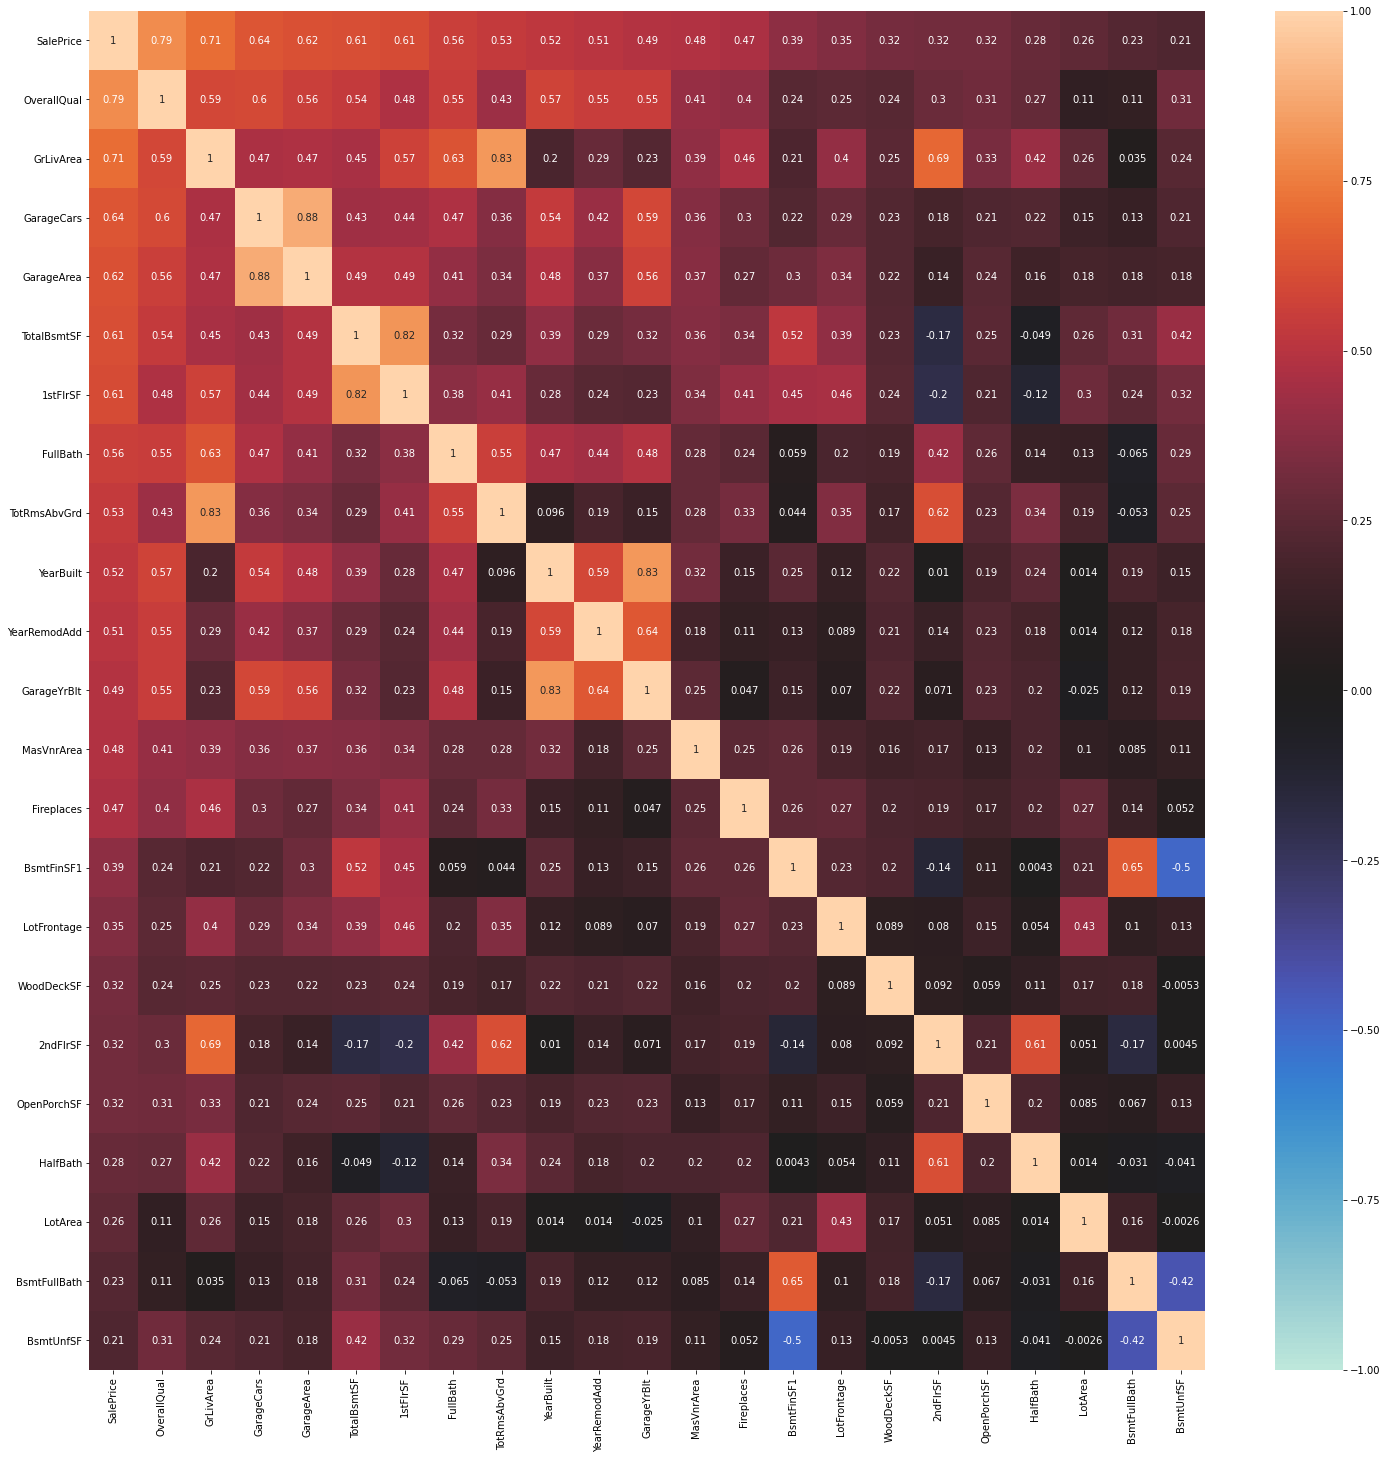

In [9]:
reduced = [column for column in numerical_correlation_matrix.columns if abs(numerical_correlation_matrix['SalePrice'][column])>0.2]
reduced_numerical_correlation_matrix=numerical_correlation_matrix.loc[reduced,reduced]
sorted_numeric_variables = reduced_numerical_correlation_matrix.sort_values(by='SalePrice',ascending=False, axis=1).sort_values(by='SalePrice',ascending=False, axis=0)
plt.figure(figsize=(25,25))
sns.heatmap(data=sorted_numeric_variables, annot=True, center=0, vmin=-1, vmax=1)

Select variables with best correlation with 'SalePrice' and less correlation between them

In [10]:
numeric_selected = [
    'OverallQual',
    'GrLivArea',
    'GarageCars',
    'TotalBsmtSF',
    'YearBuilt',
    'YearRemodAdd',
    'MasVnrArea',
    'Fireplaces',
    'WoodDeckSF',
    'LotArea',
    'BsmtFullBath',
]

In [11]:
selected_numeric_train_data = numeric_train_data[numeric_selected]
selected_numeric_train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   OverallQual   1460 non-null   int64  
 1   GrLivArea     1460 non-null   int64  
 2   GarageCars    1460 non-null   int64  
 3   TotalBsmtSF   1460 non-null   int64  
 4   YearBuilt     1460 non-null   int64  
 5   YearRemodAdd  1460 non-null   int64  
 6   MasVnrArea    1452 non-null   float64
 7   Fireplaces    1460 non-null   int64  
 8   WoodDeckSF    1460 non-null   int64  
 9   LotArea       1460 non-null   int64  
 10  BsmtFullBath  1460 non-null   int64  
dtypes: float64(1), int64(10)
memory usage: 125.6 KB


In [12]:
selected_numeric_test_data = numeric_test_data[numeric_selected]
selected_numeric_test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   OverallQual   1459 non-null   int64  
 1   GrLivArea     1459 non-null   int64  
 2   GarageCars    1458 non-null   float64
 3   TotalBsmtSF   1458 non-null   float64
 4   YearBuilt     1459 non-null   int64  
 5   YearRemodAdd  1459 non-null   int64  
 6   MasVnrArea    1444 non-null   float64
 7   Fireplaces    1459 non-null   int64  
 8   WoodDeckSF    1459 non-null   int64  
 9   LotArea       1459 non-null   int64  
 10  BsmtFullBath  1457 non-null   float64
dtypes: float64(4), int64(7)
memory usage: 125.5 KB


Fill the NaN

In [13]:
# Fill in the lines below: imputation
imputer = SimpleImputer() # Your code here
imputed_numeric_train_data = pd.DataFrame(imputer.fit_transform(selected_numeric_train_data))
imputed_numeric_test_data = pd.DataFrame(imputer.transform(selected_numeric_test_data))

imputed_numeric_train_data.columns = selected_numeric_train_data.columns
imputed_numeric_test_data.columns = selected_numeric_test_data.columns

print(imputed_numeric_train_data.info())
print(imputed_numeric_test_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   OverallQual   1460 non-null   float64
 1   GrLivArea     1460 non-null   float64
 2   GarageCars    1460 non-null   float64
 3   TotalBsmtSF   1460 non-null   float64
 4   YearBuilt     1460 non-null   float64
 5   YearRemodAdd  1460 non-null   float64
 6   MasVnrArea    1460 non-null   float64
 7   Fireplaces    1460 non-null   float64
 8   WoodDeckSF    1460 non-null   float64
 9   LotArea       1460 non-null   float64
 10  BsmtFullBath  1460 non-null   float64
dtypes: float64(11)
memory usage: 125.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   OverallQual   1459 non-null   float64
 1   GrLivArea     1459 non-null   float64
 2   Ga

# Selecting Categoric Variables

Explore each categoric variable with a boxplot

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


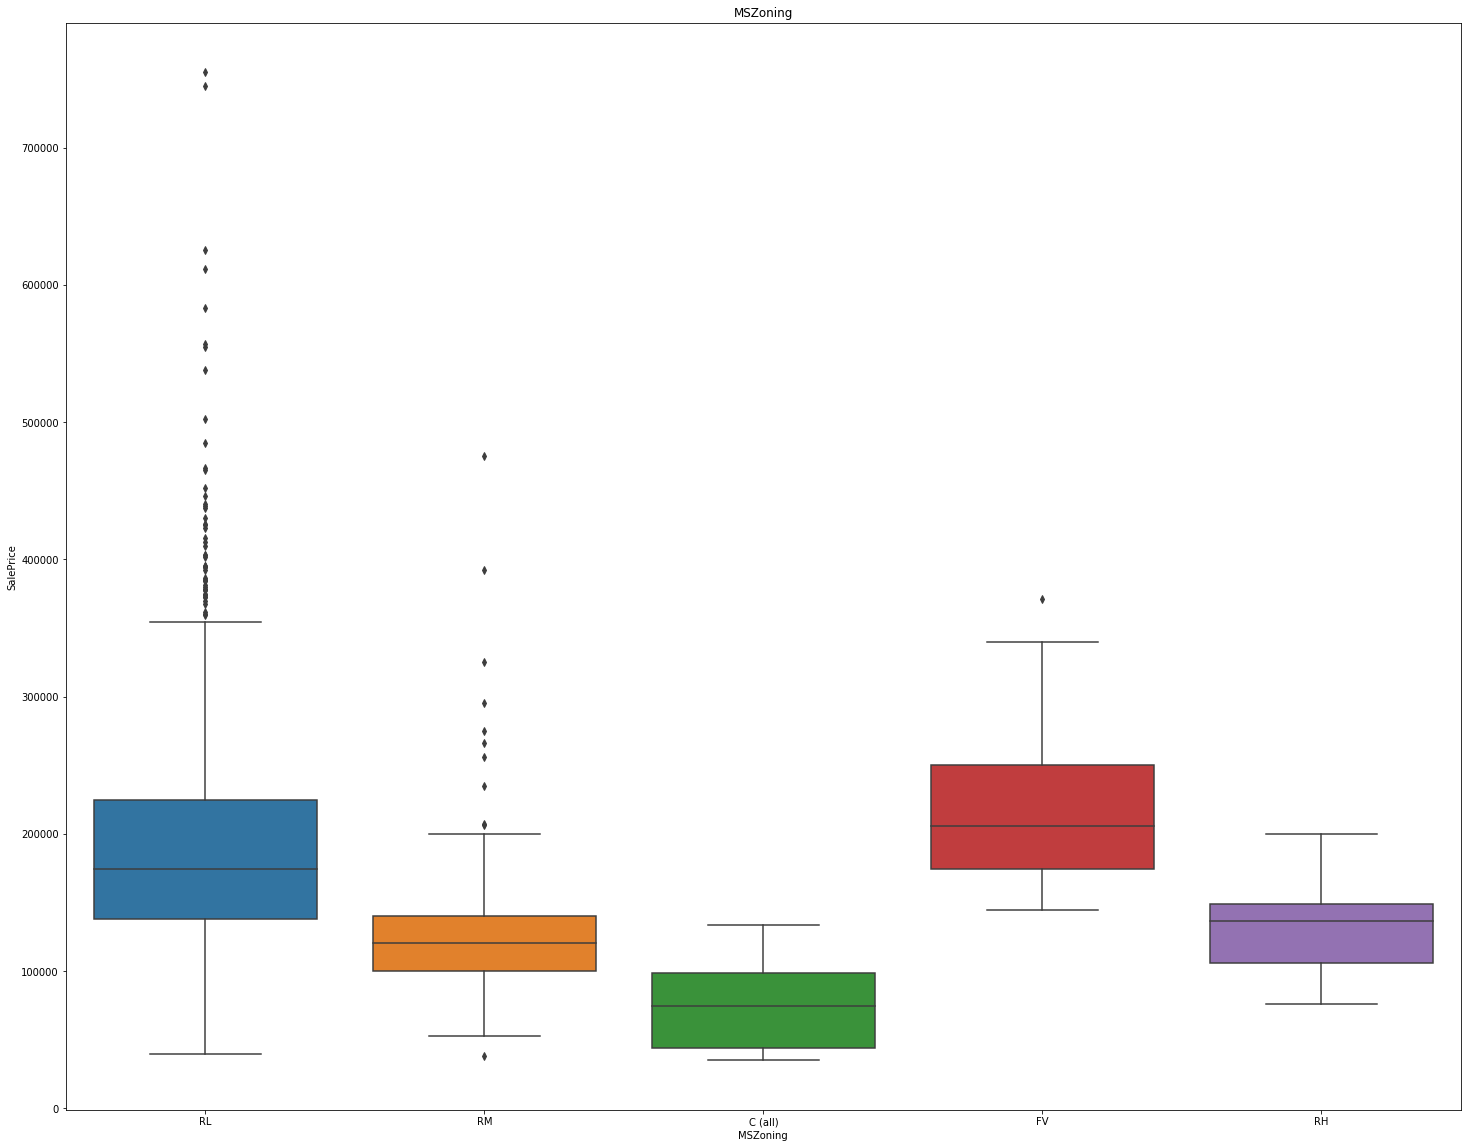

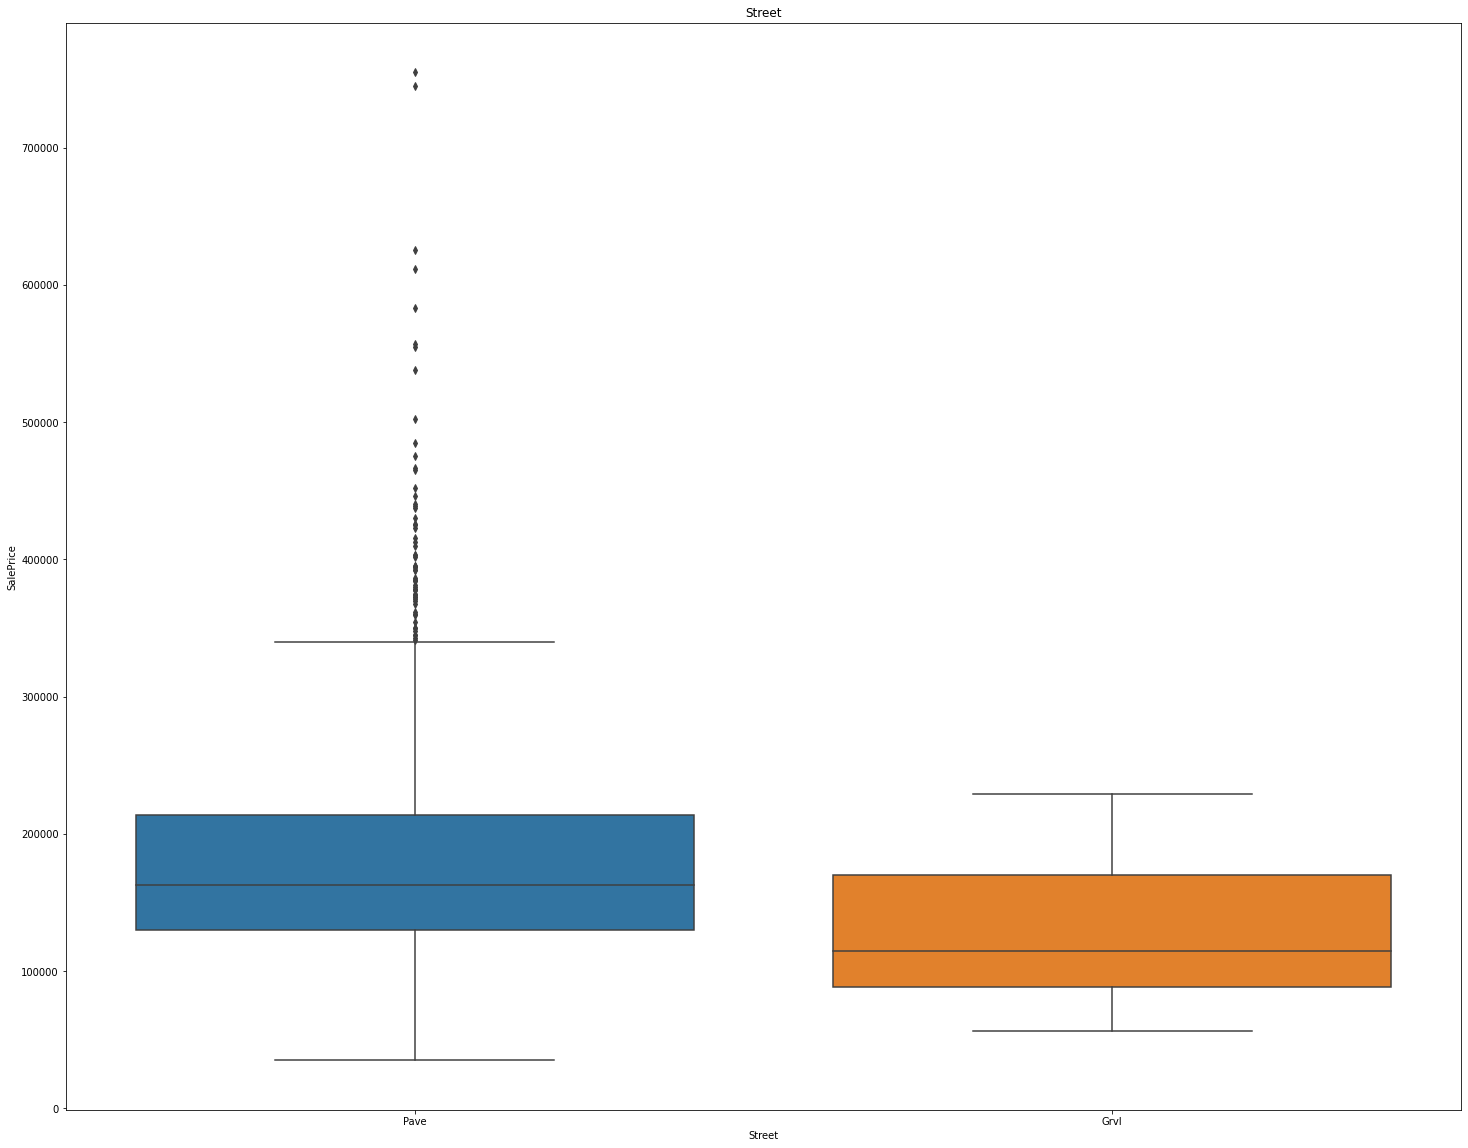

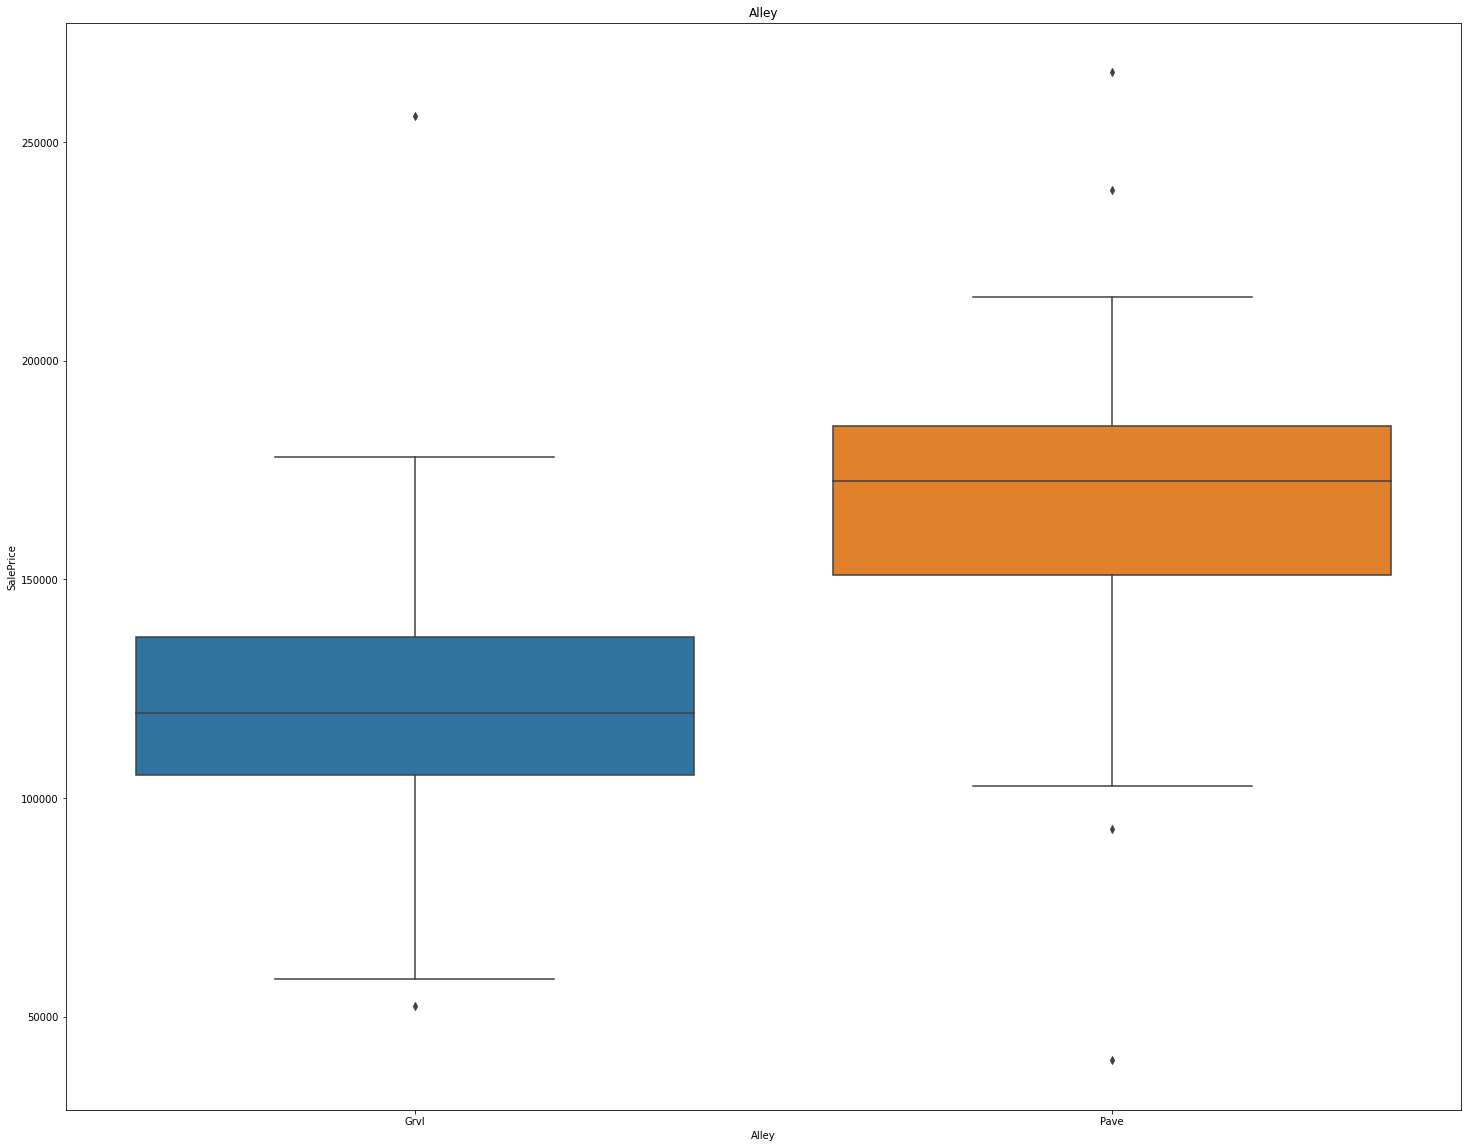

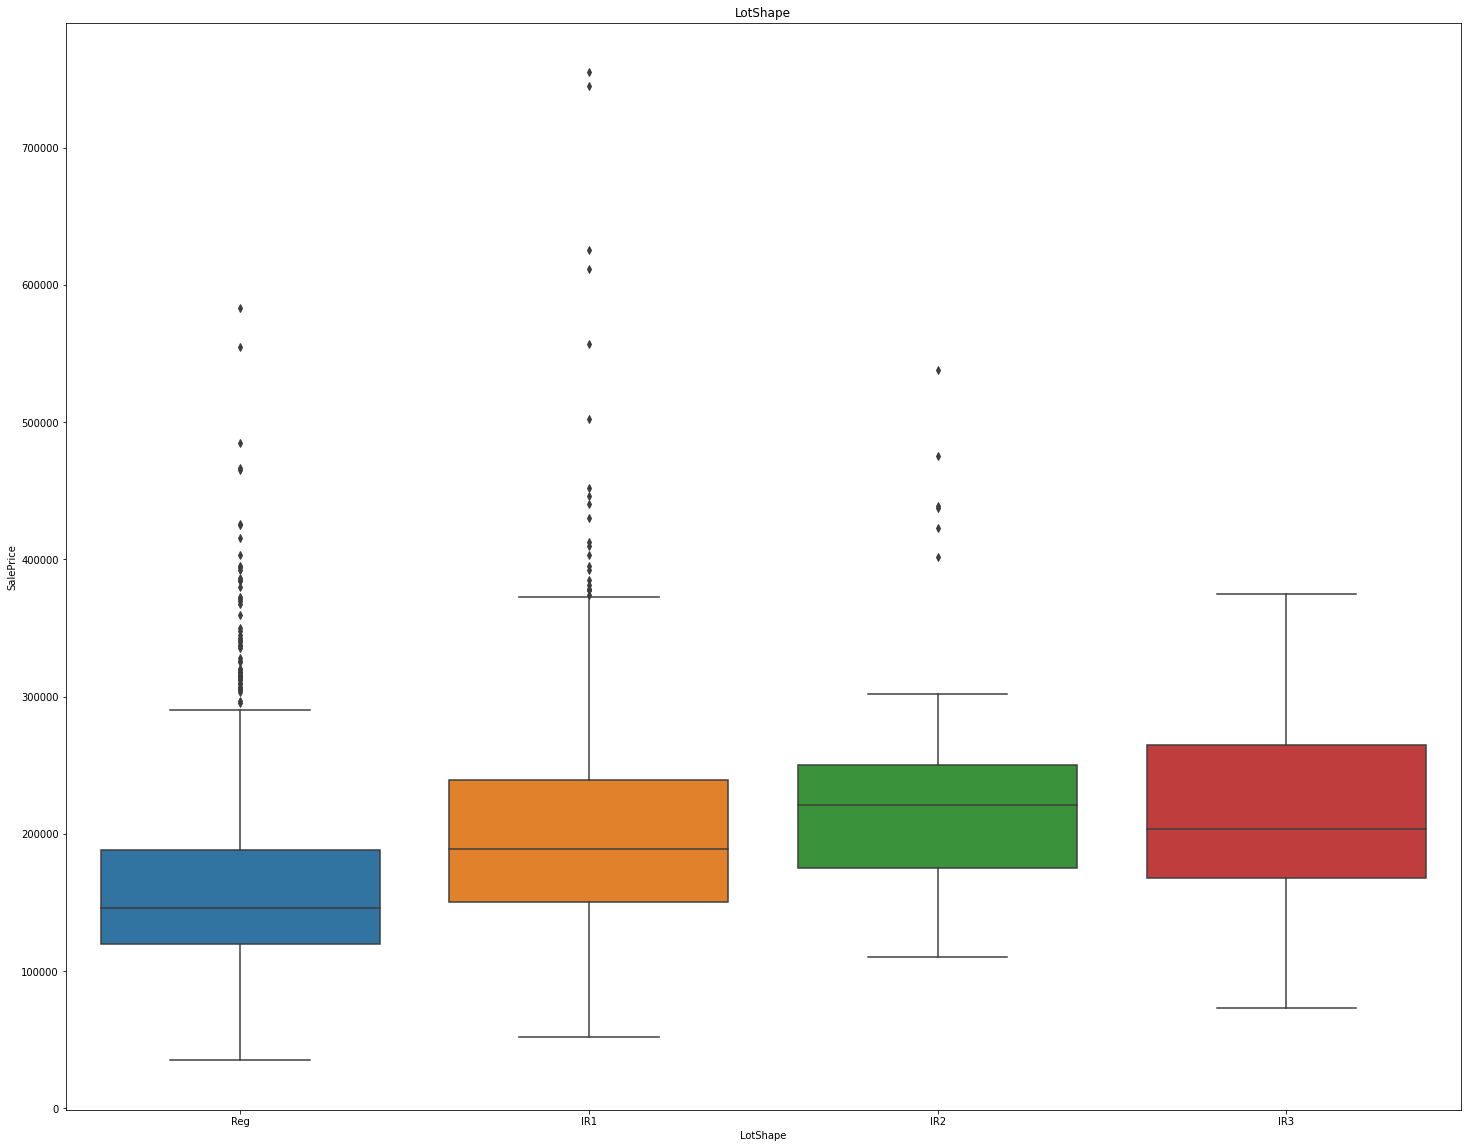

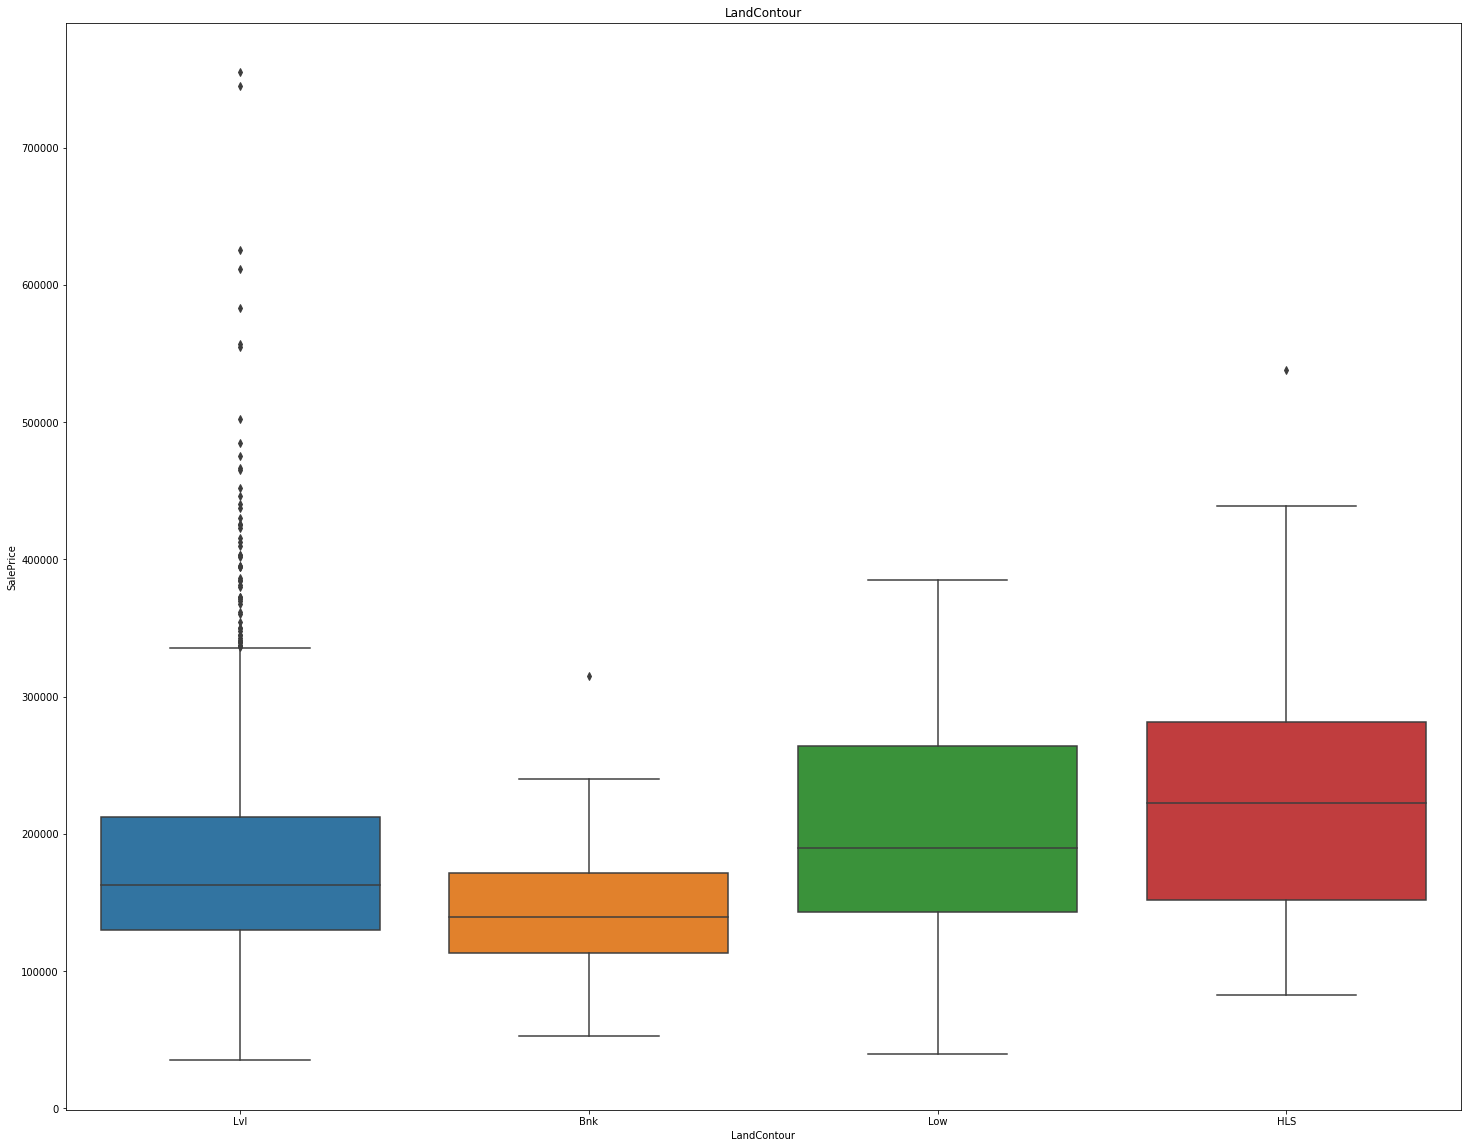

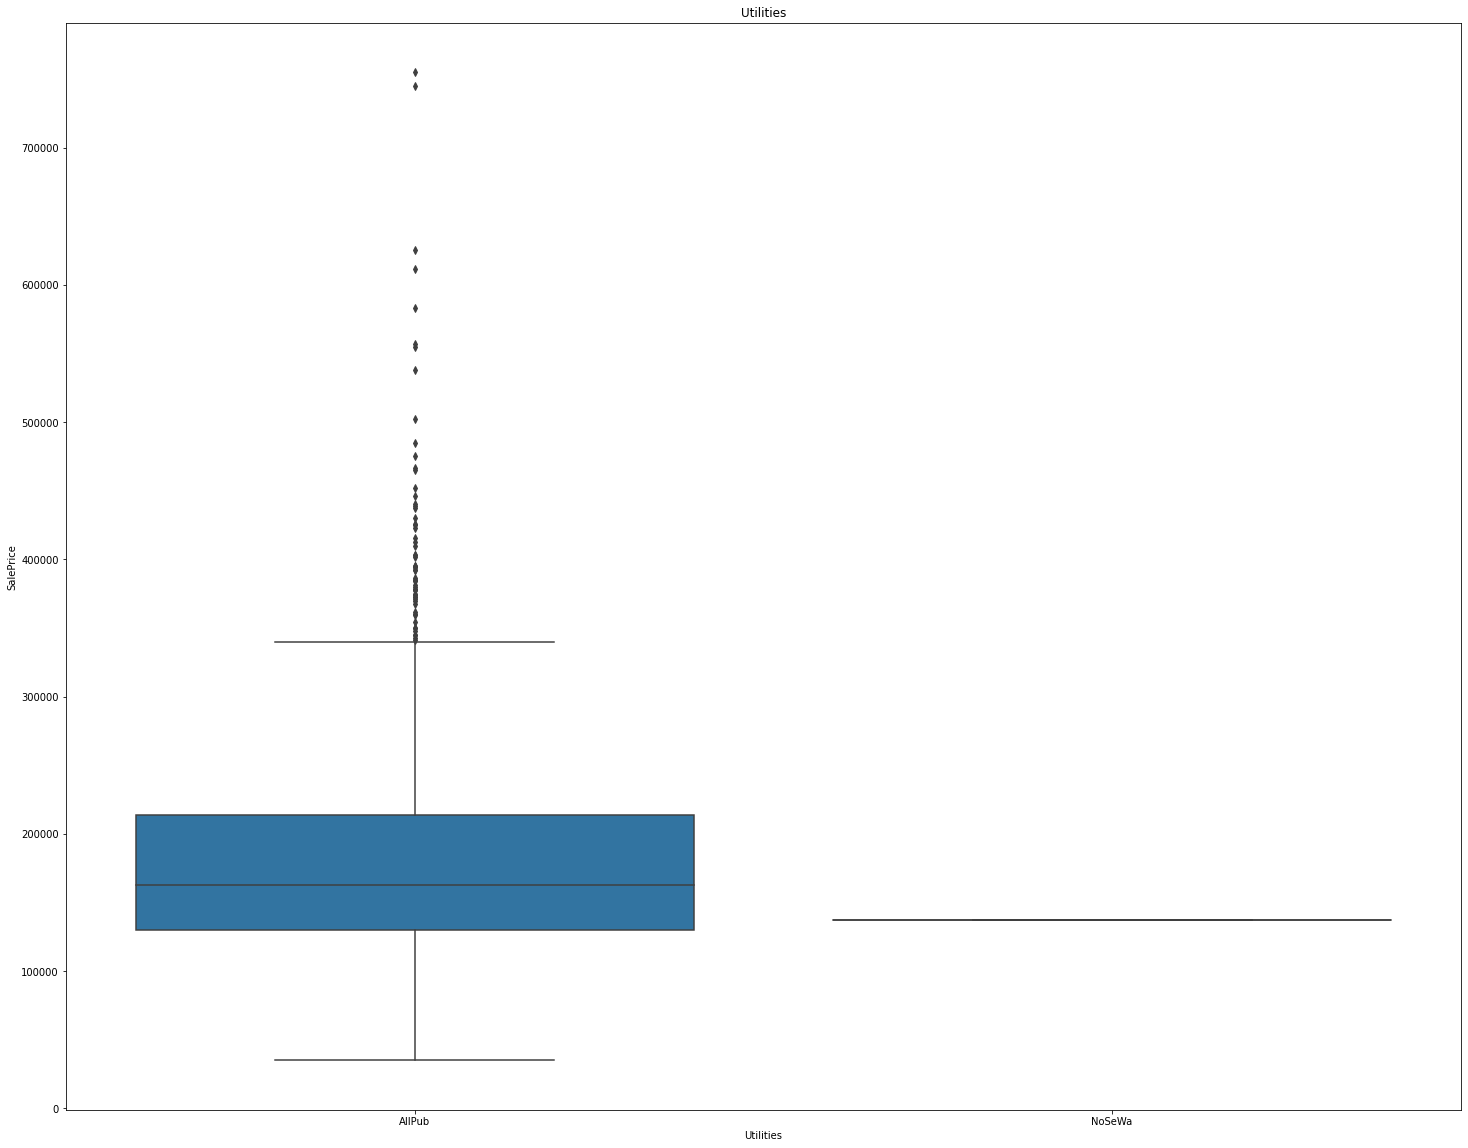

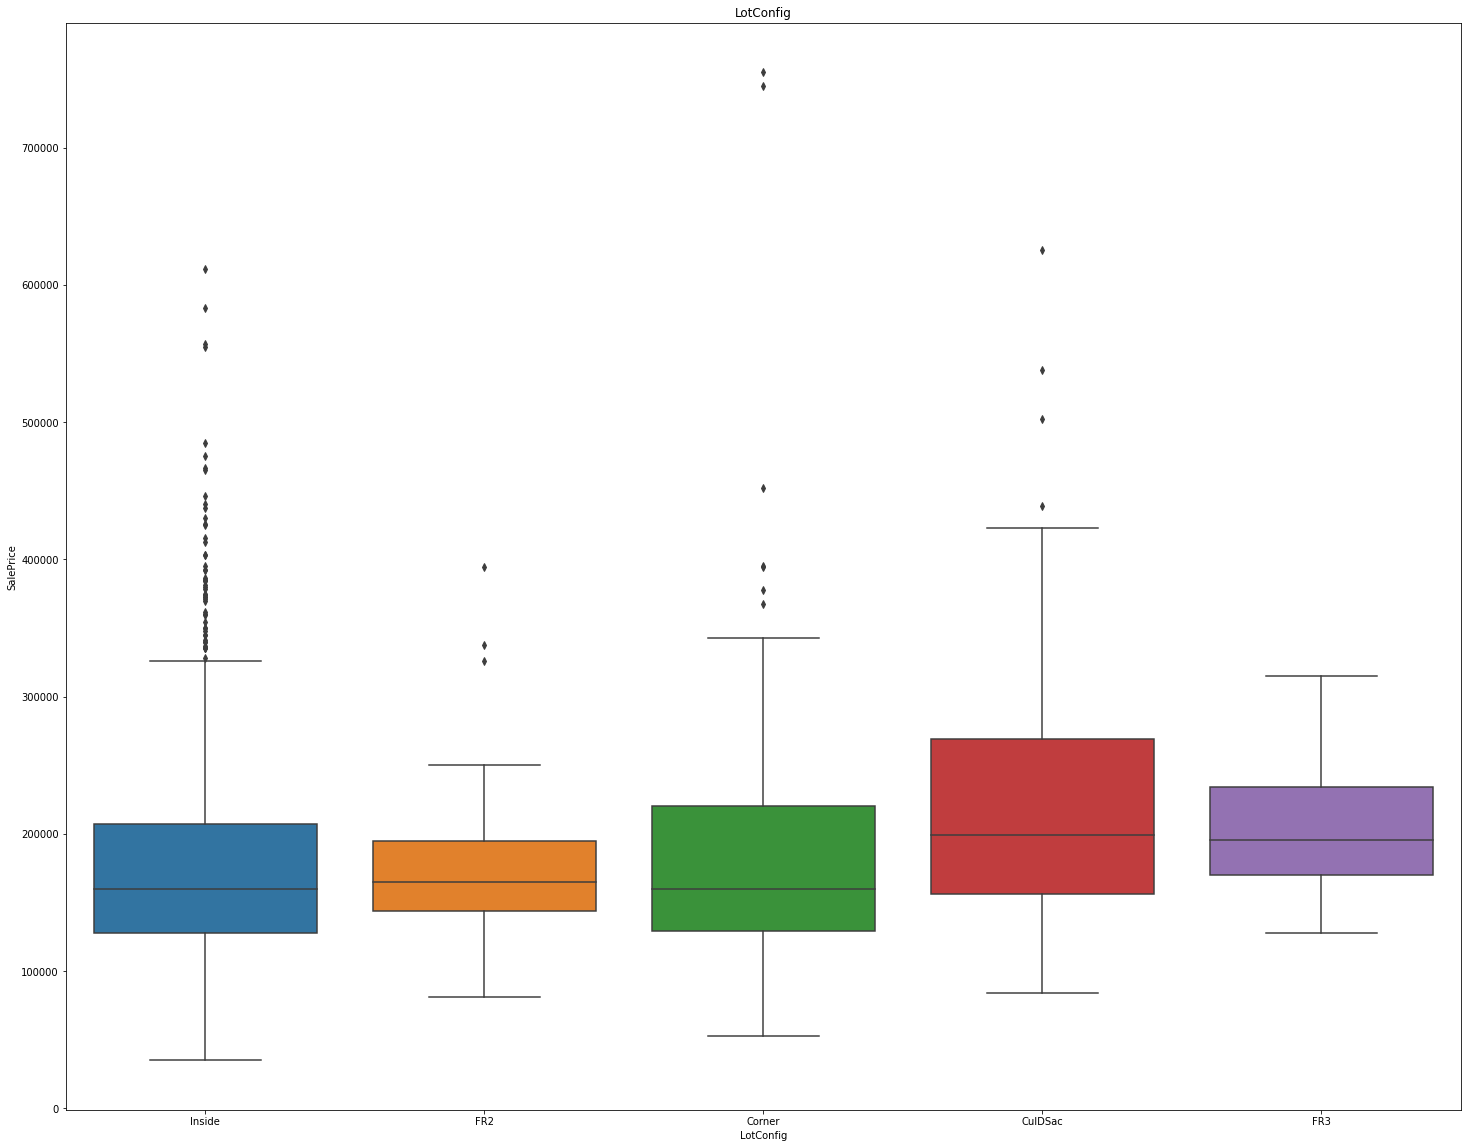

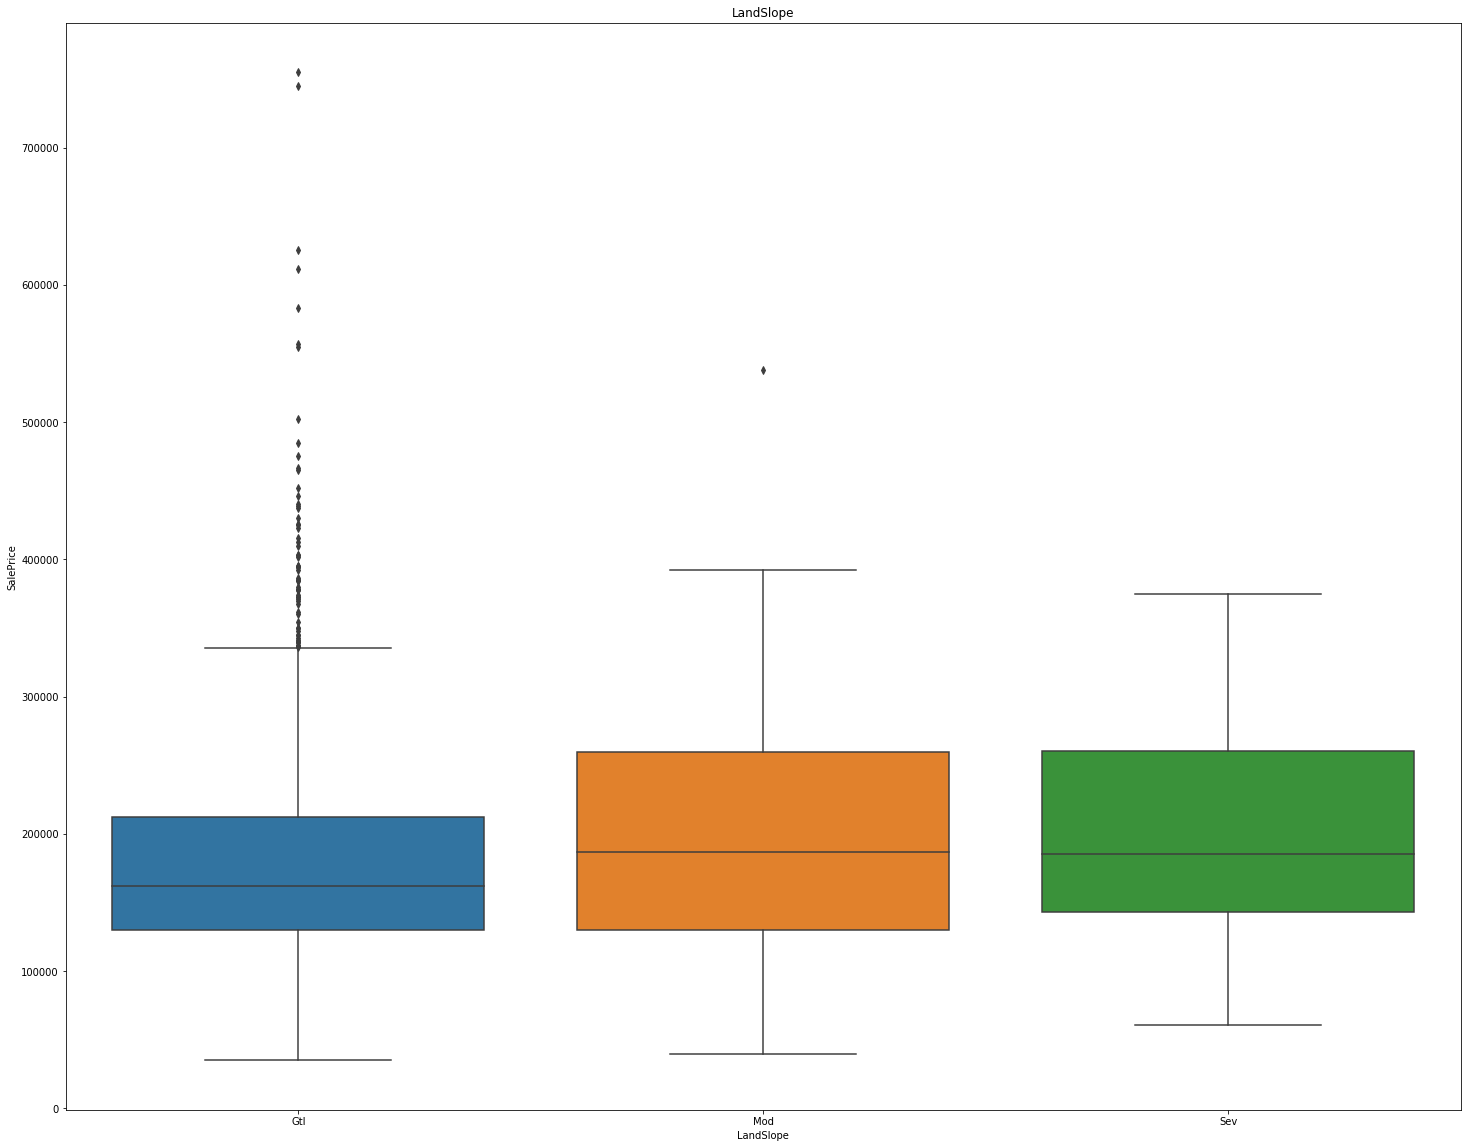

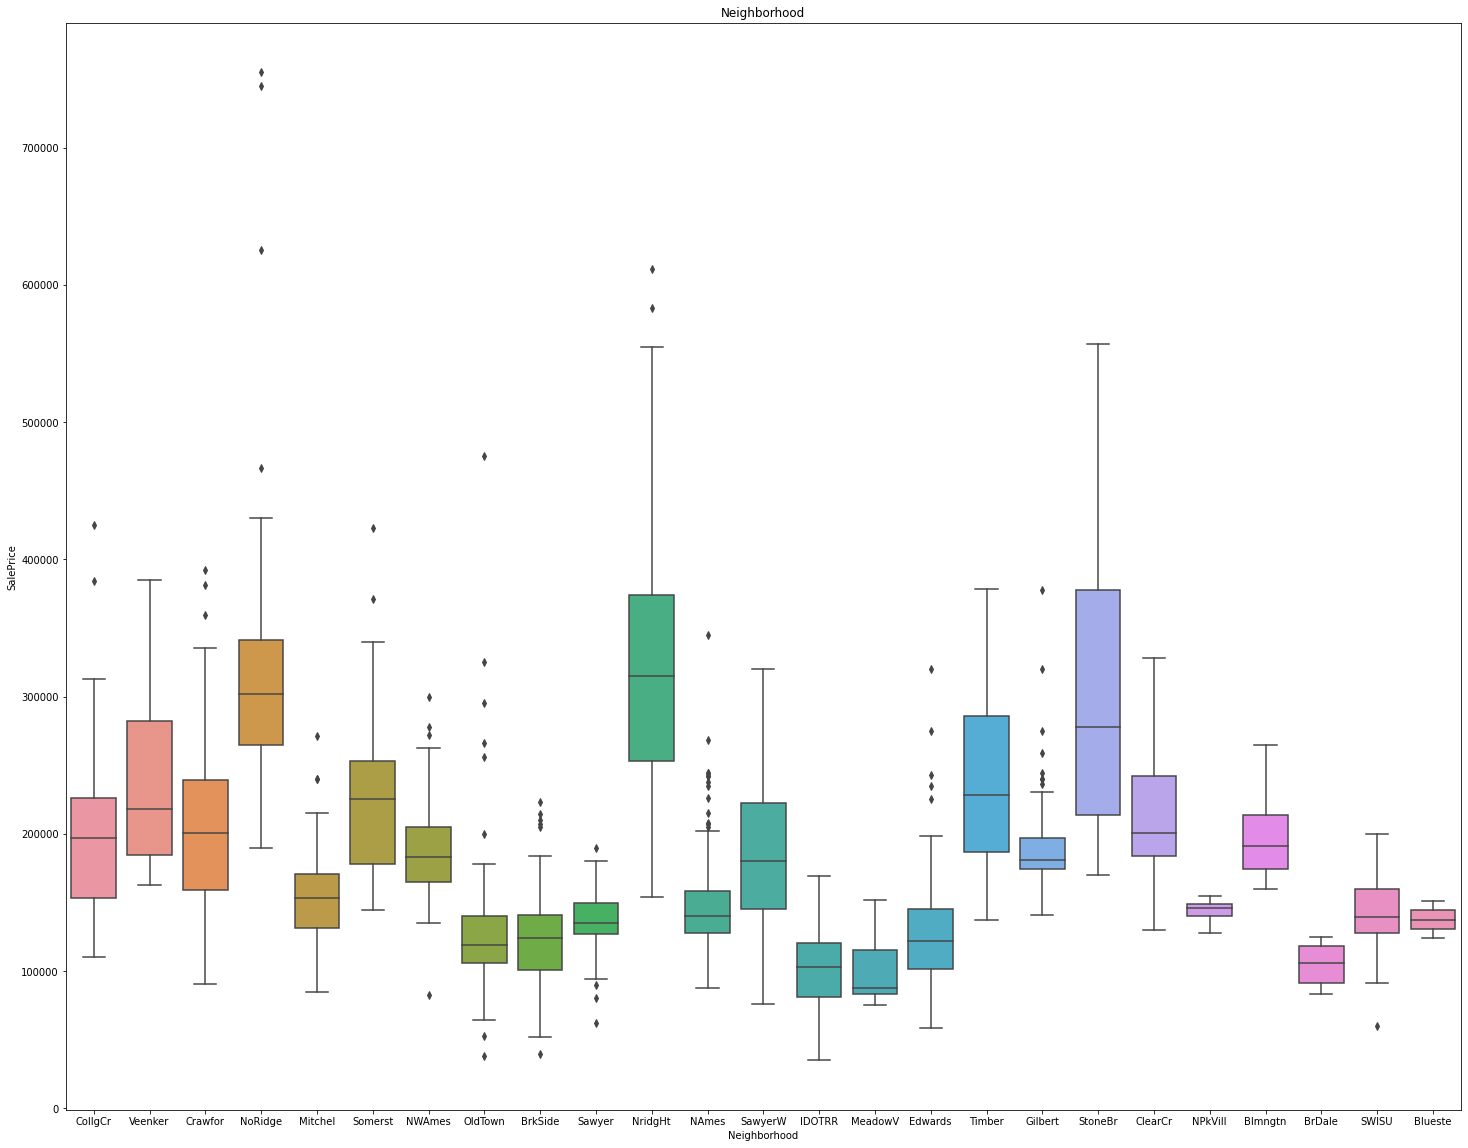

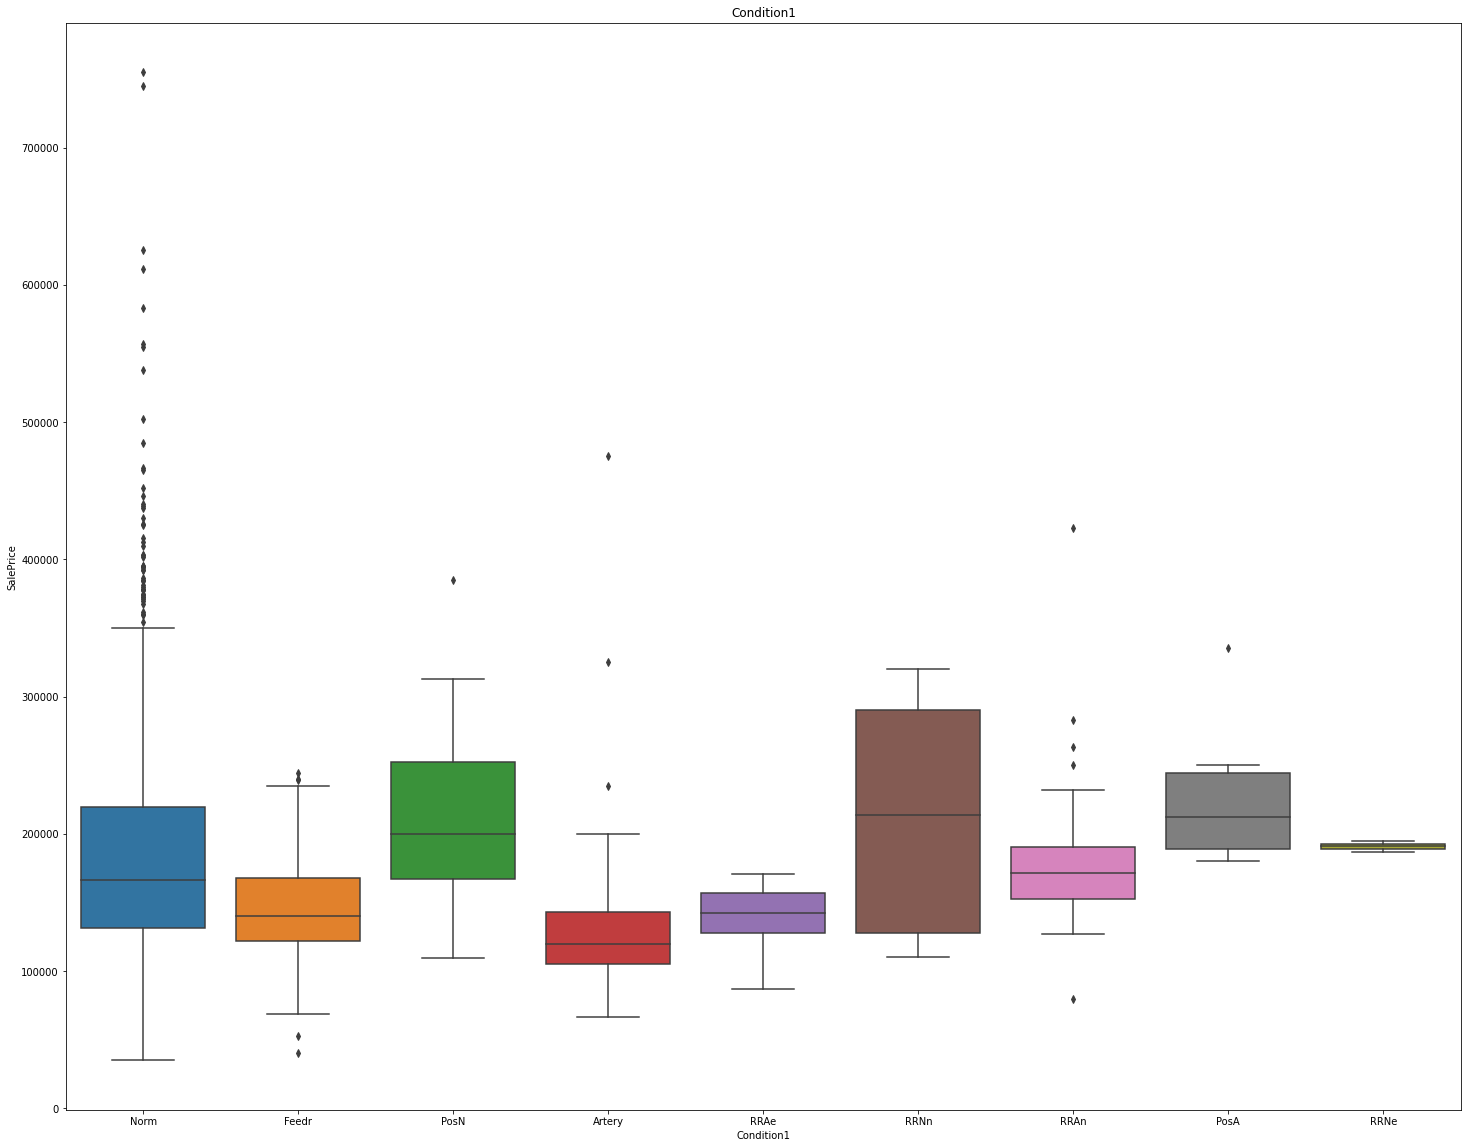

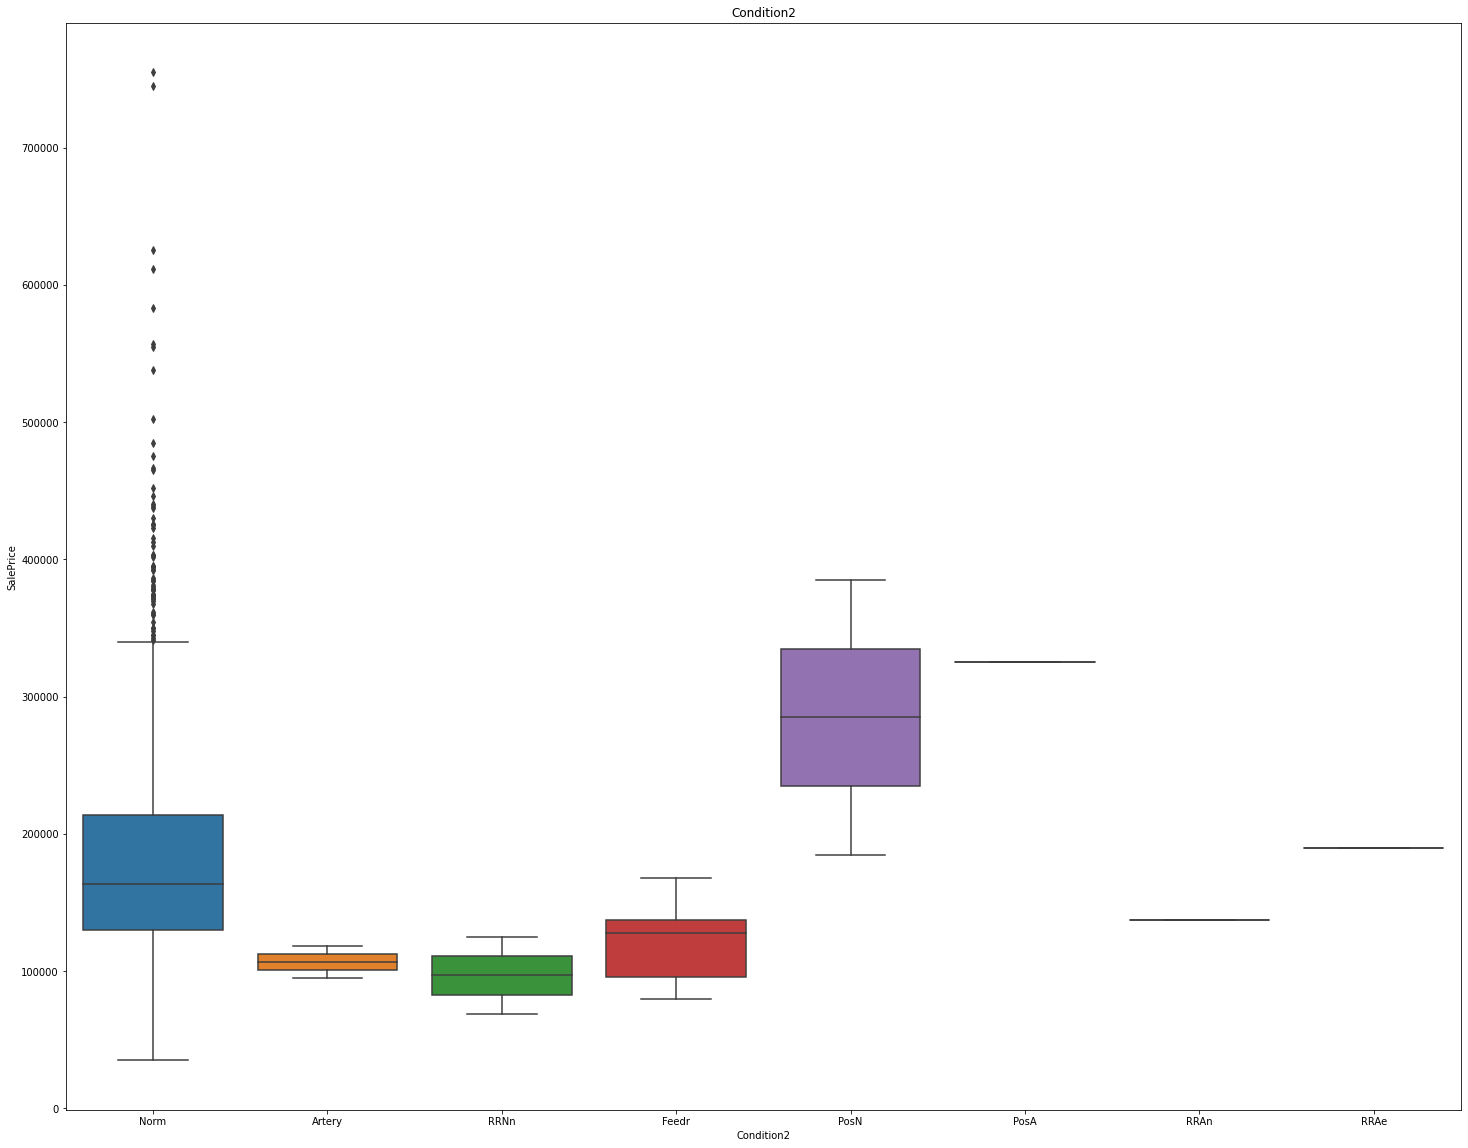

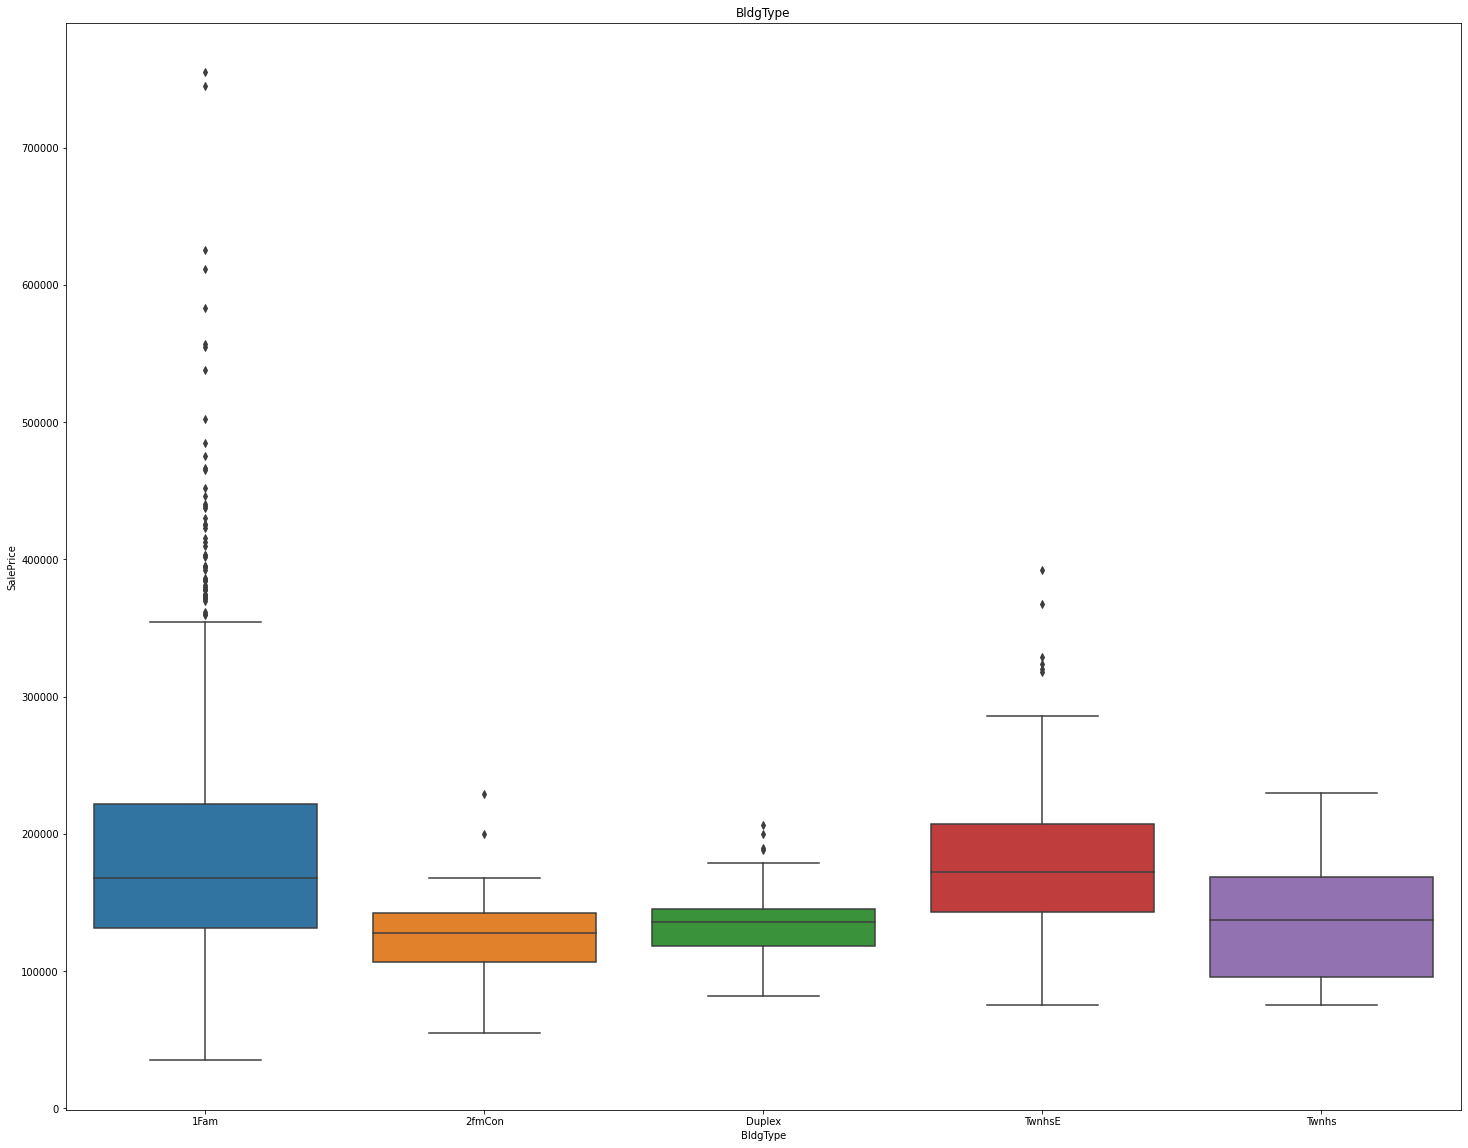

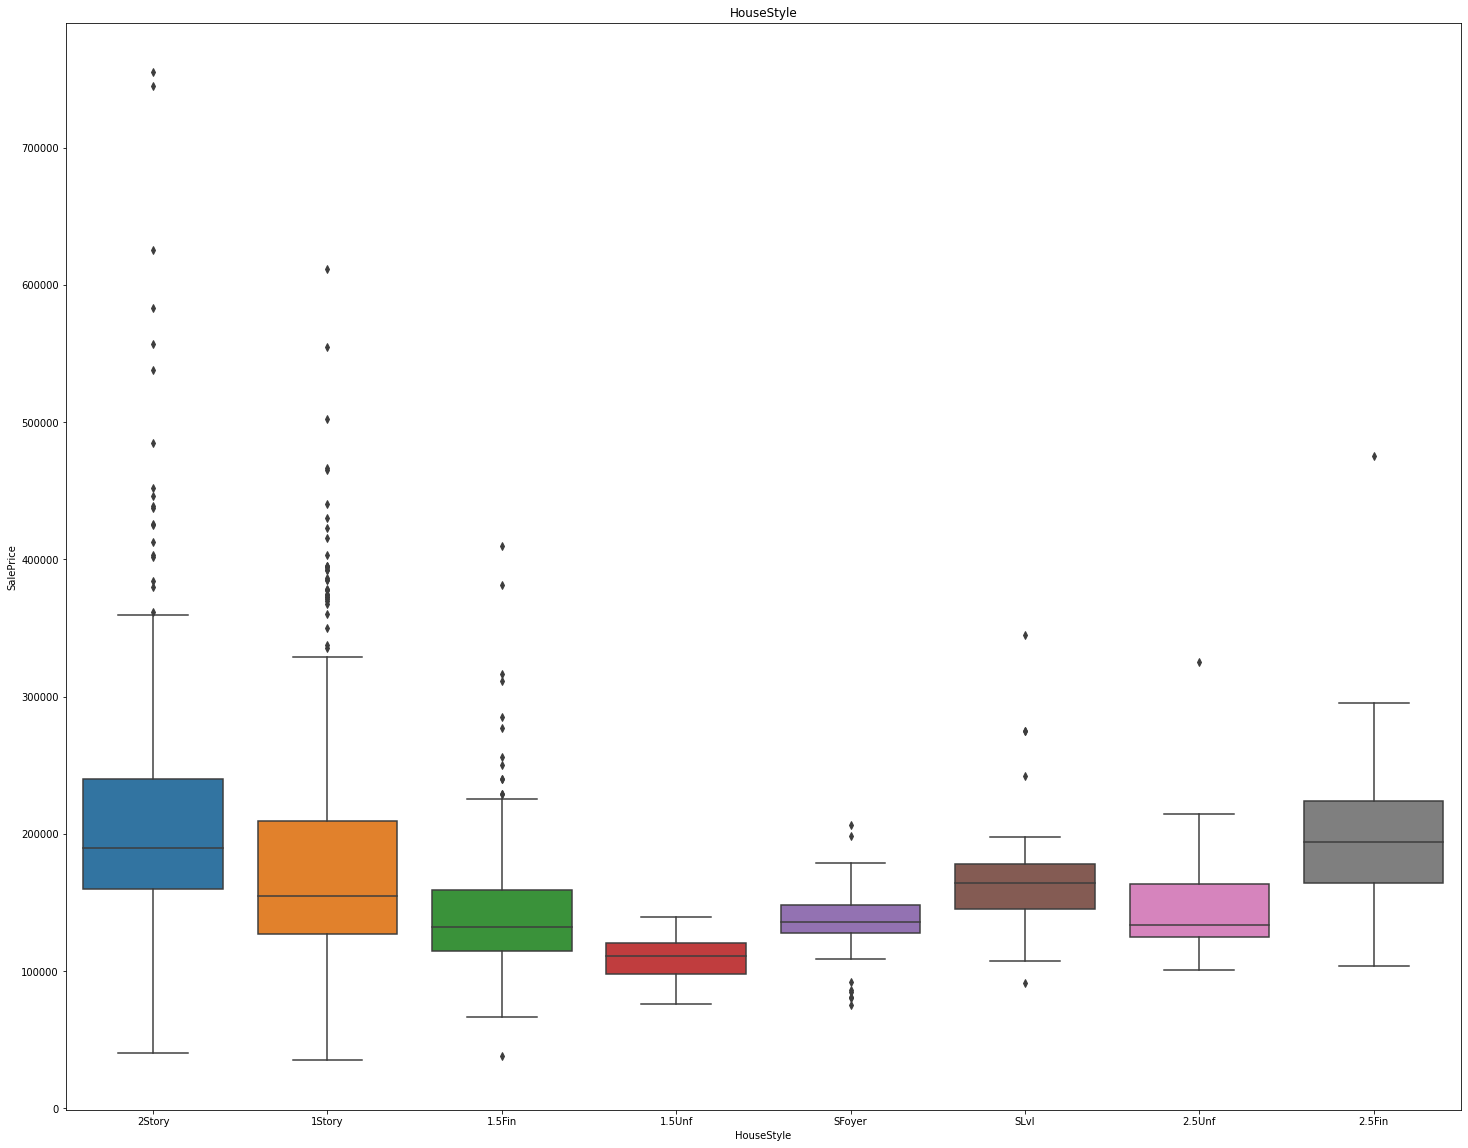

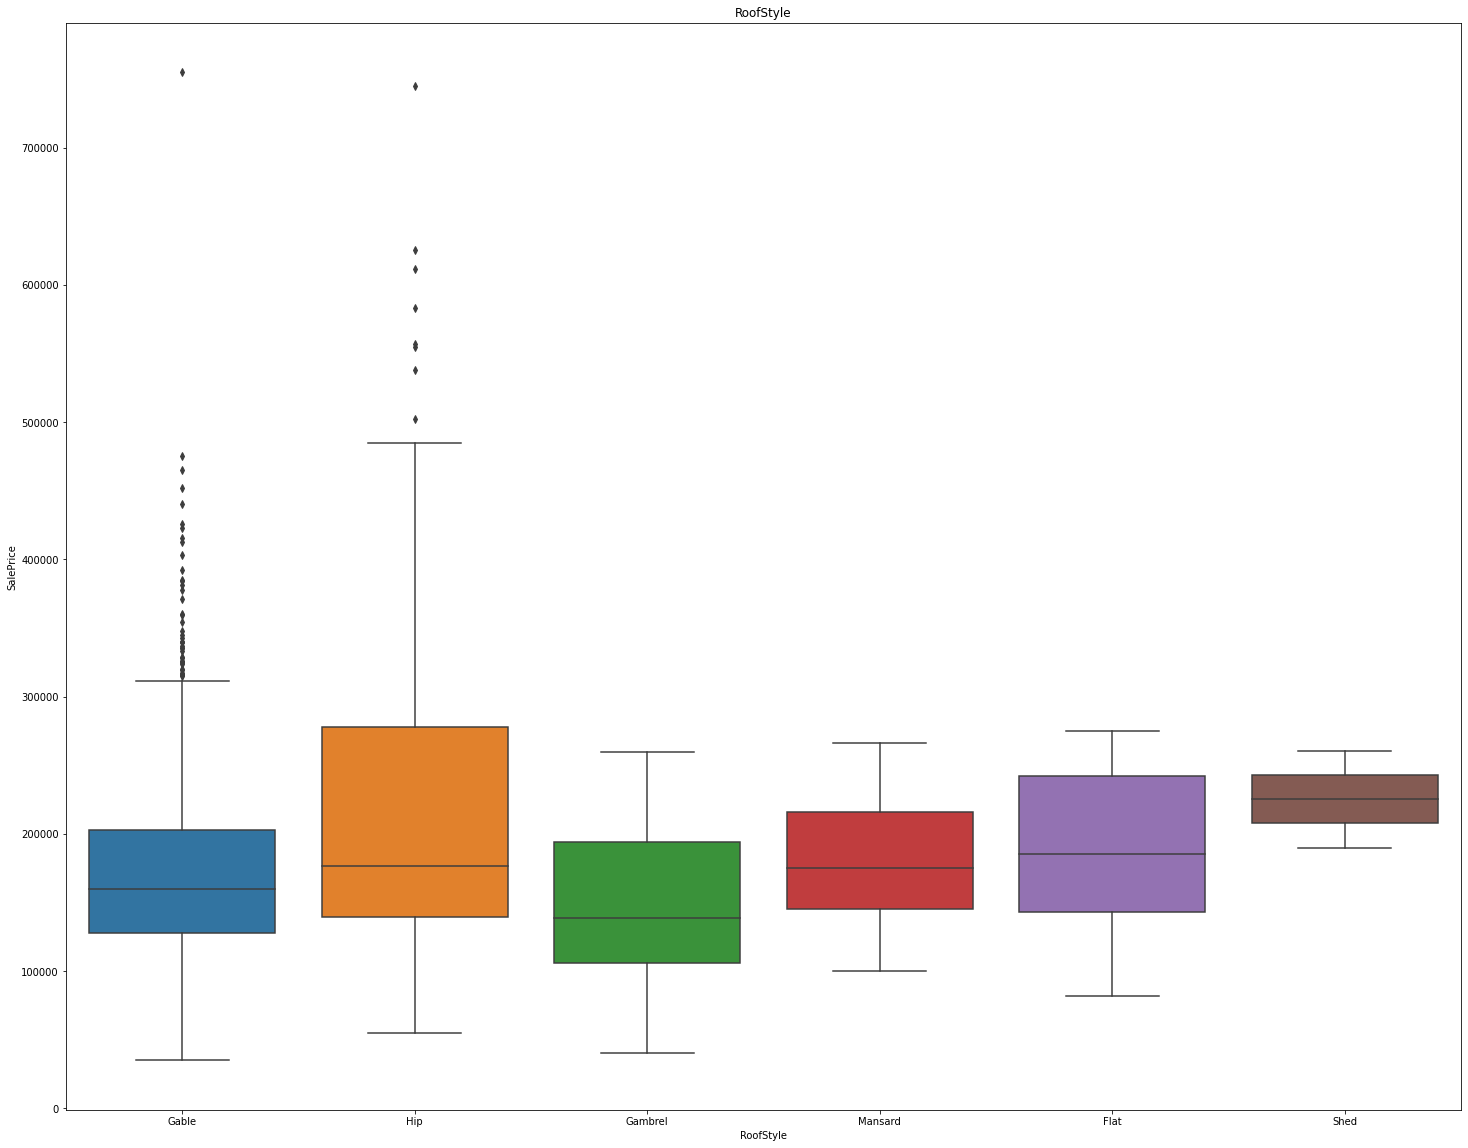

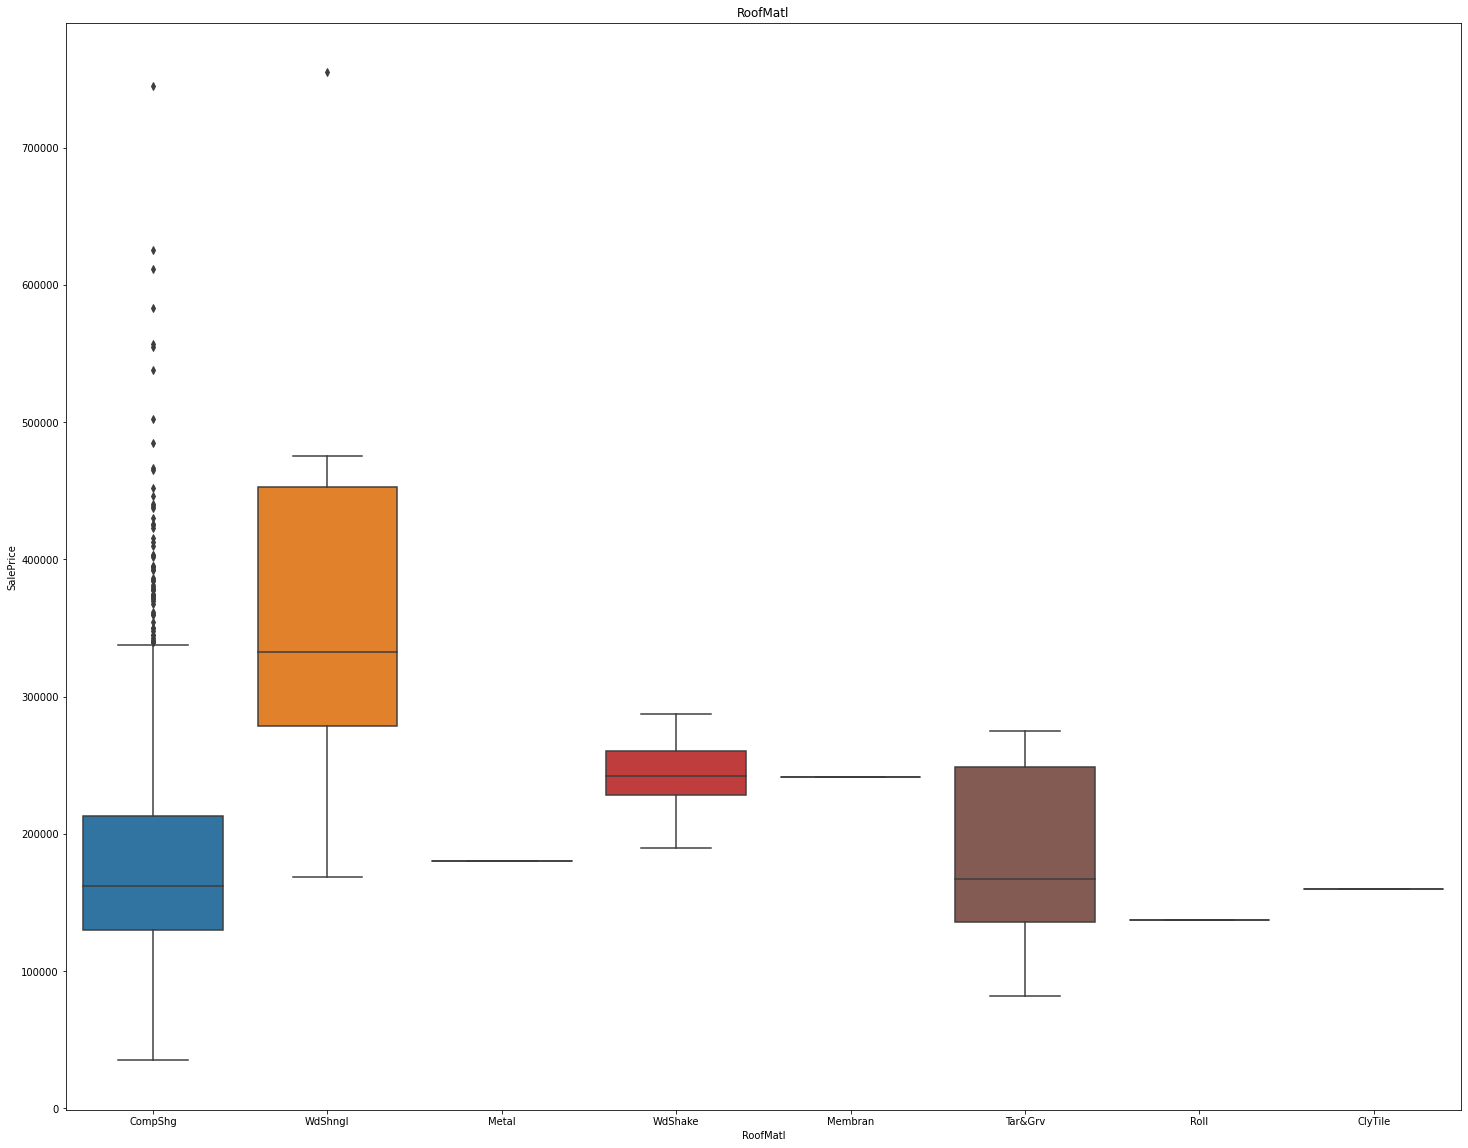

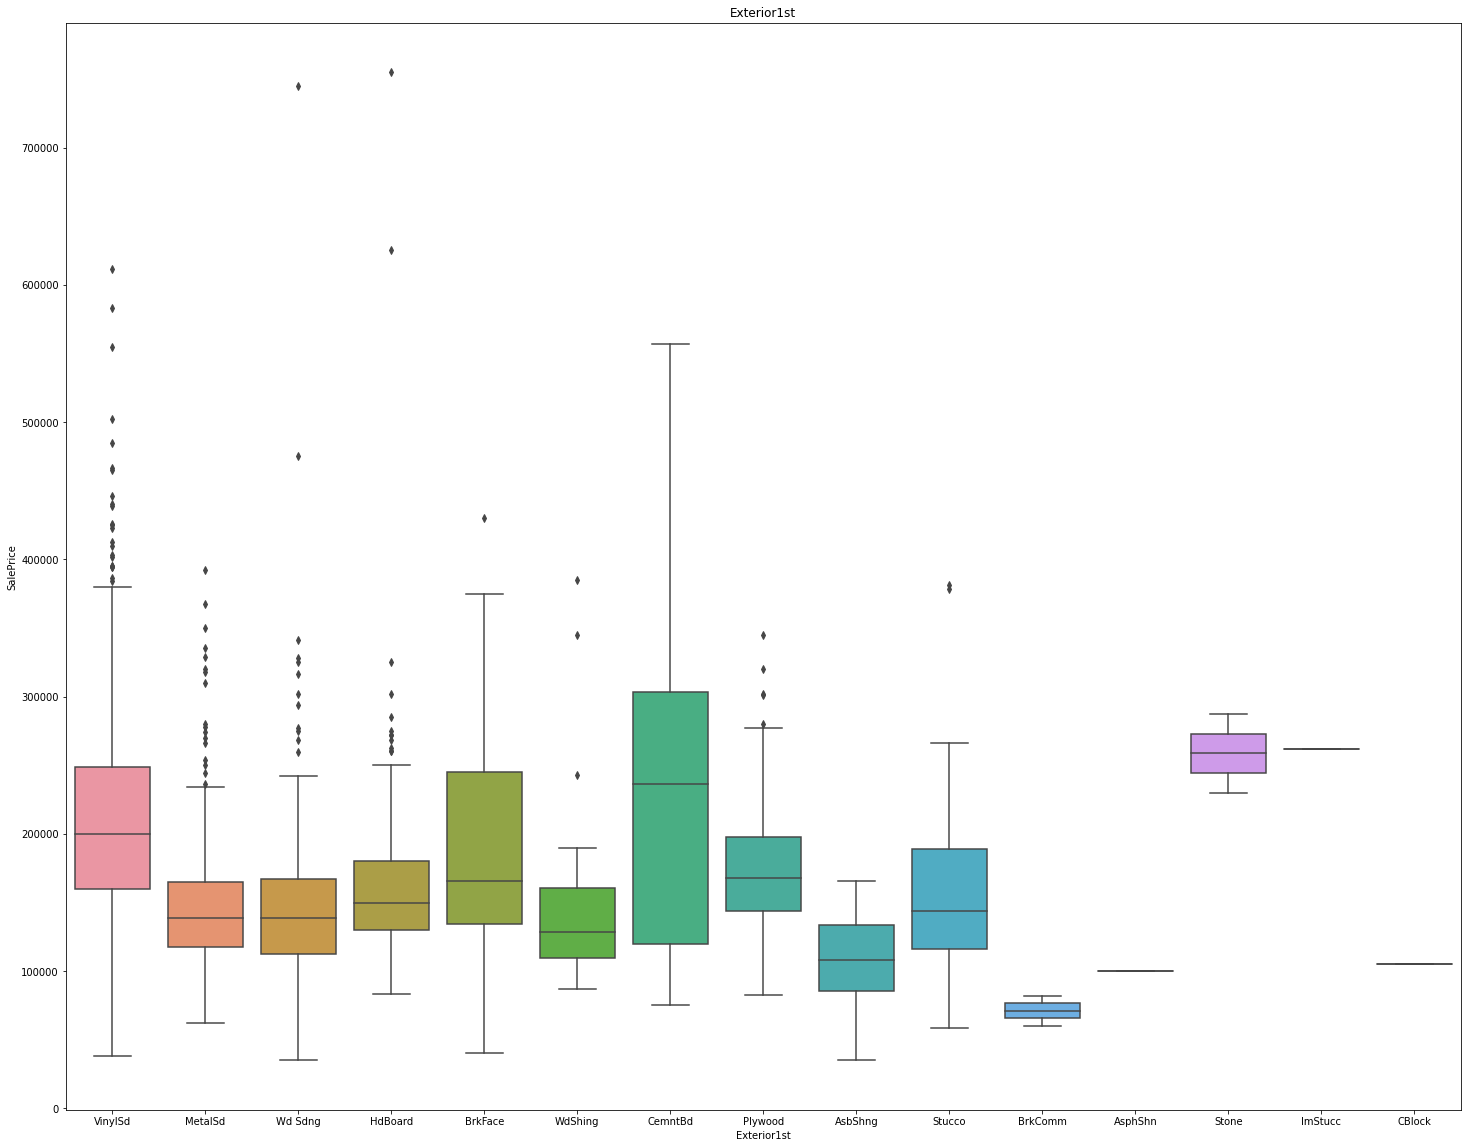

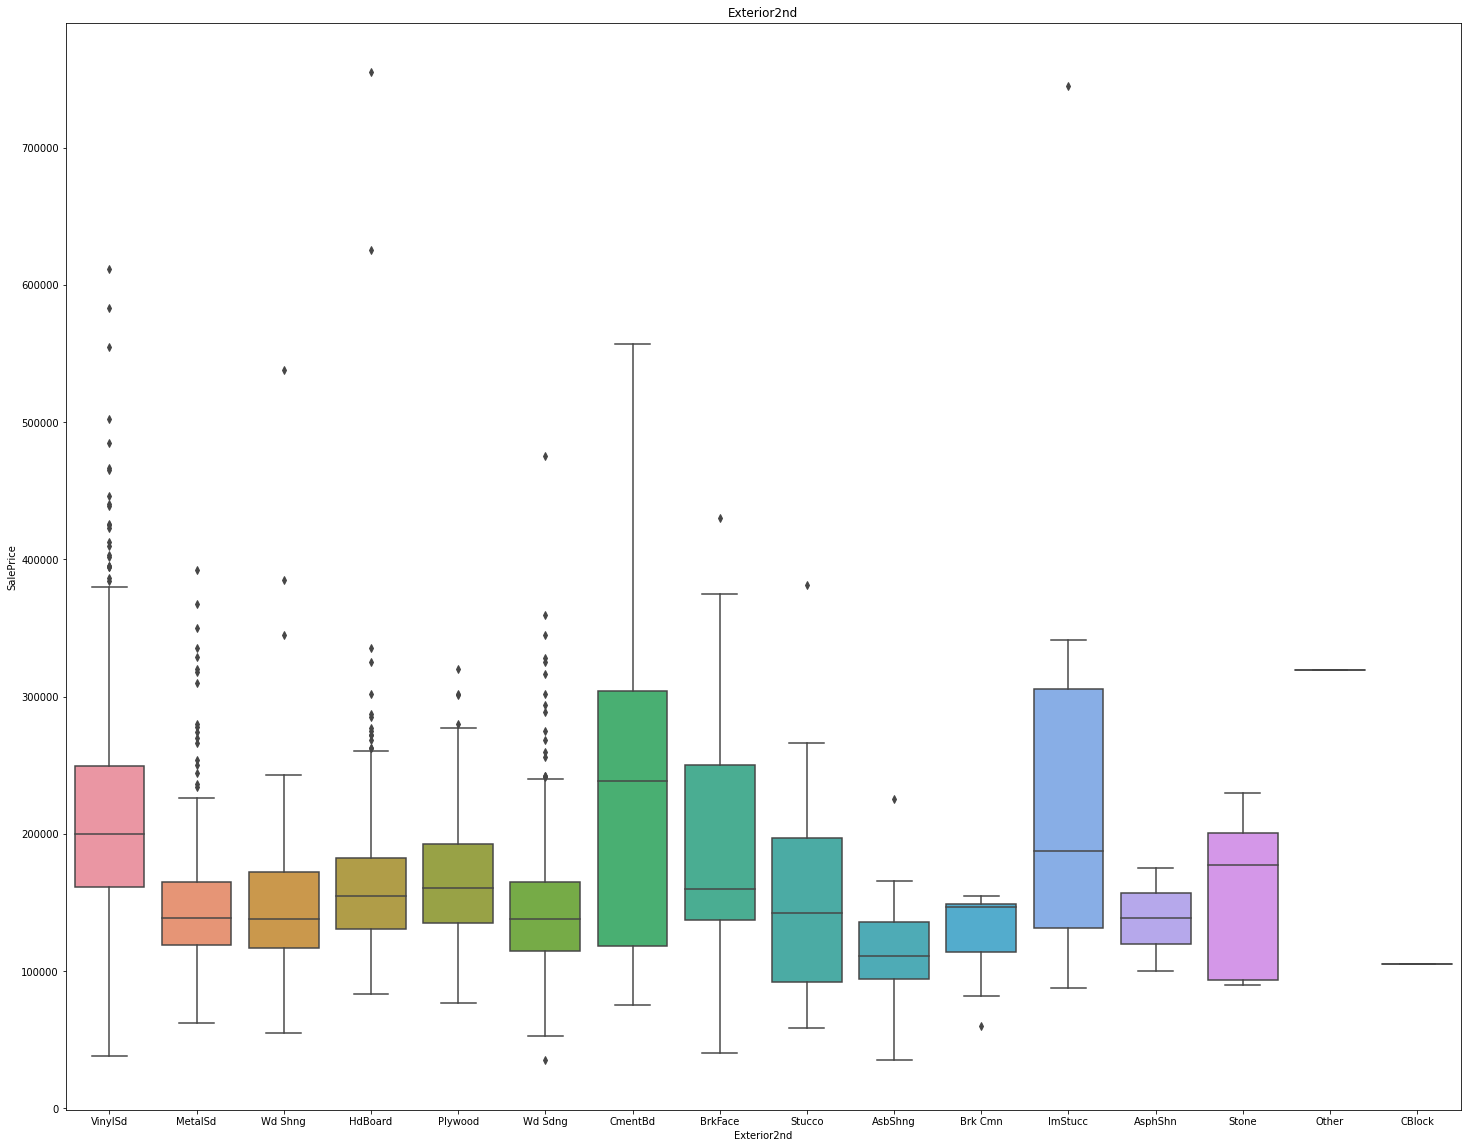

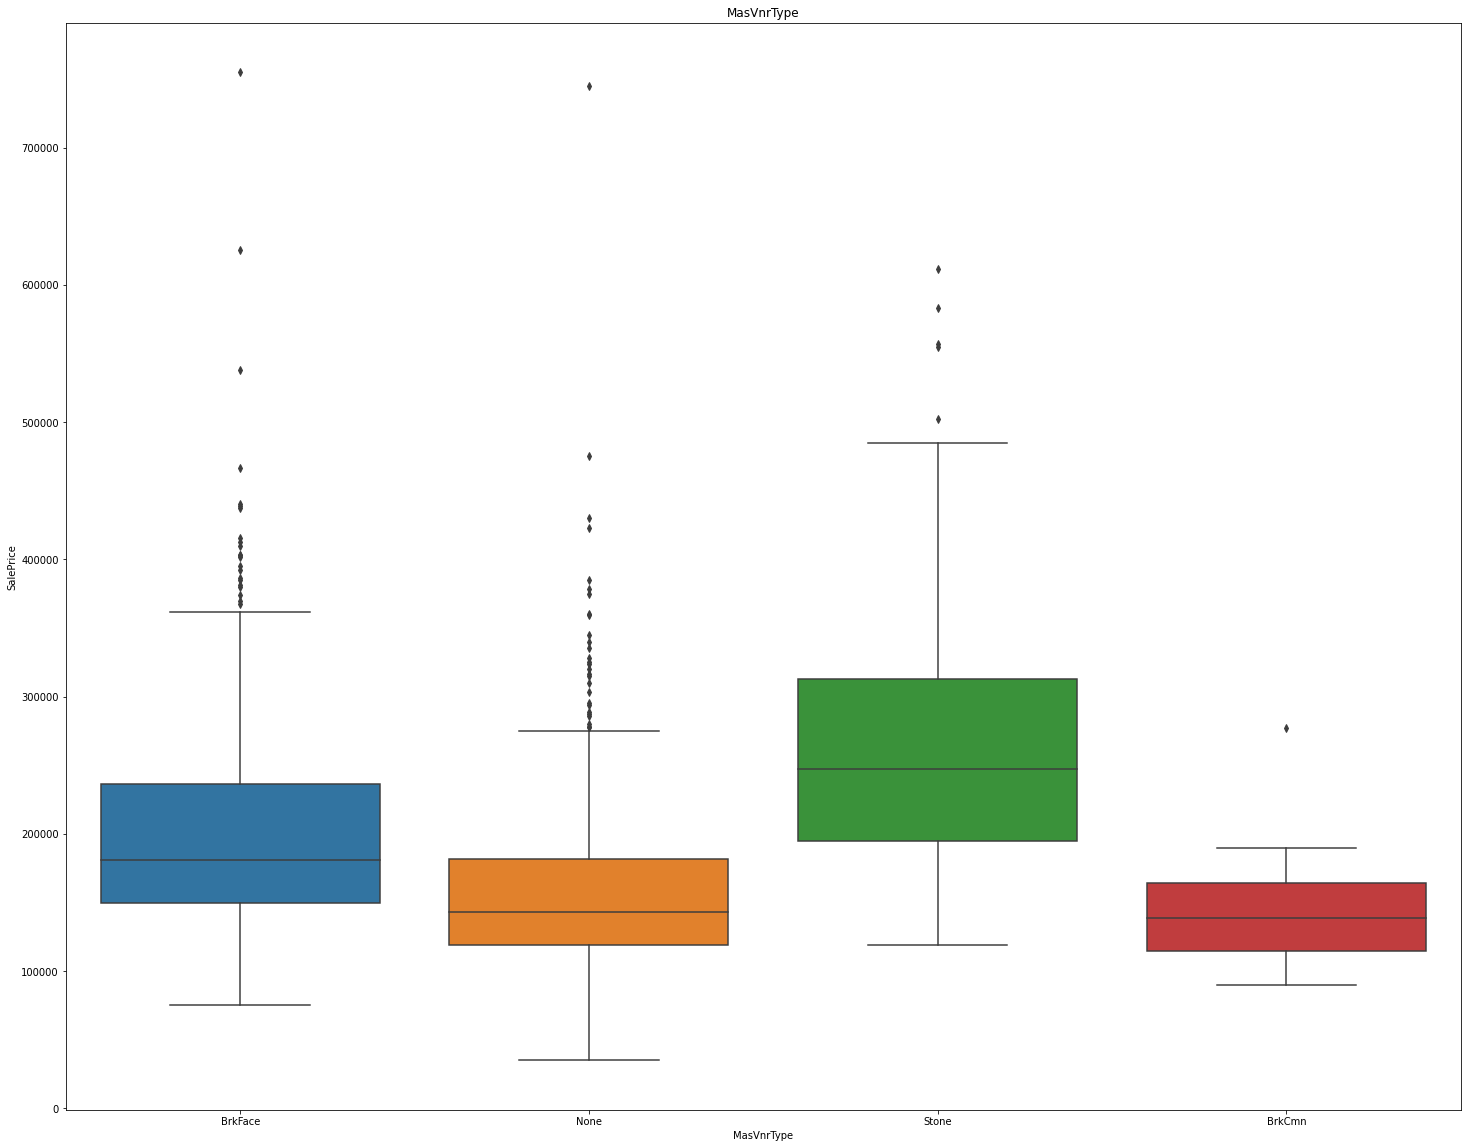

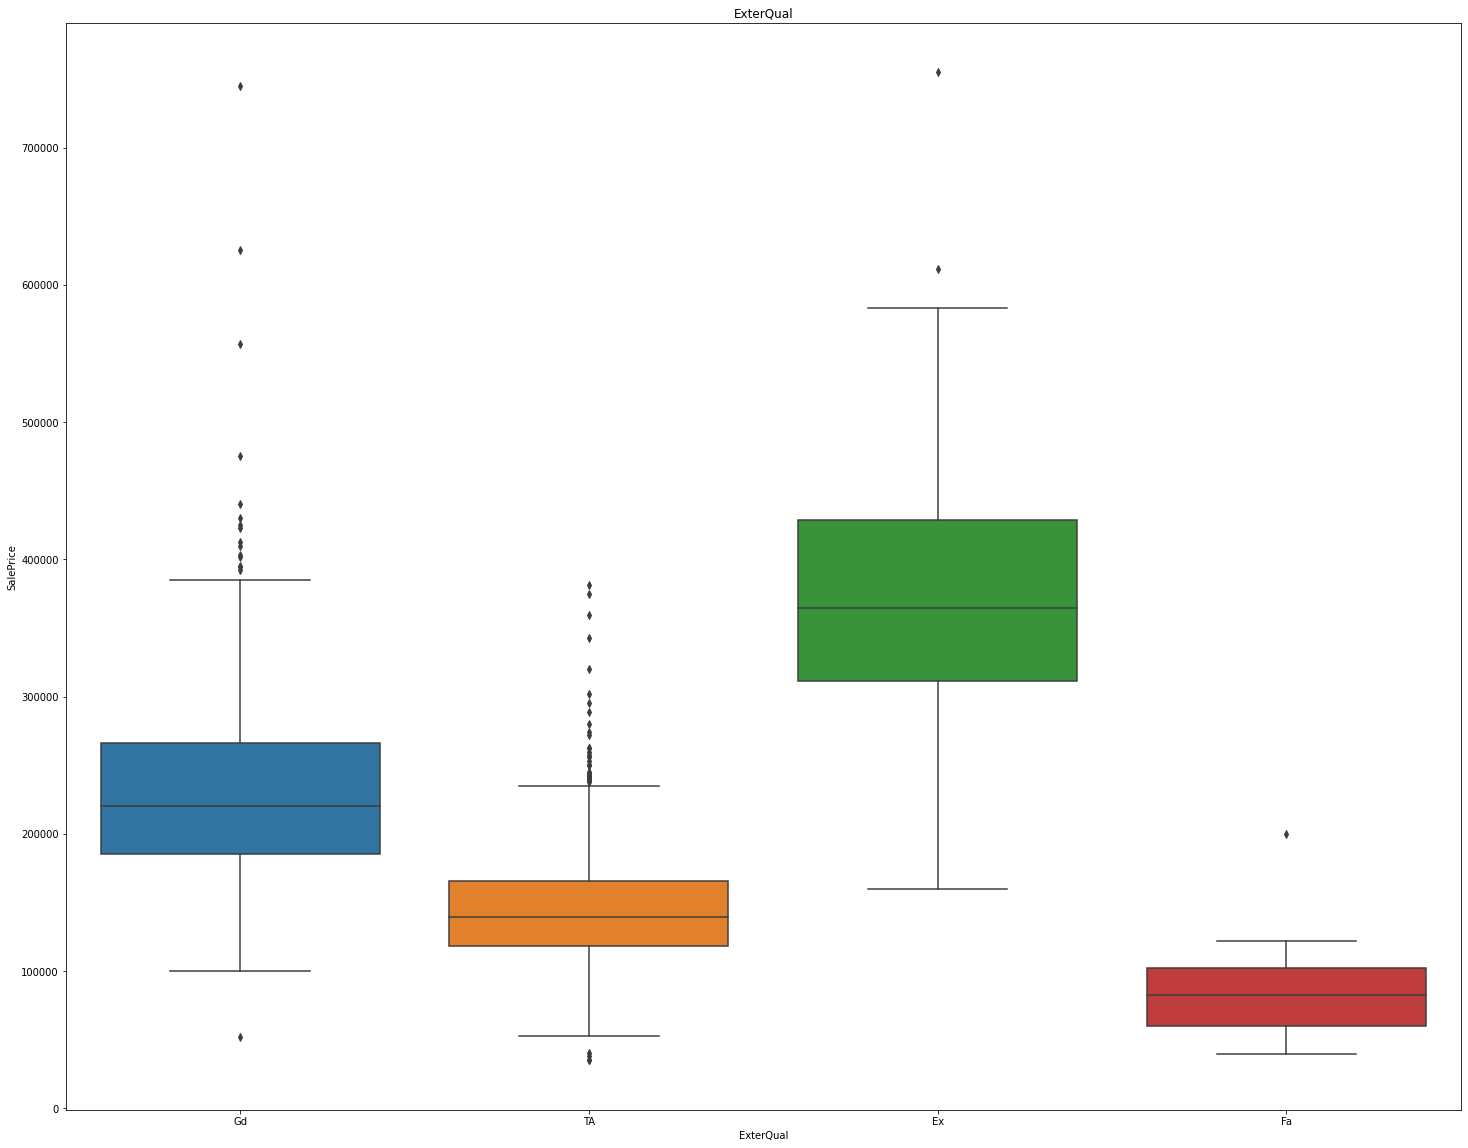

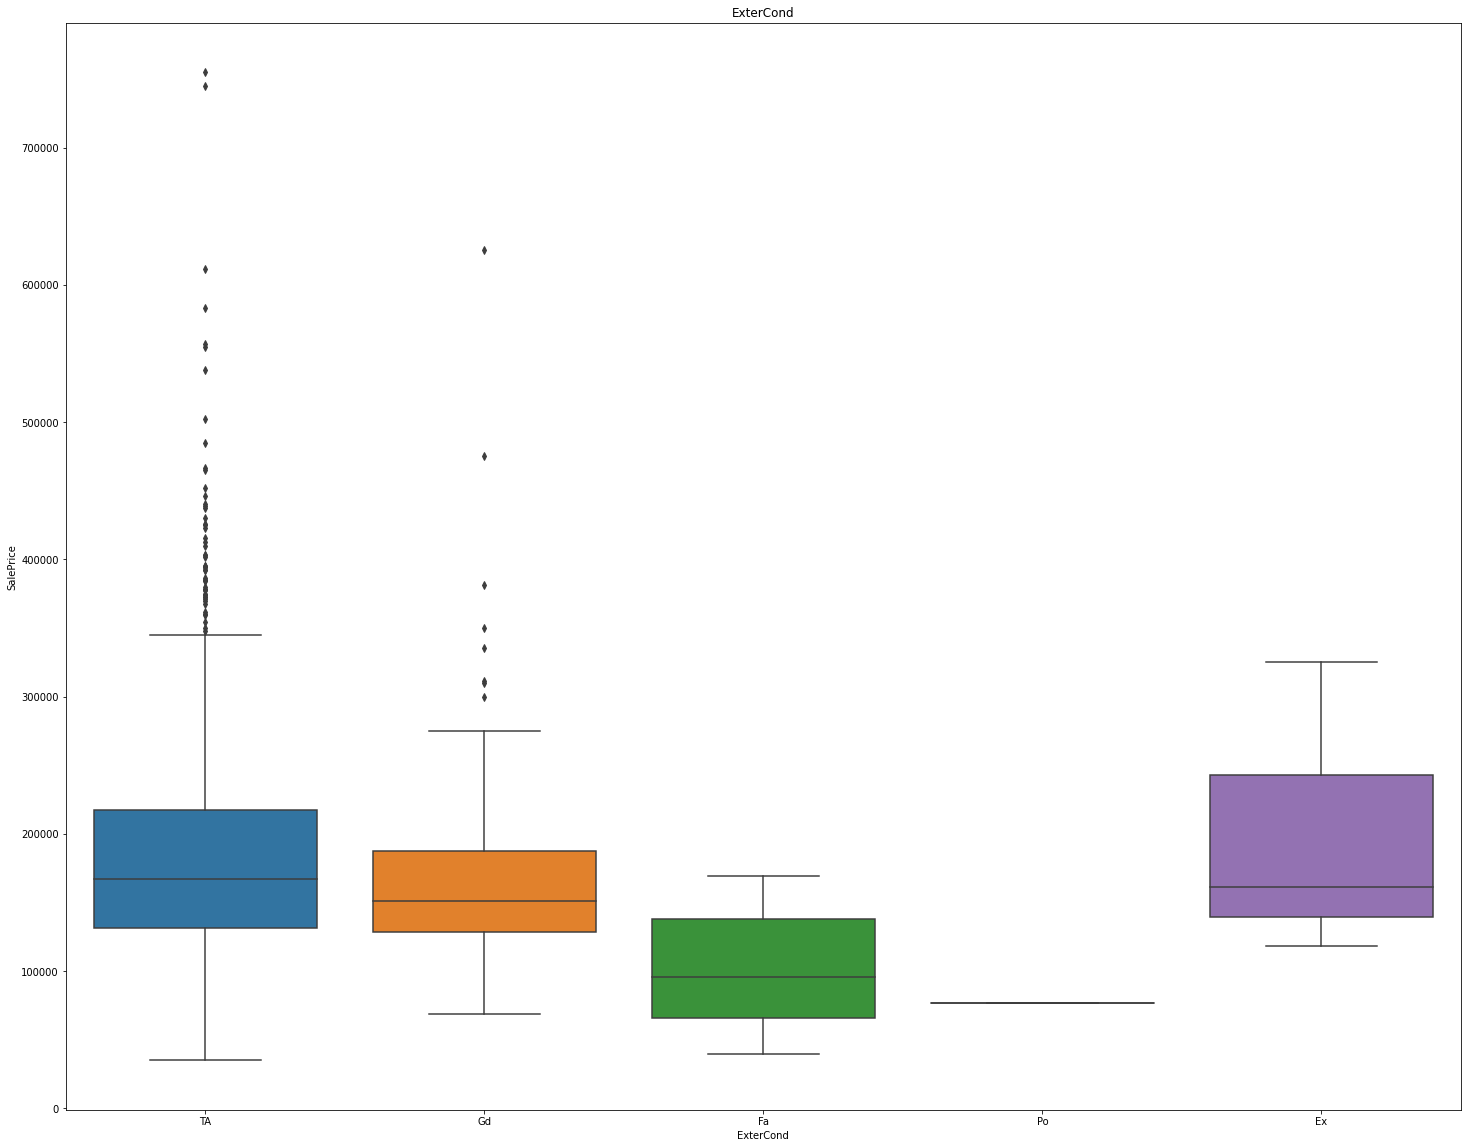

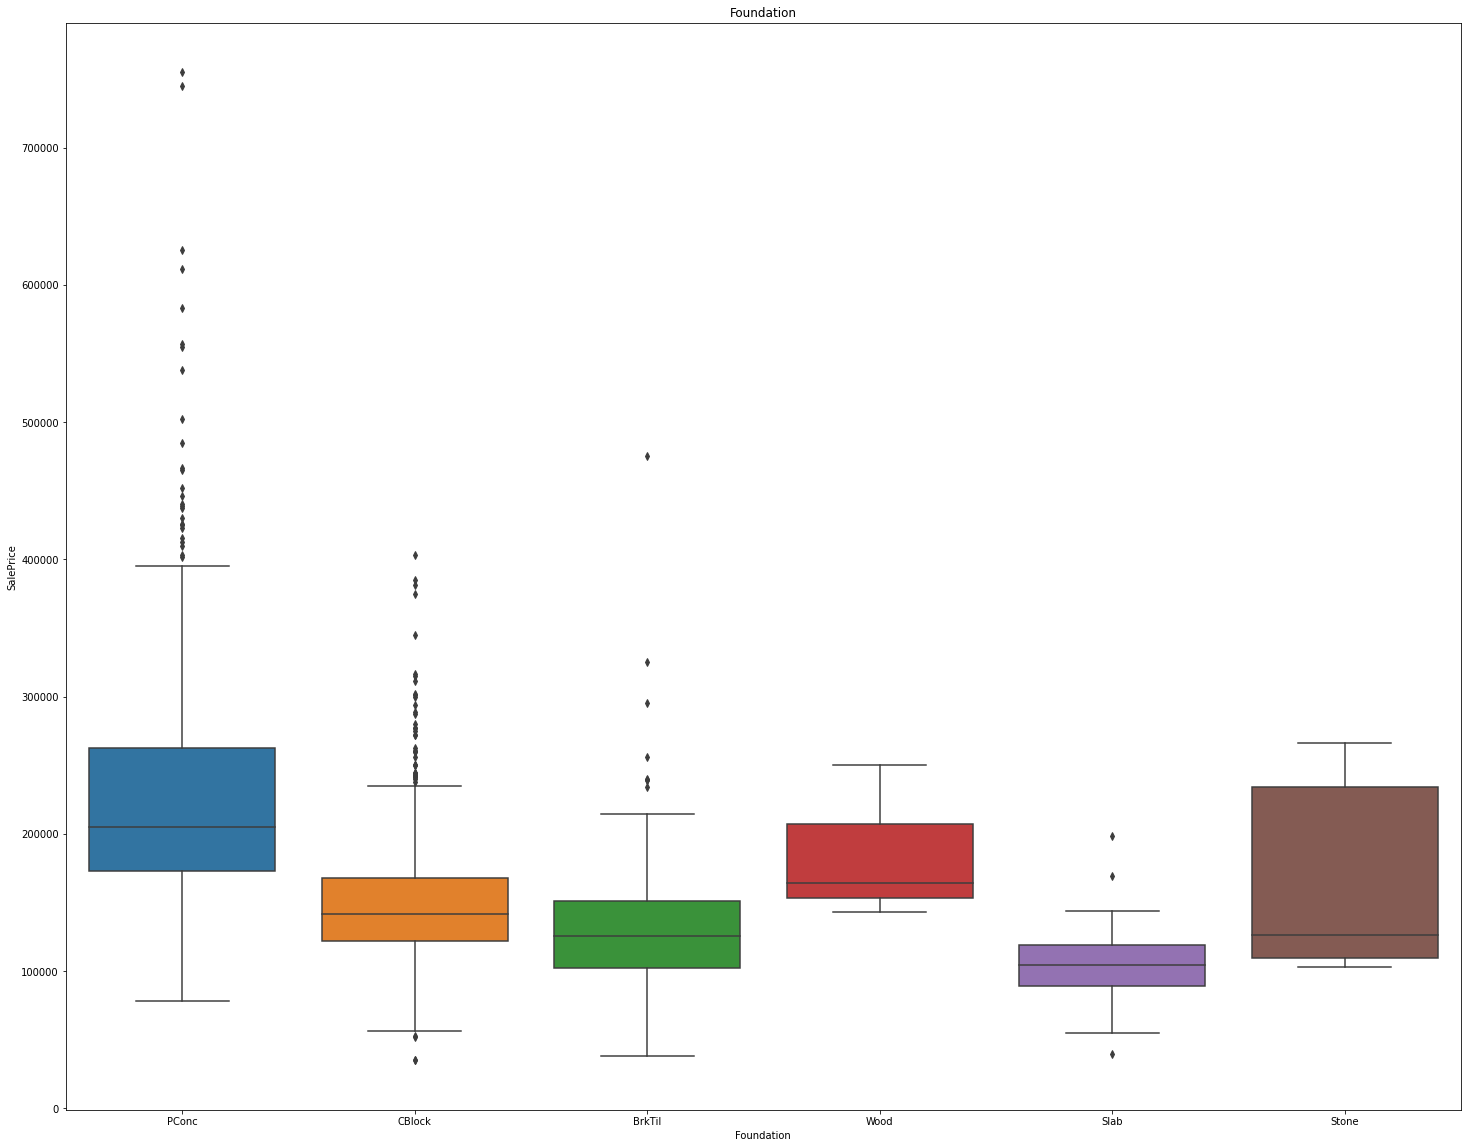

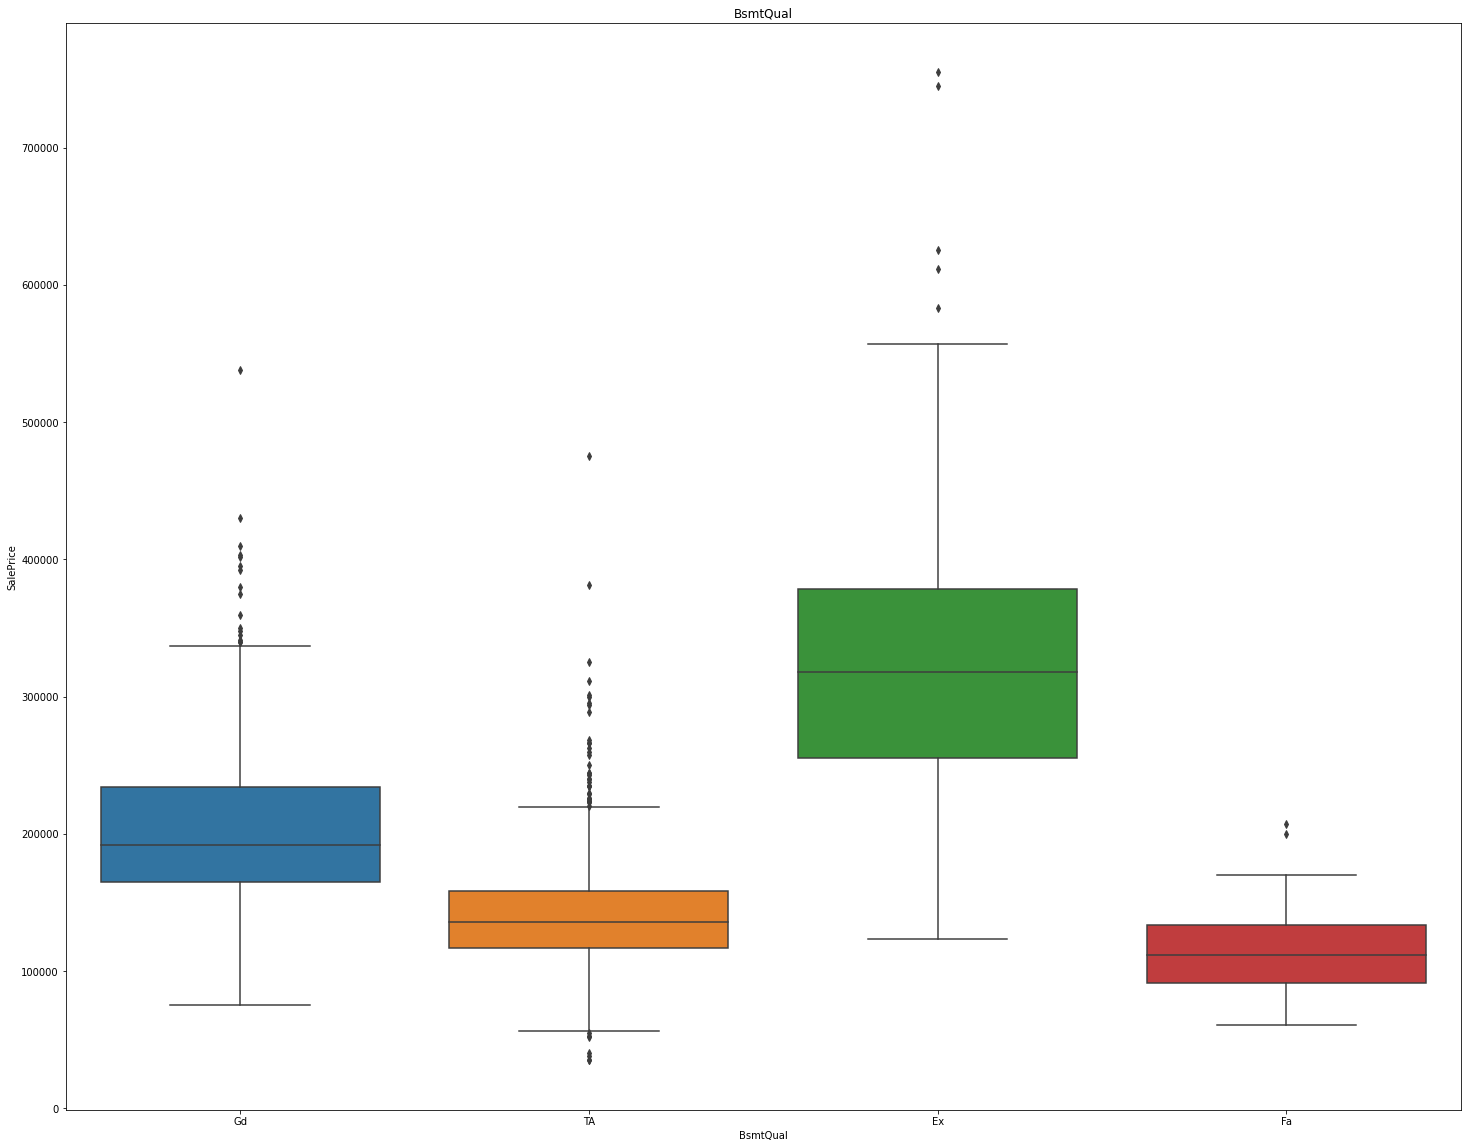

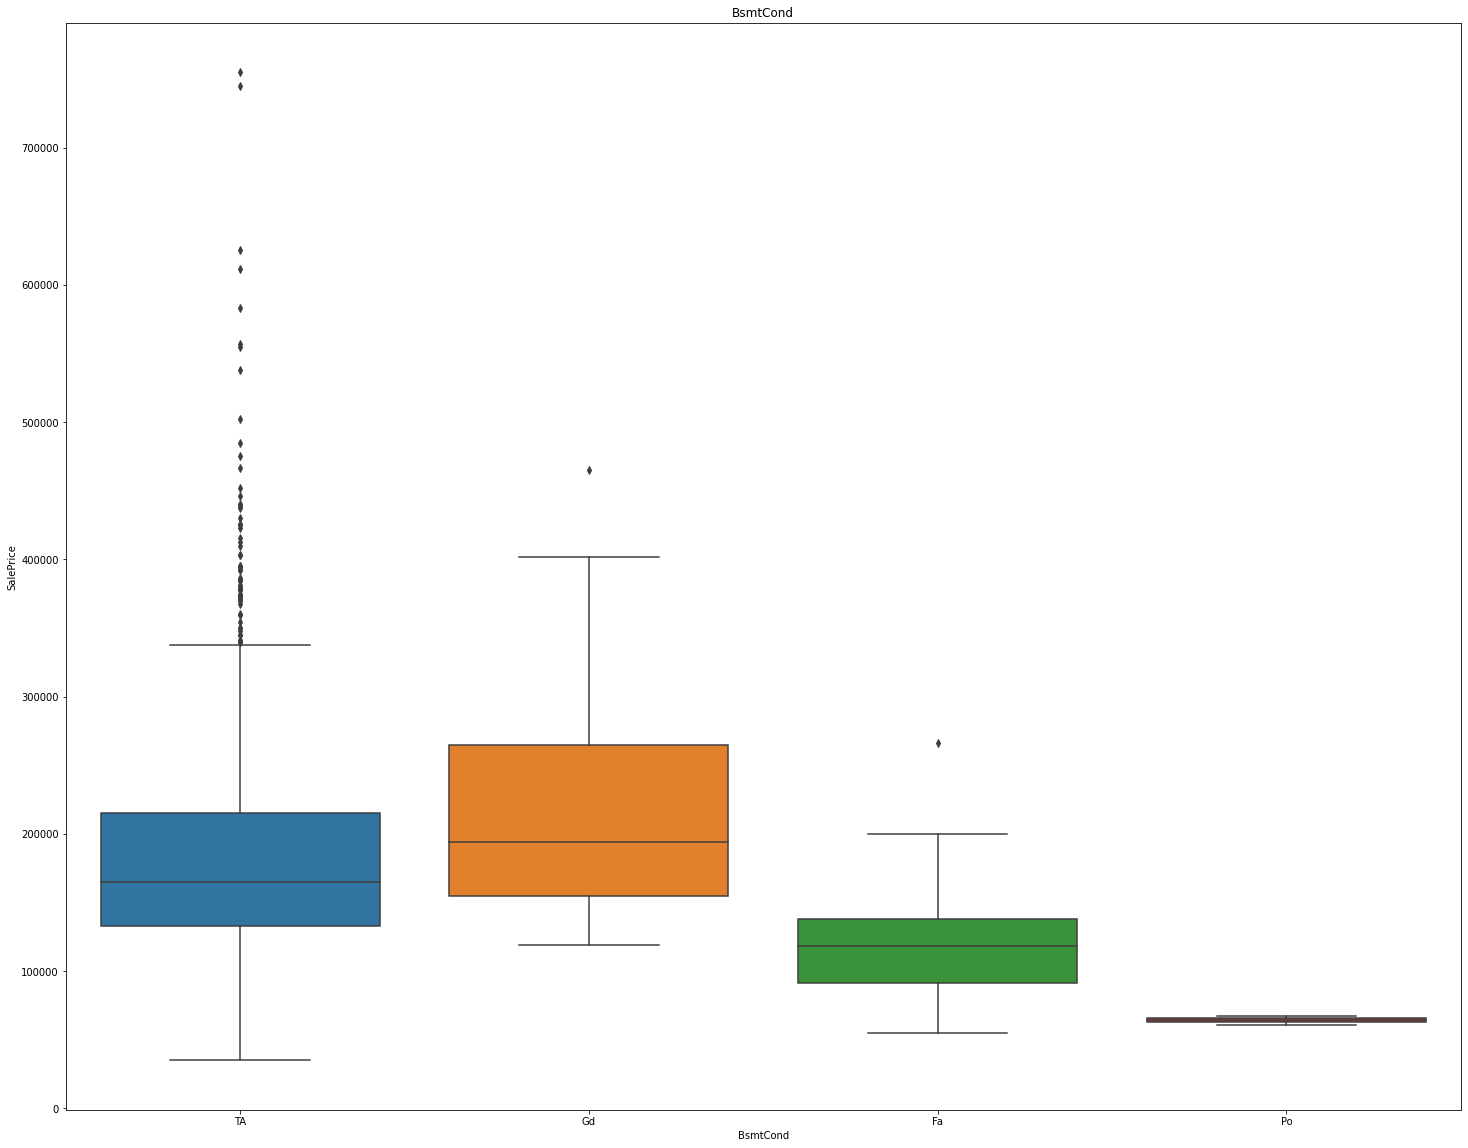

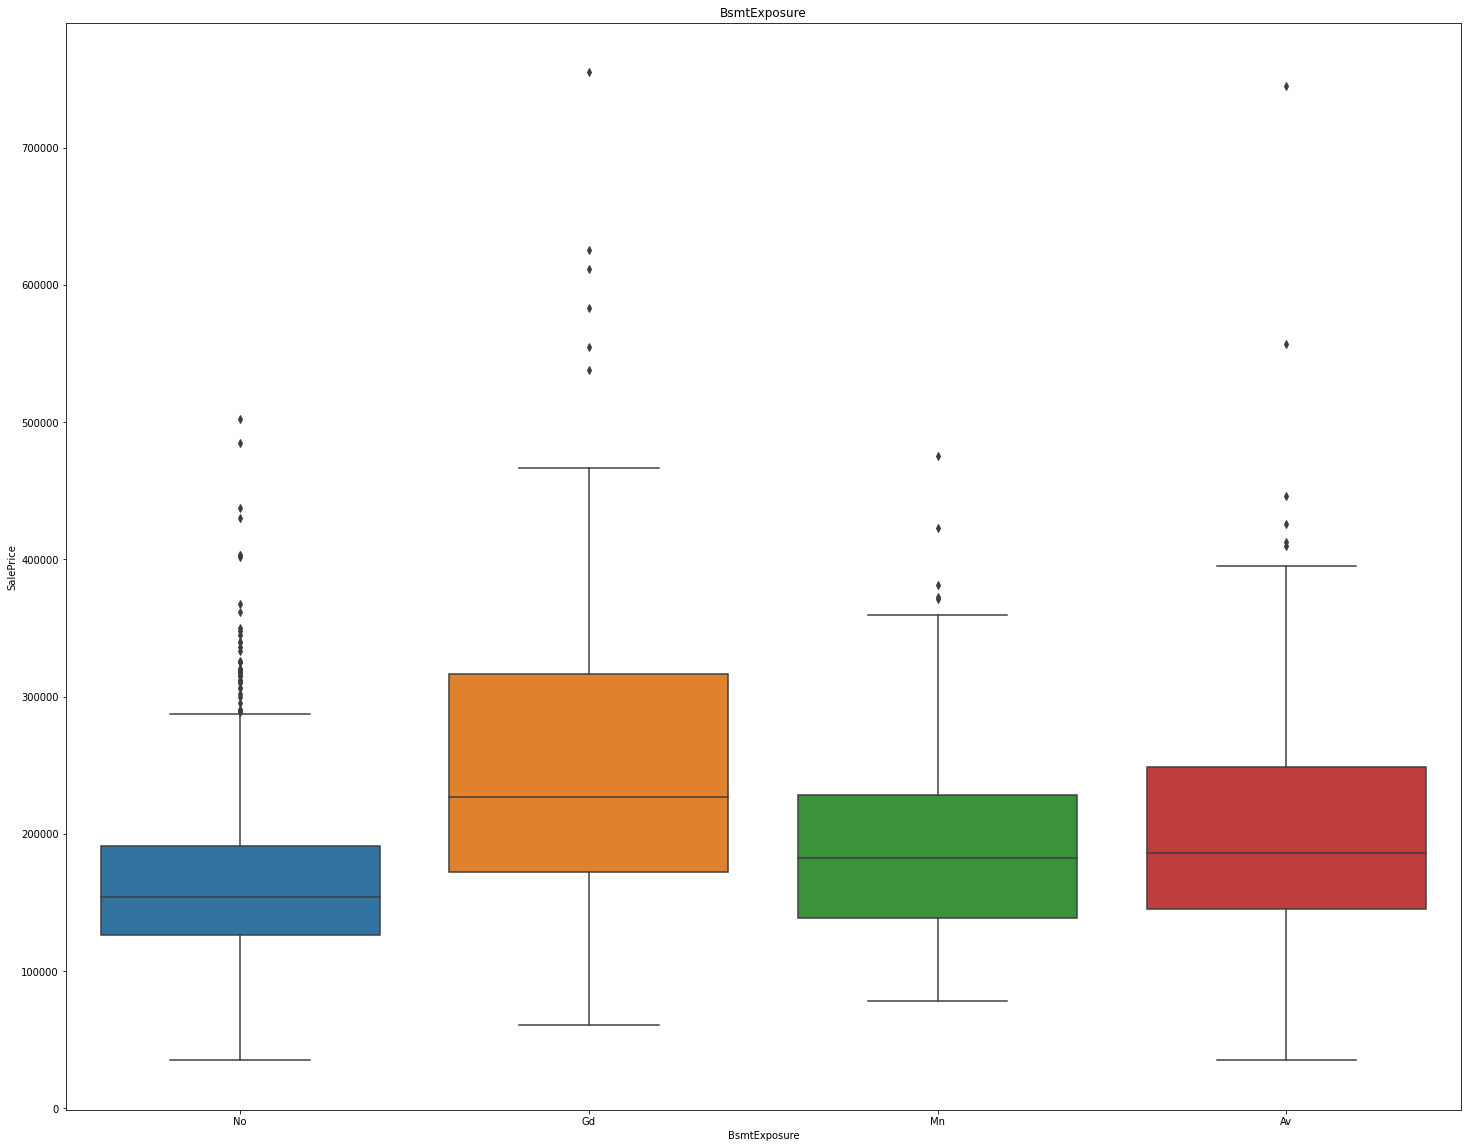

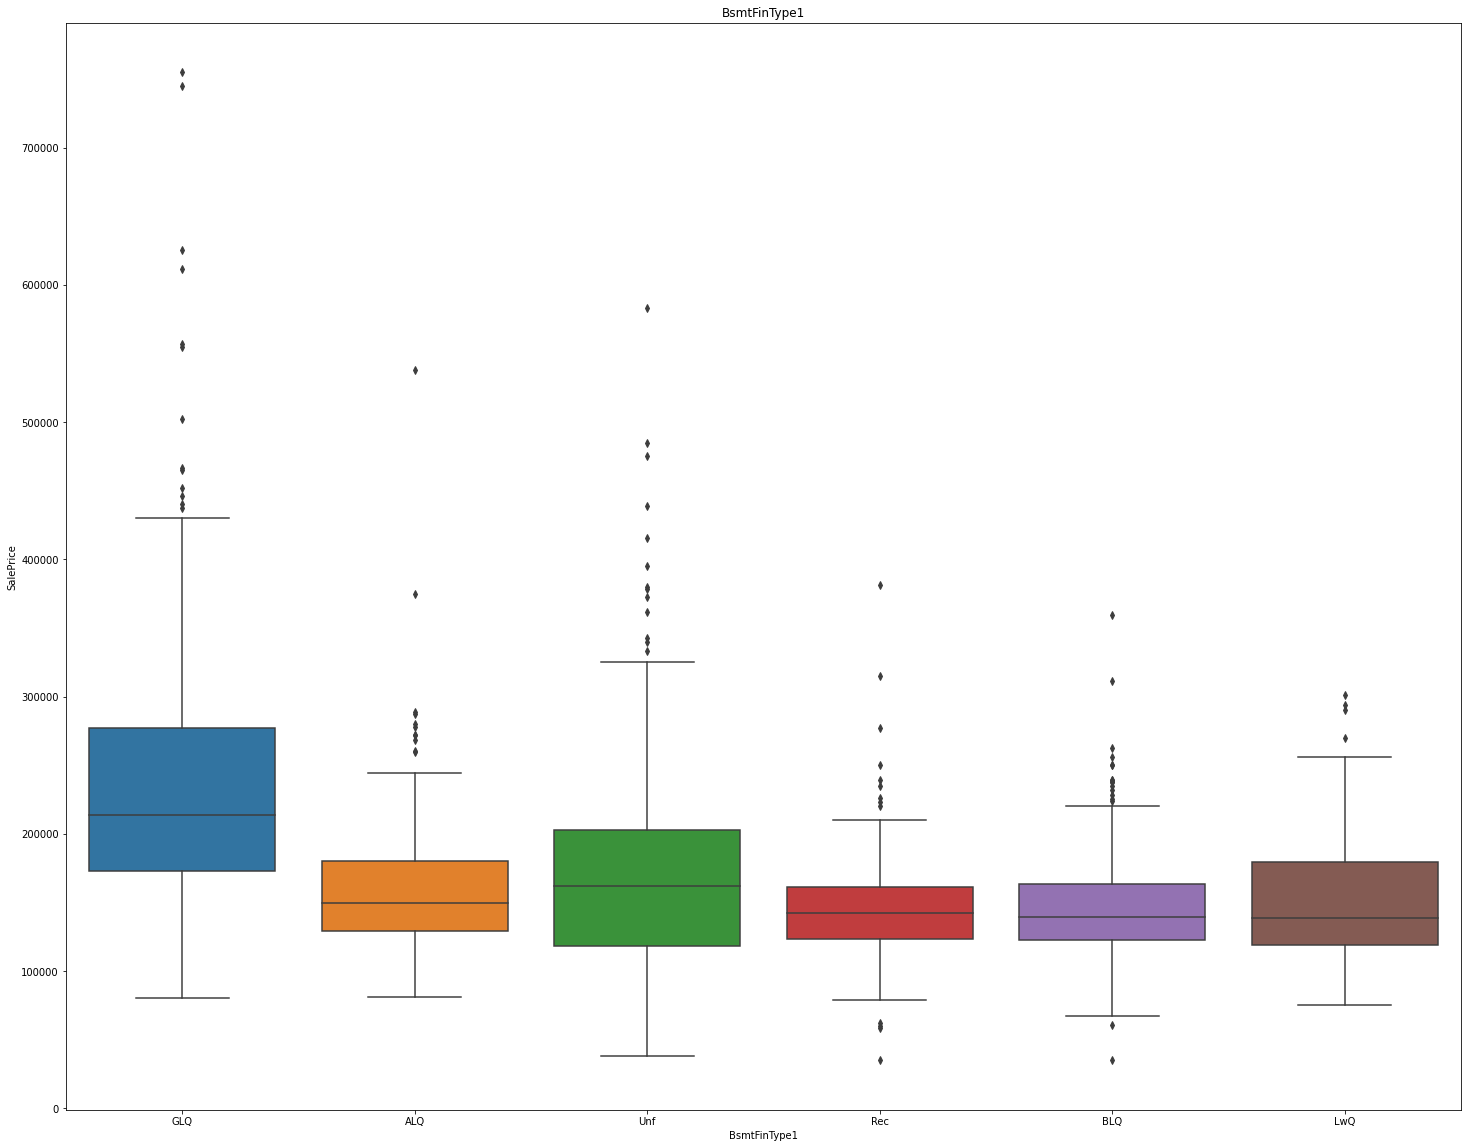

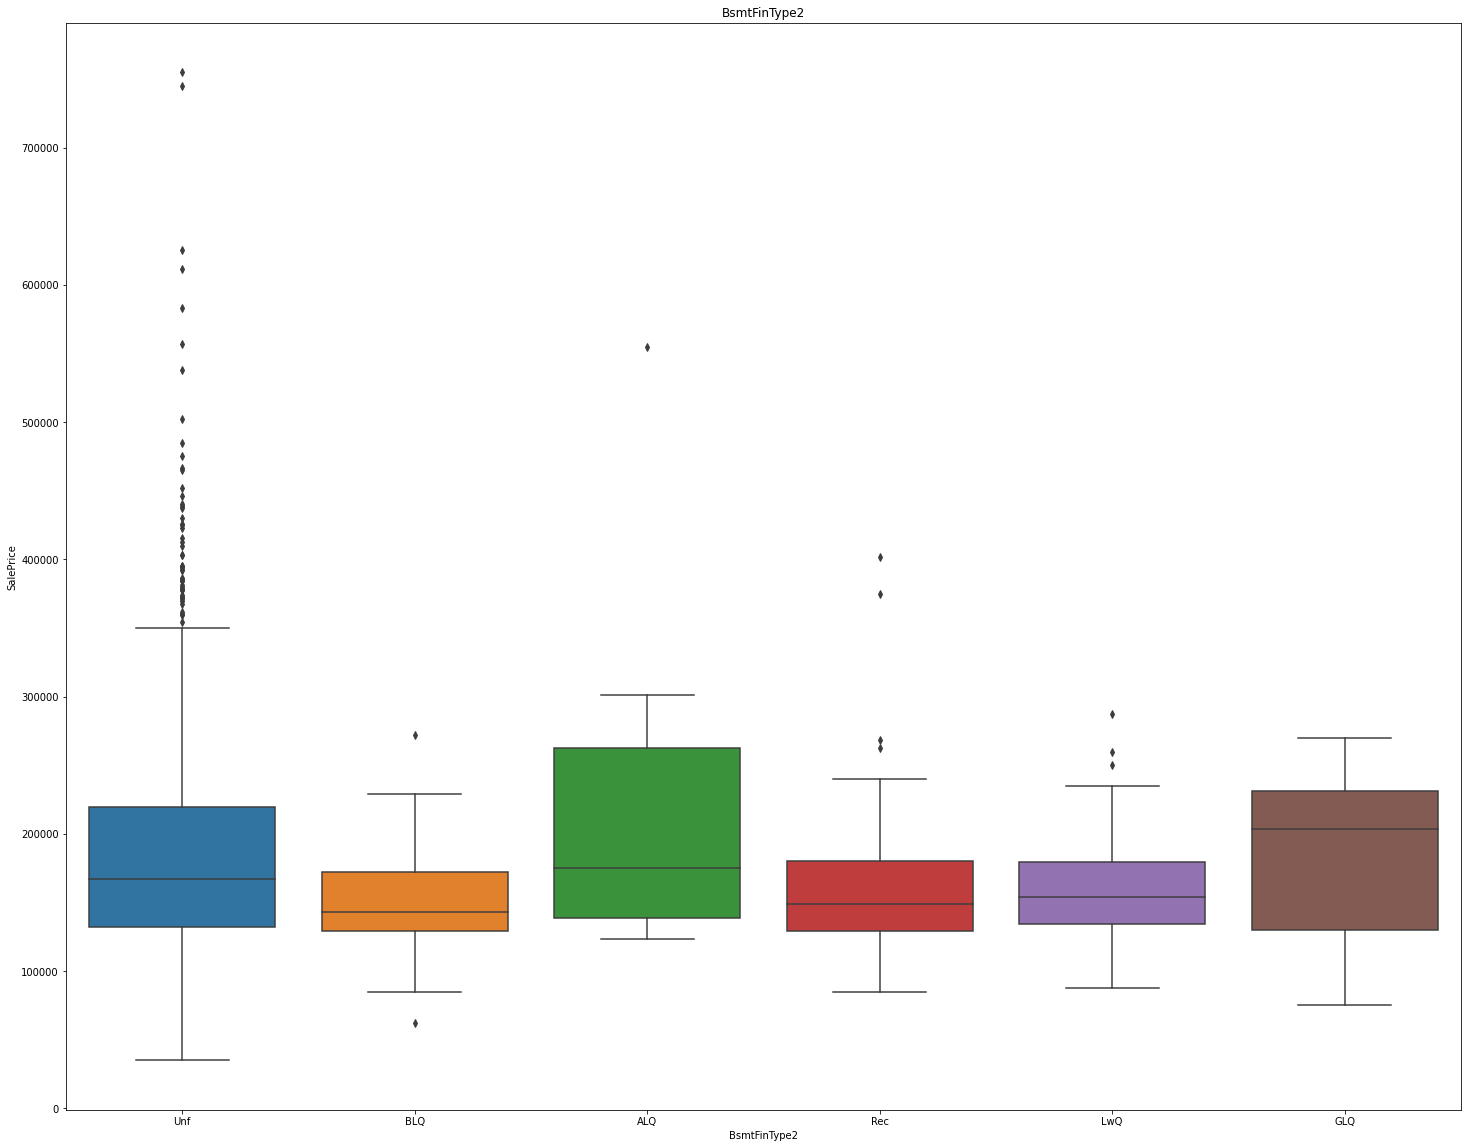

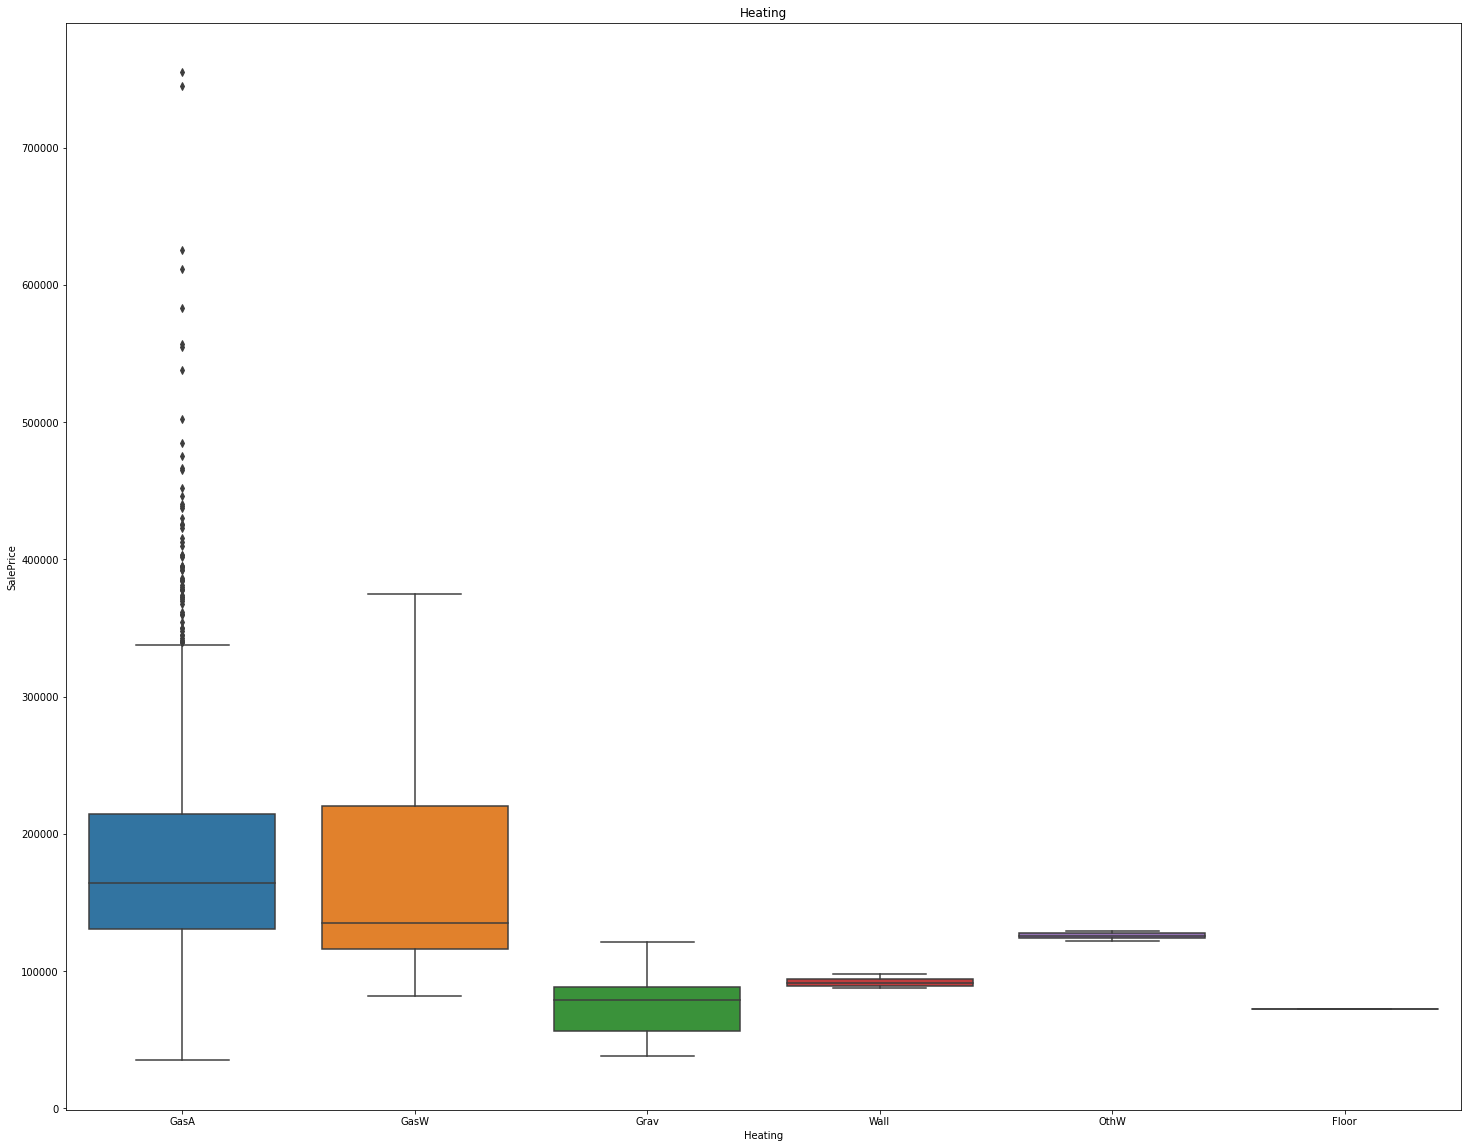

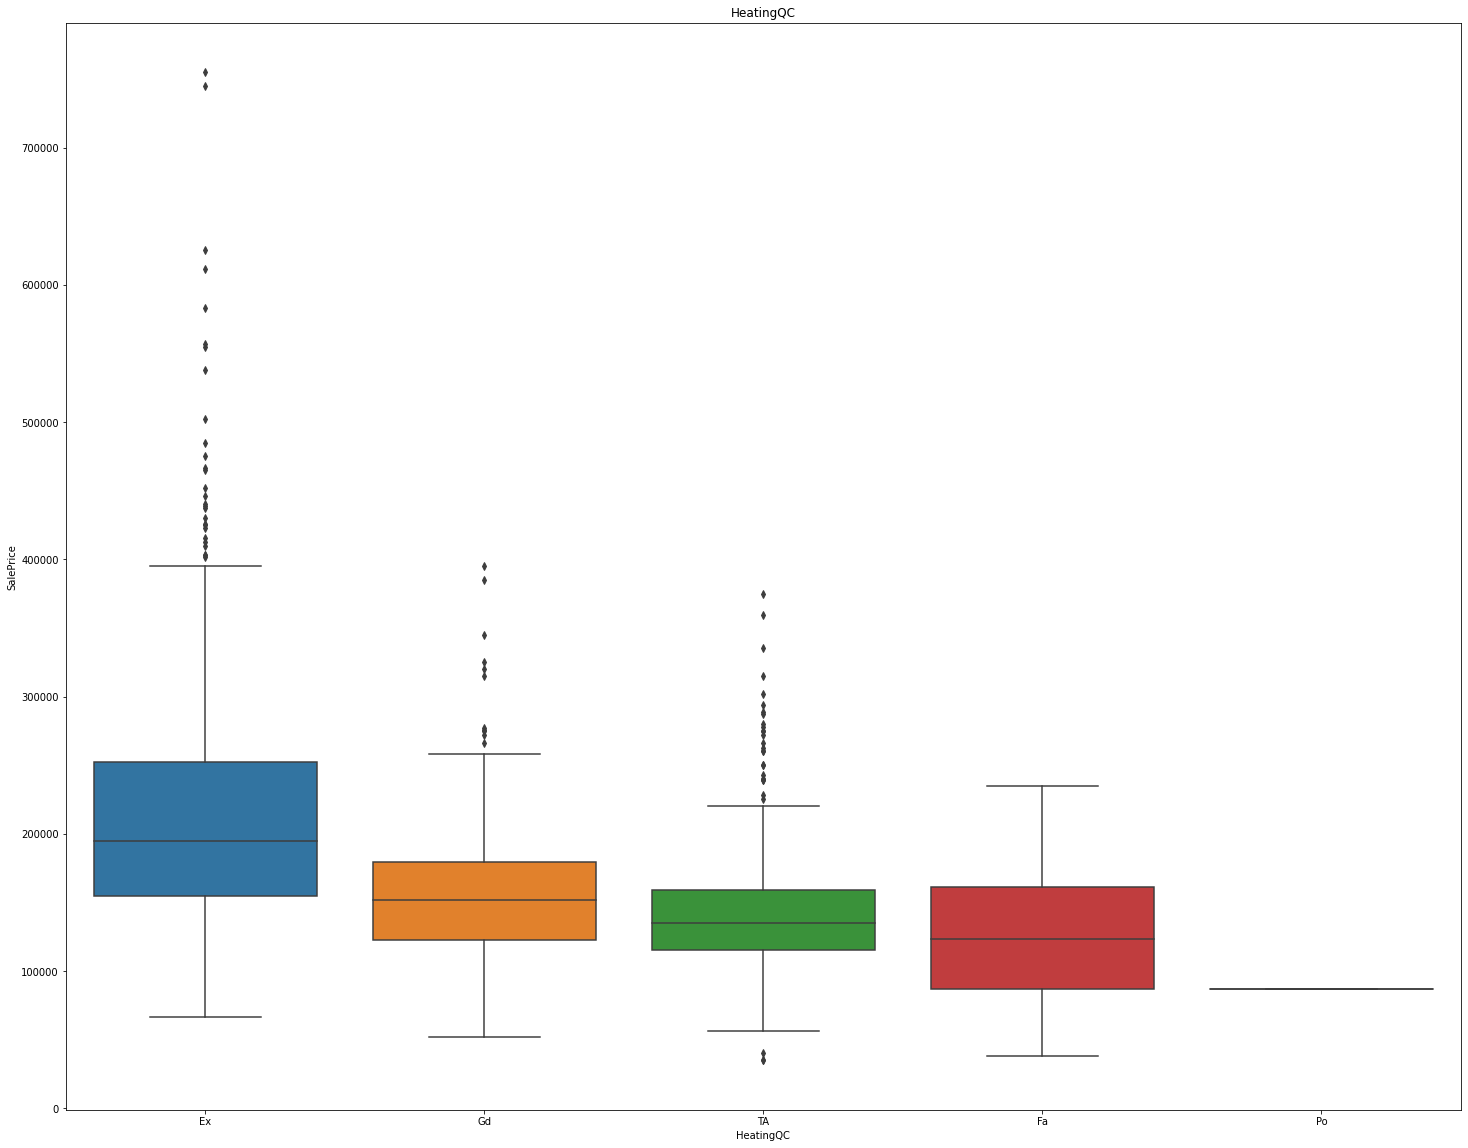

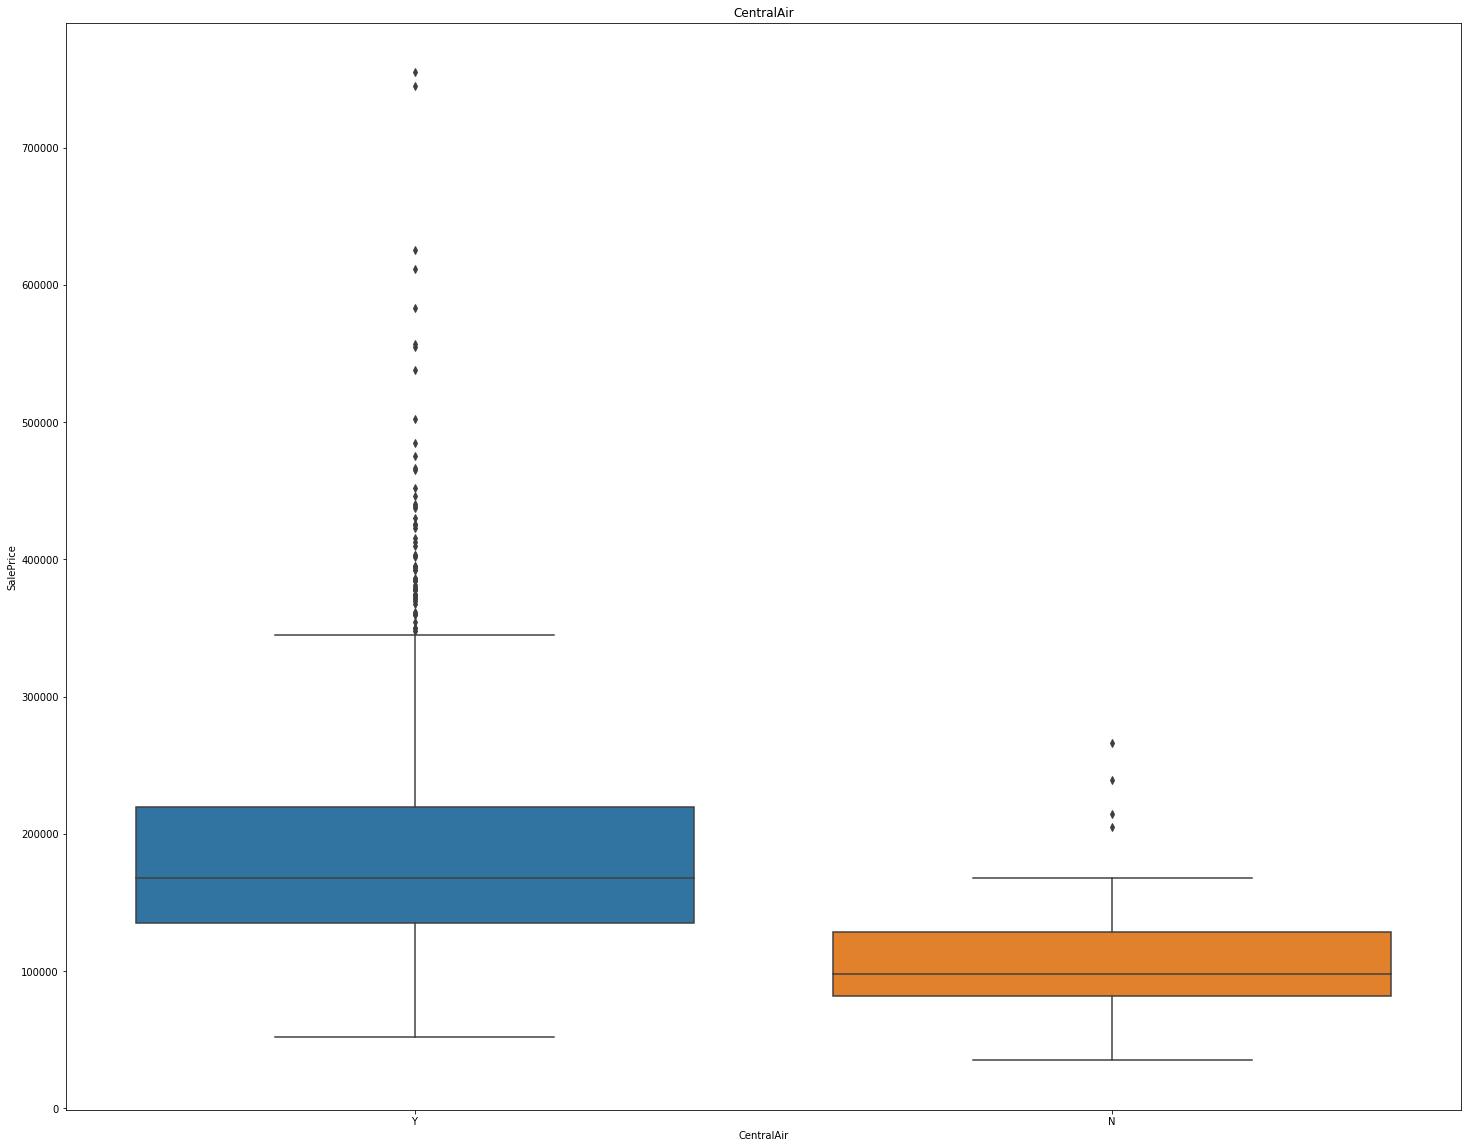

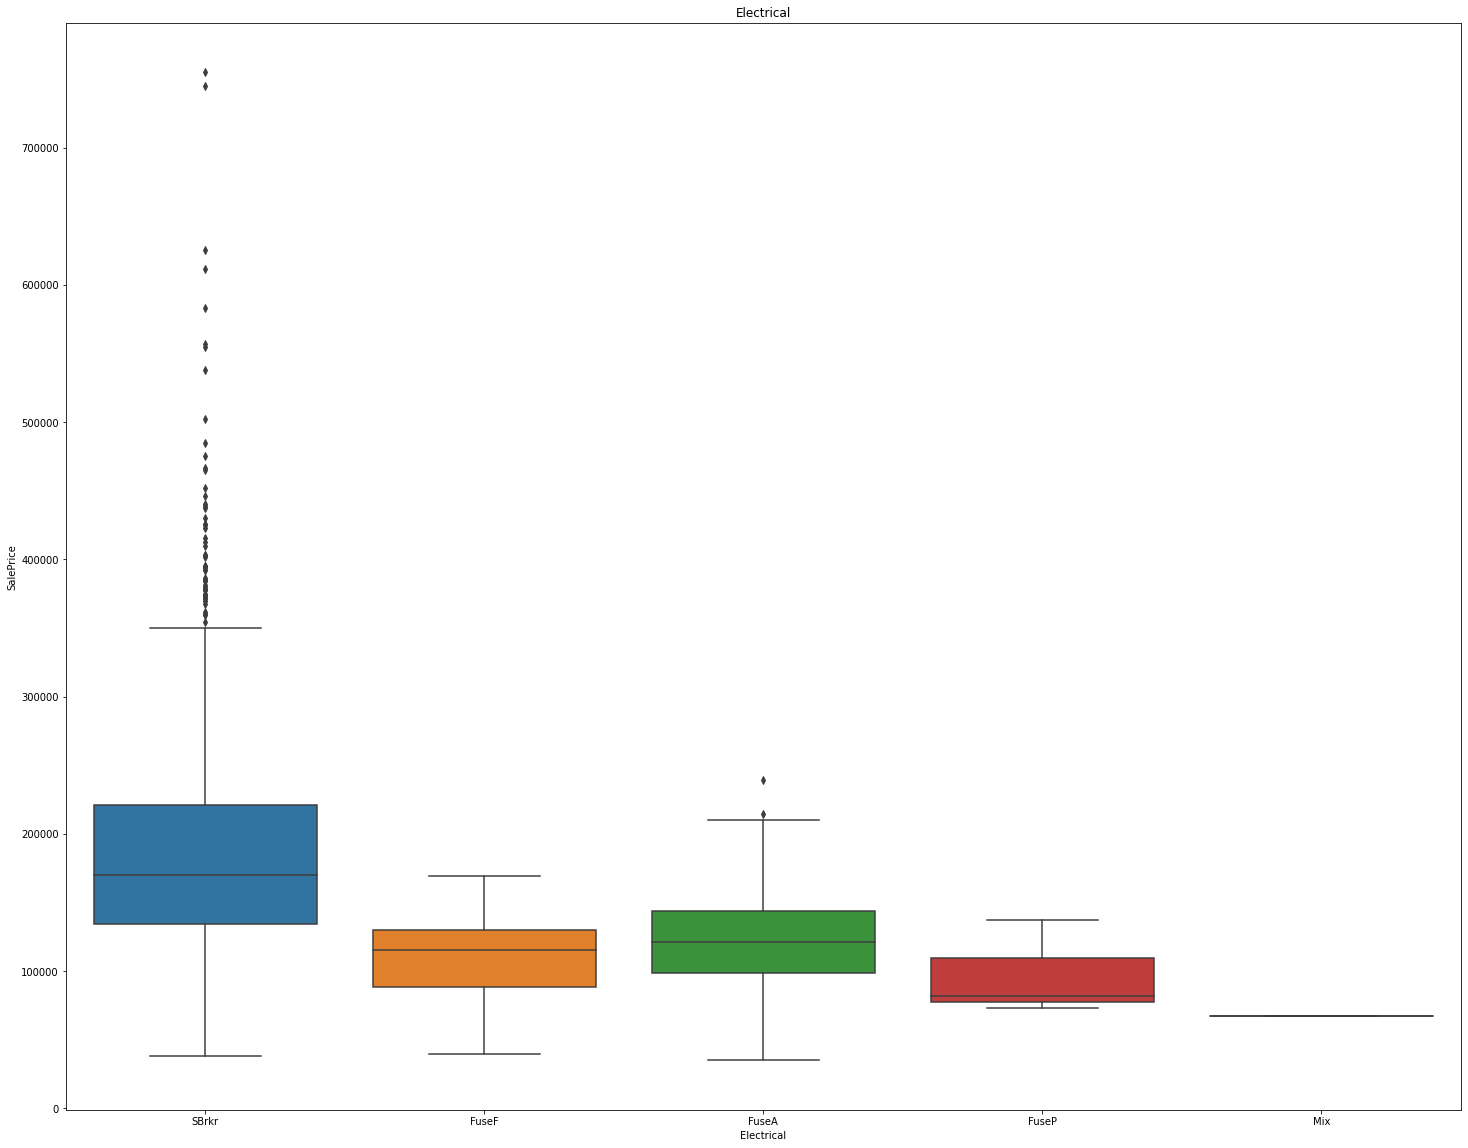

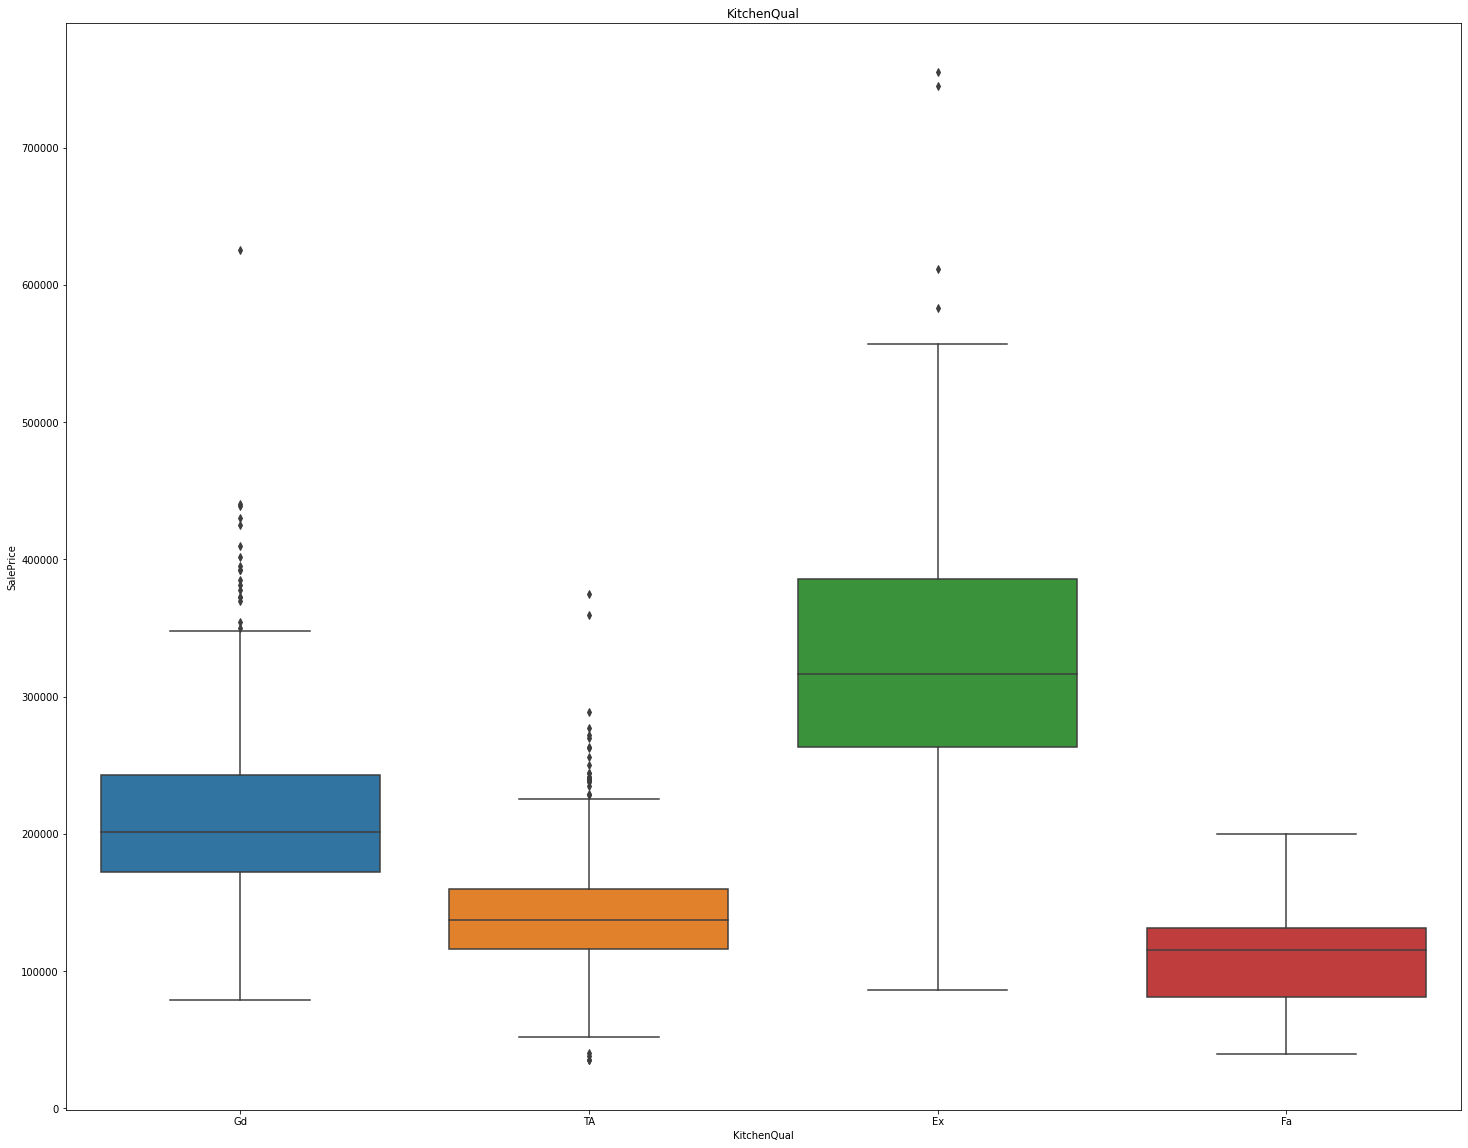

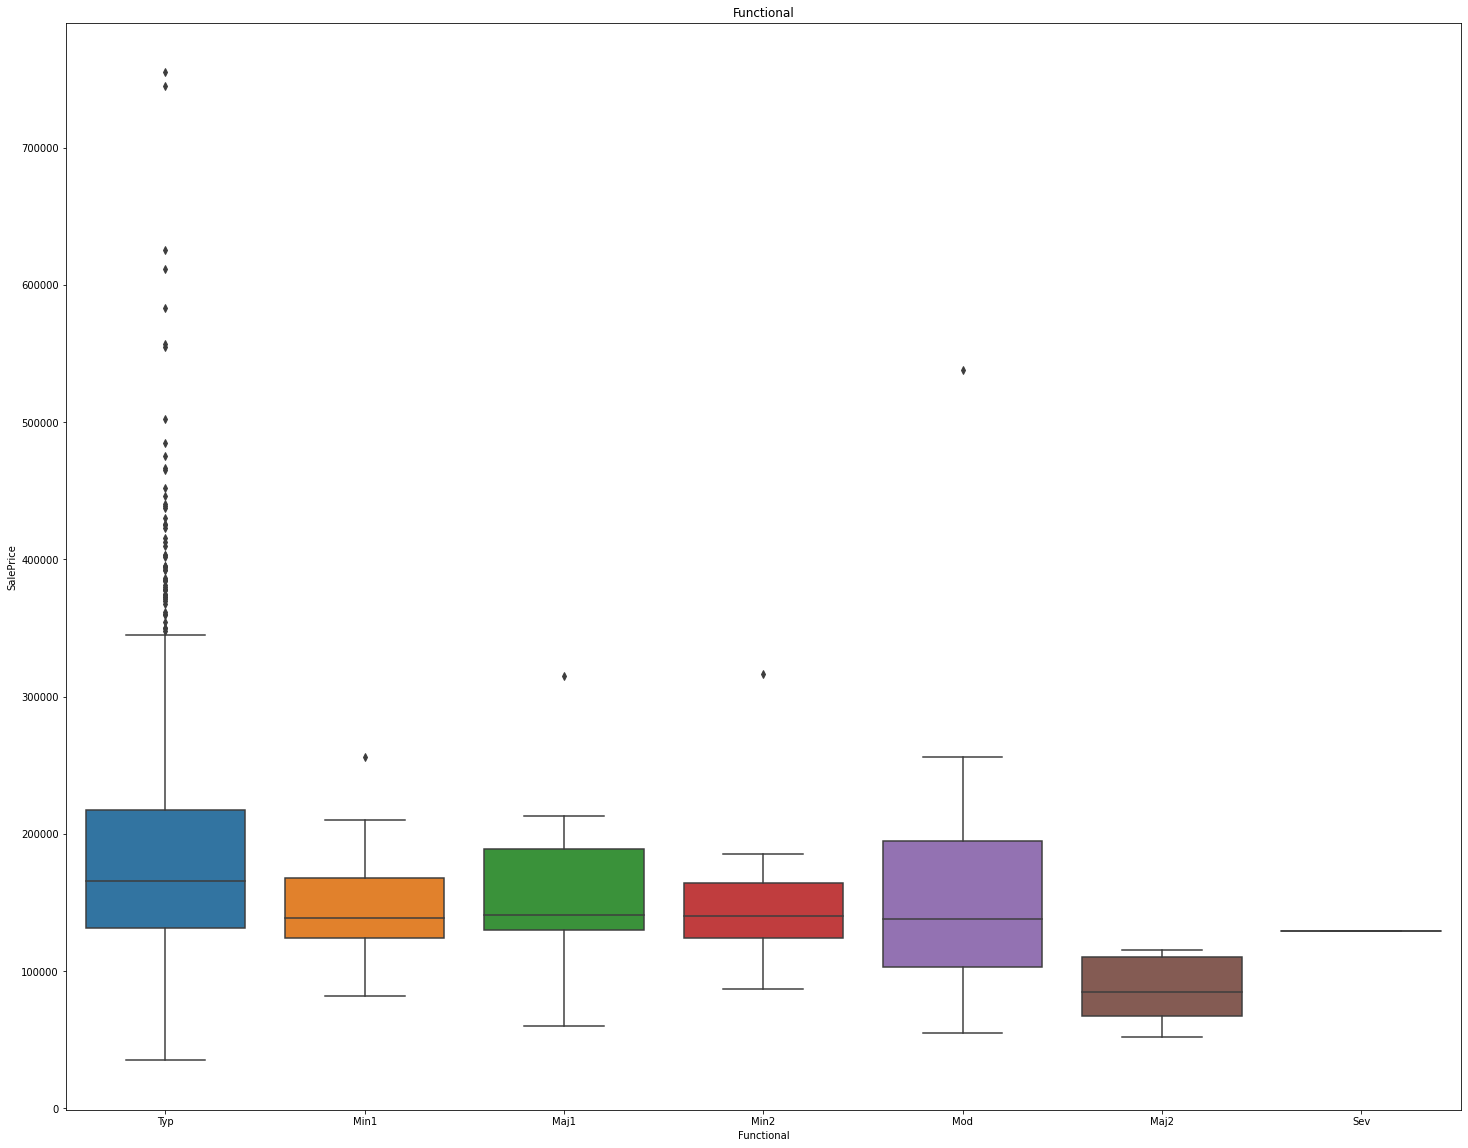

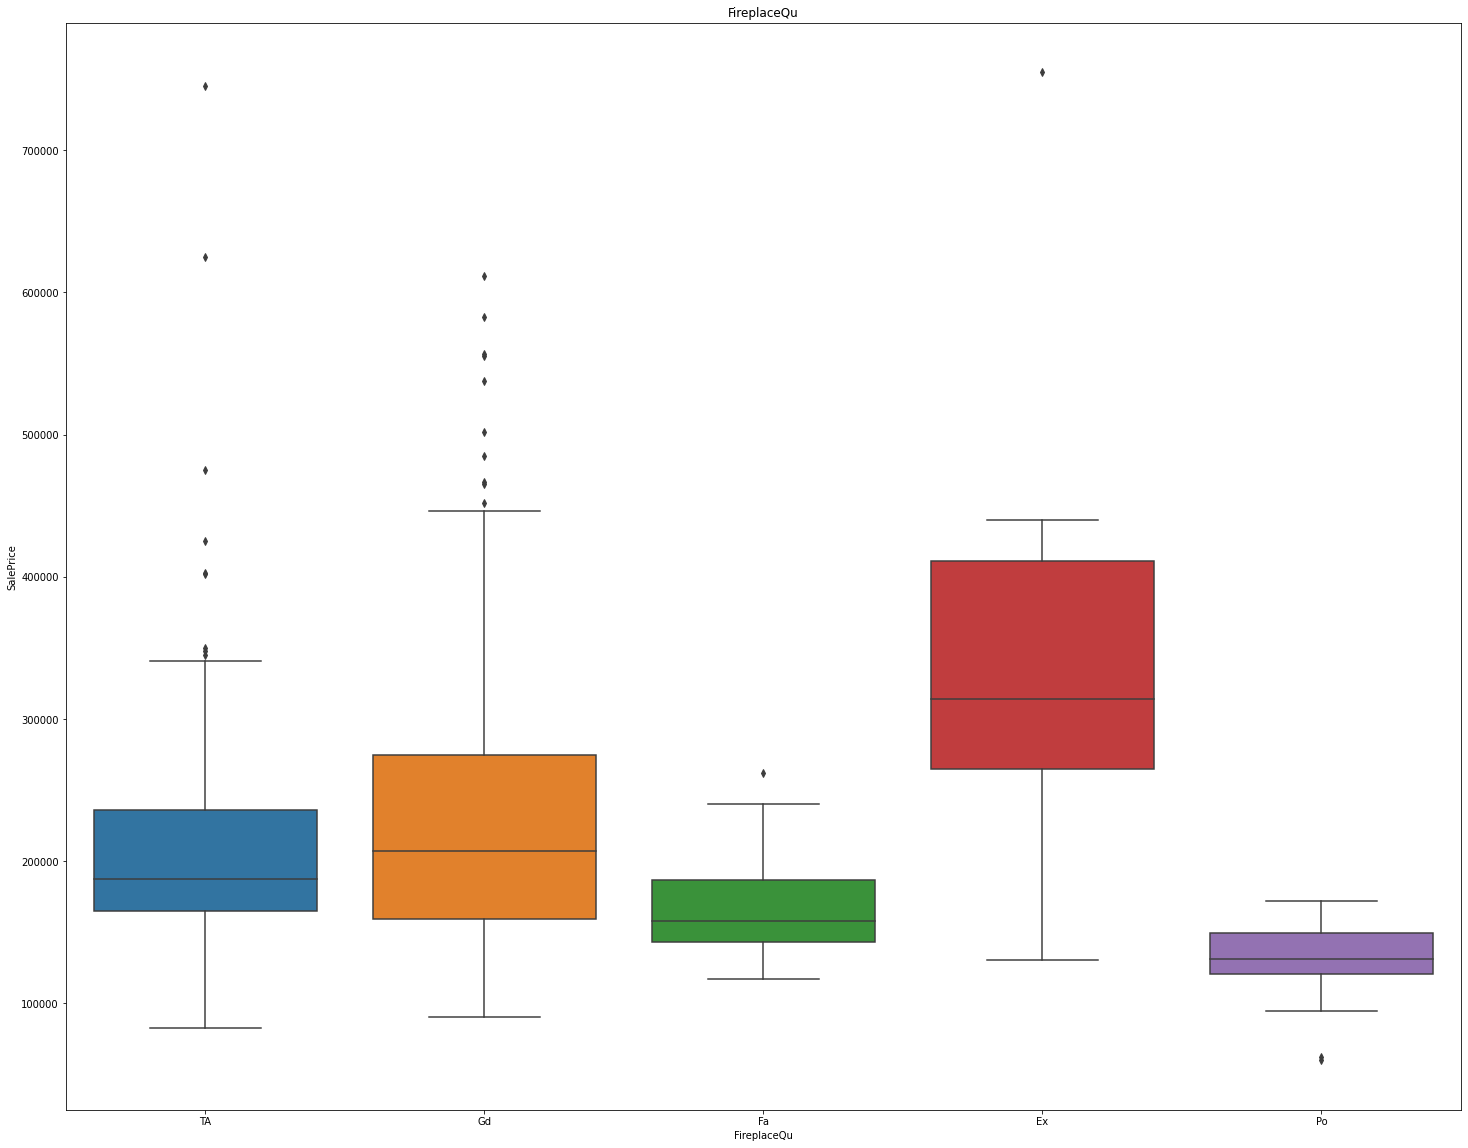

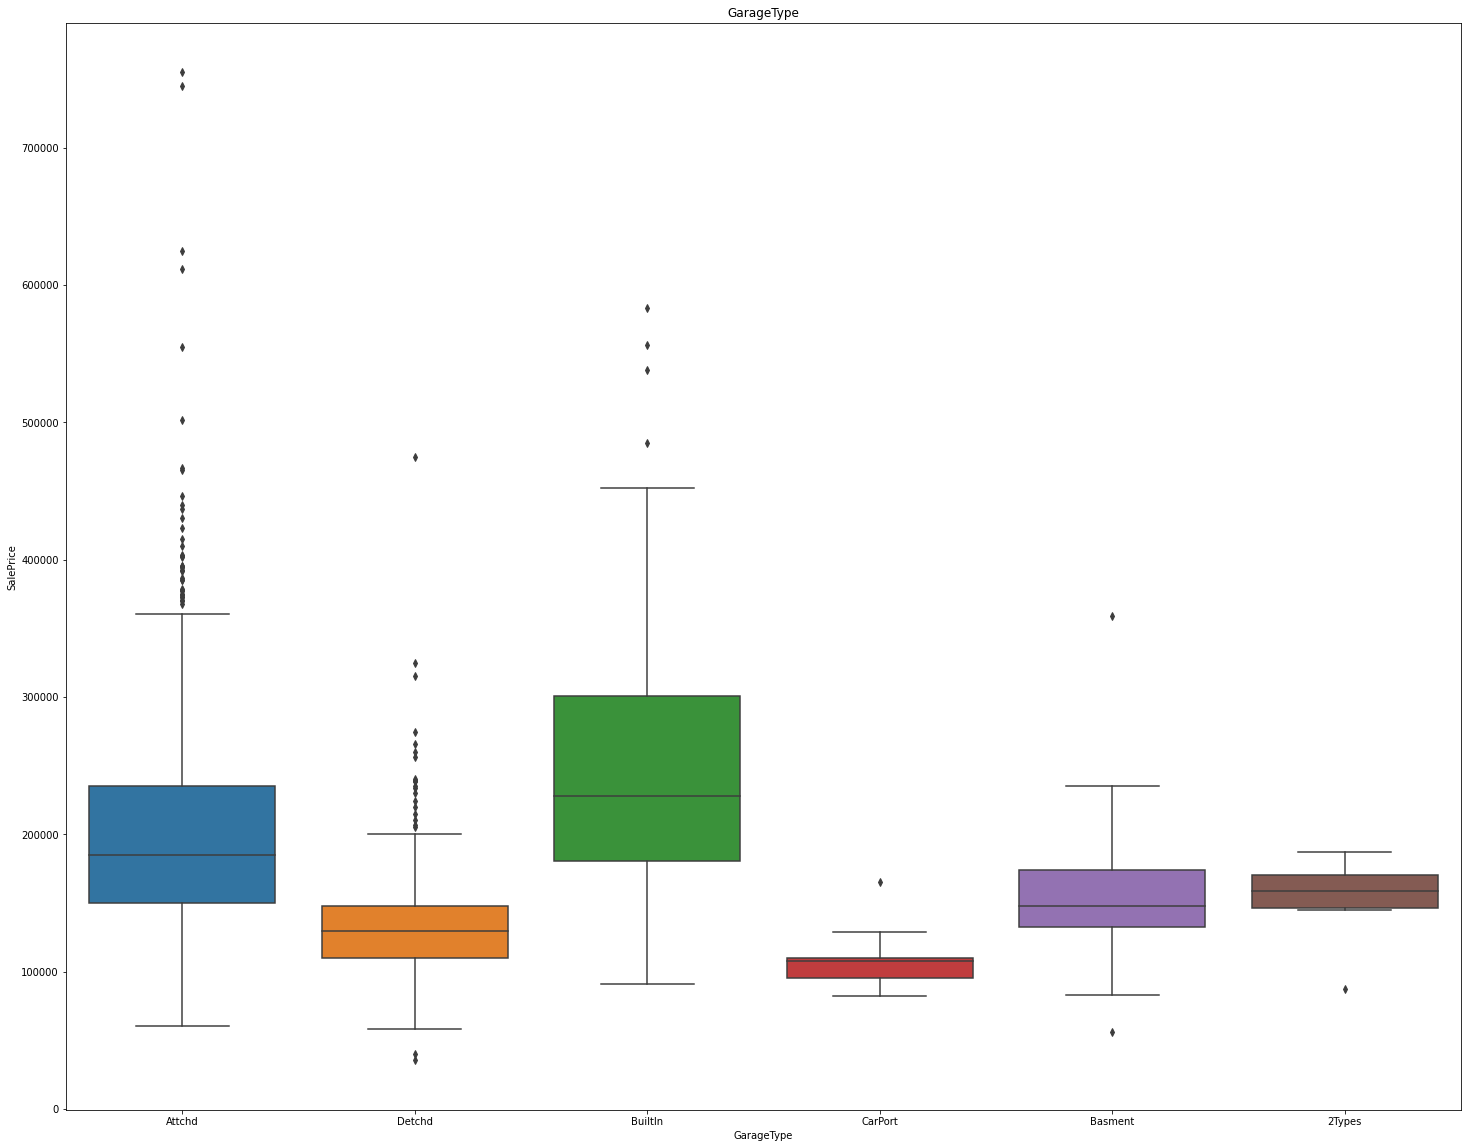

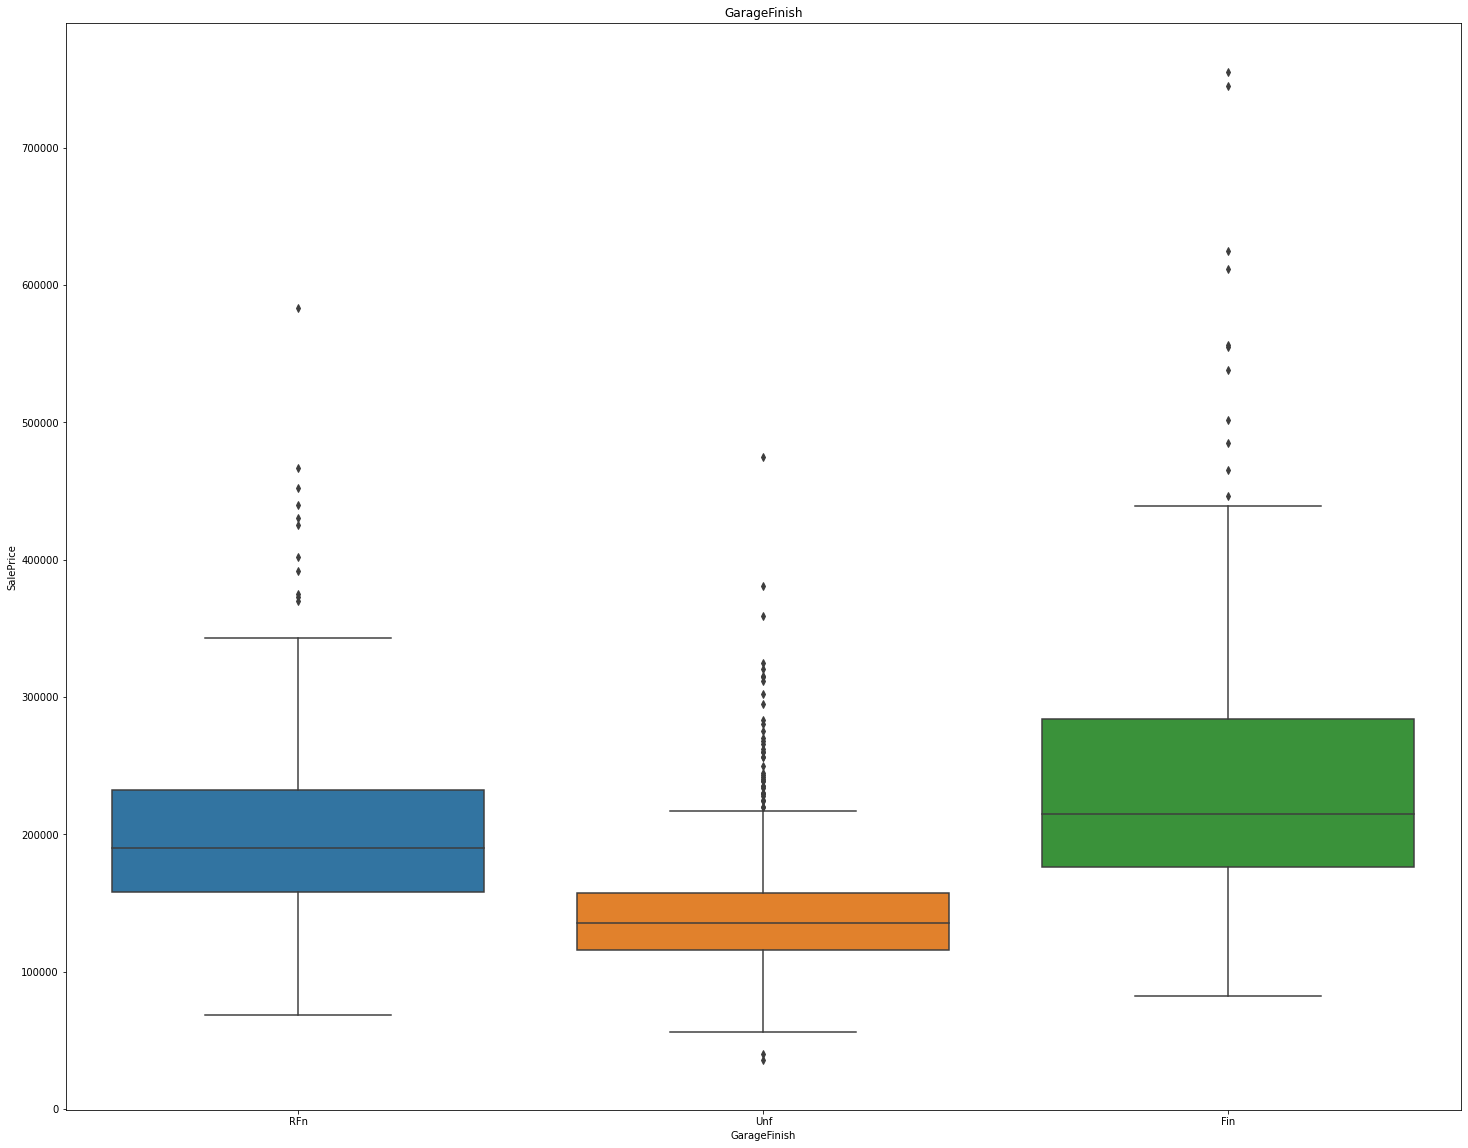

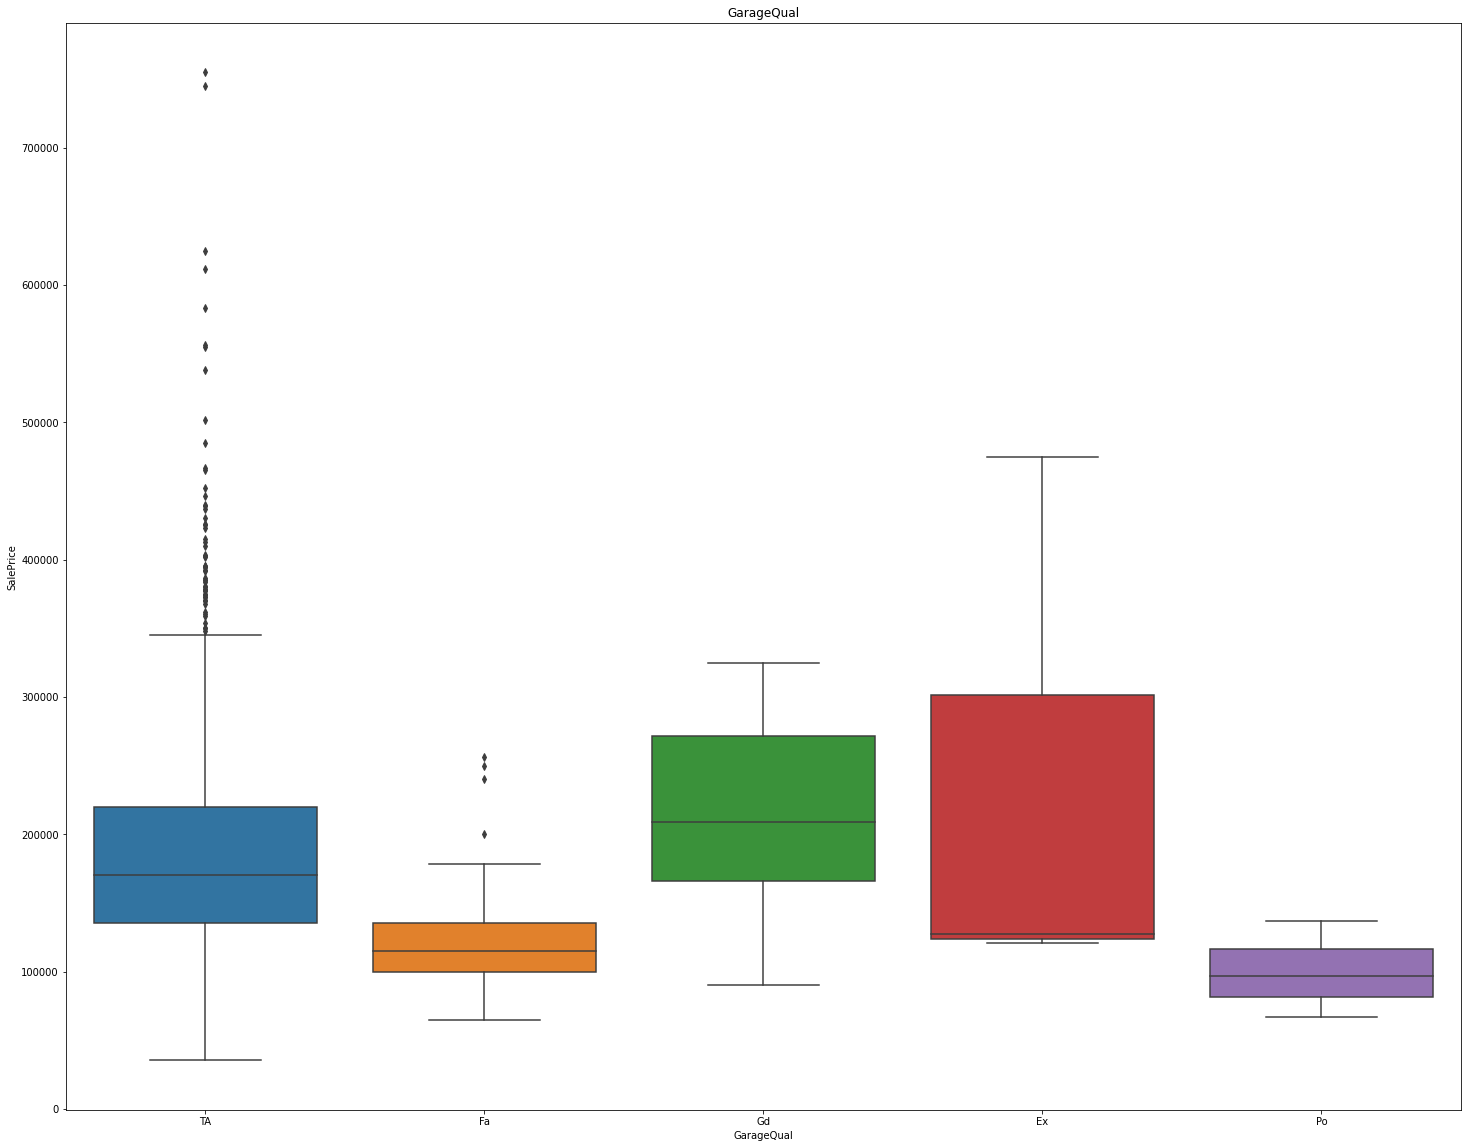

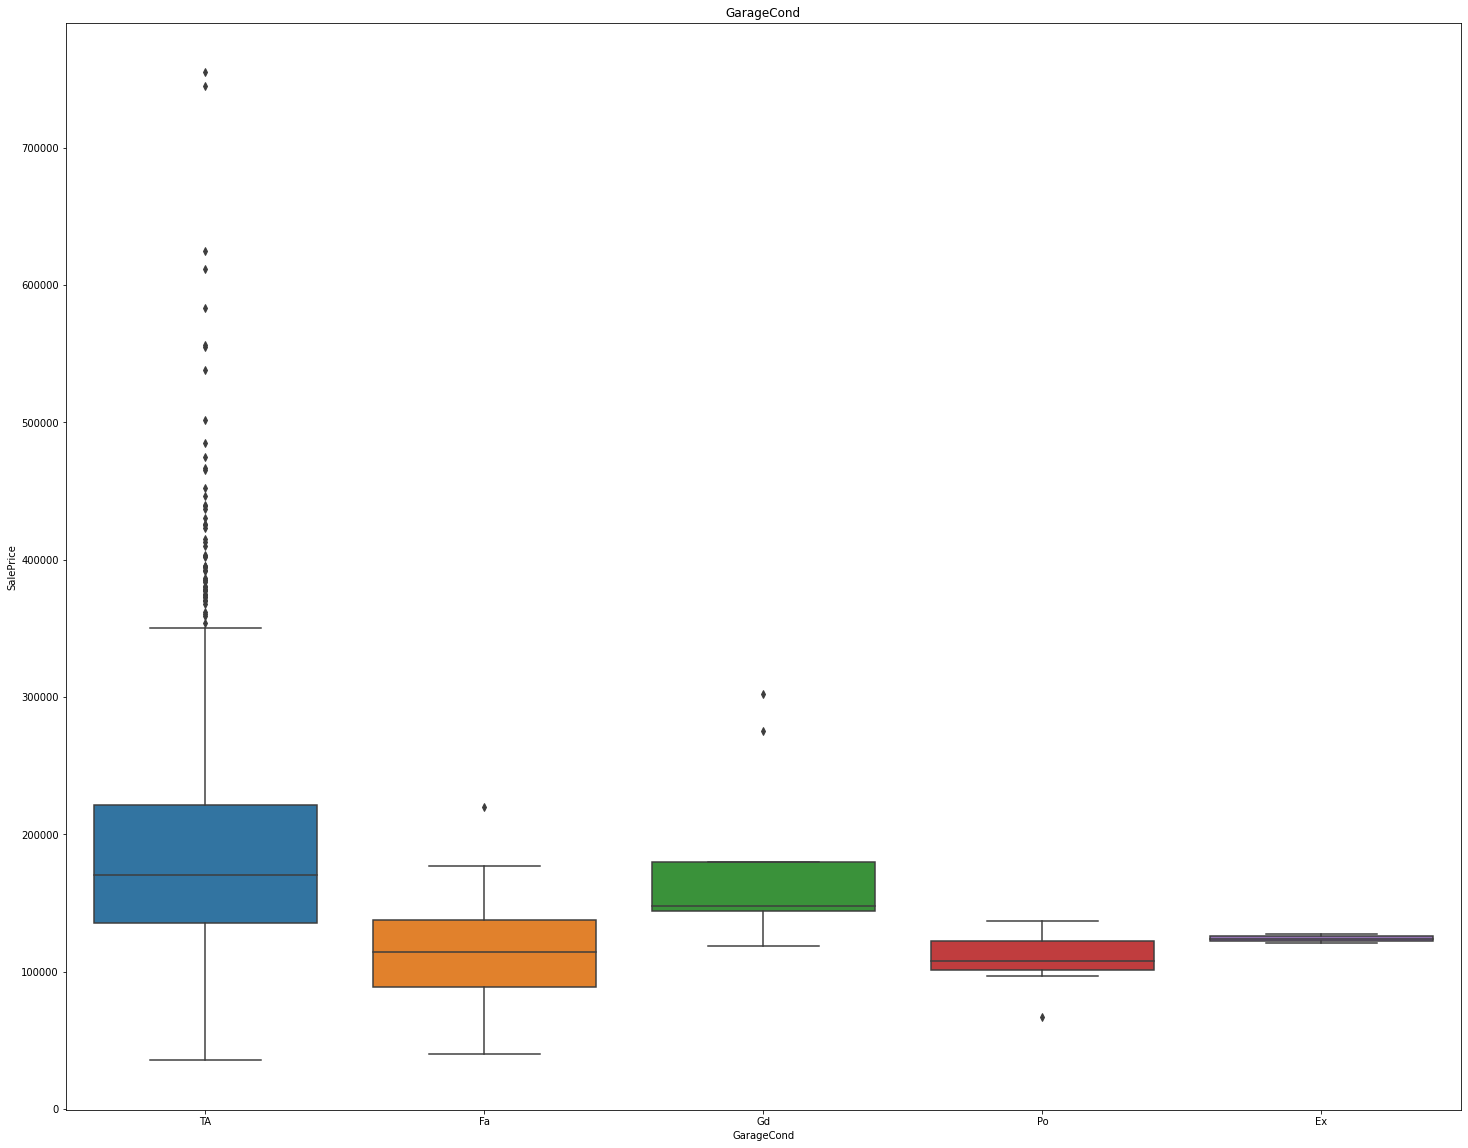

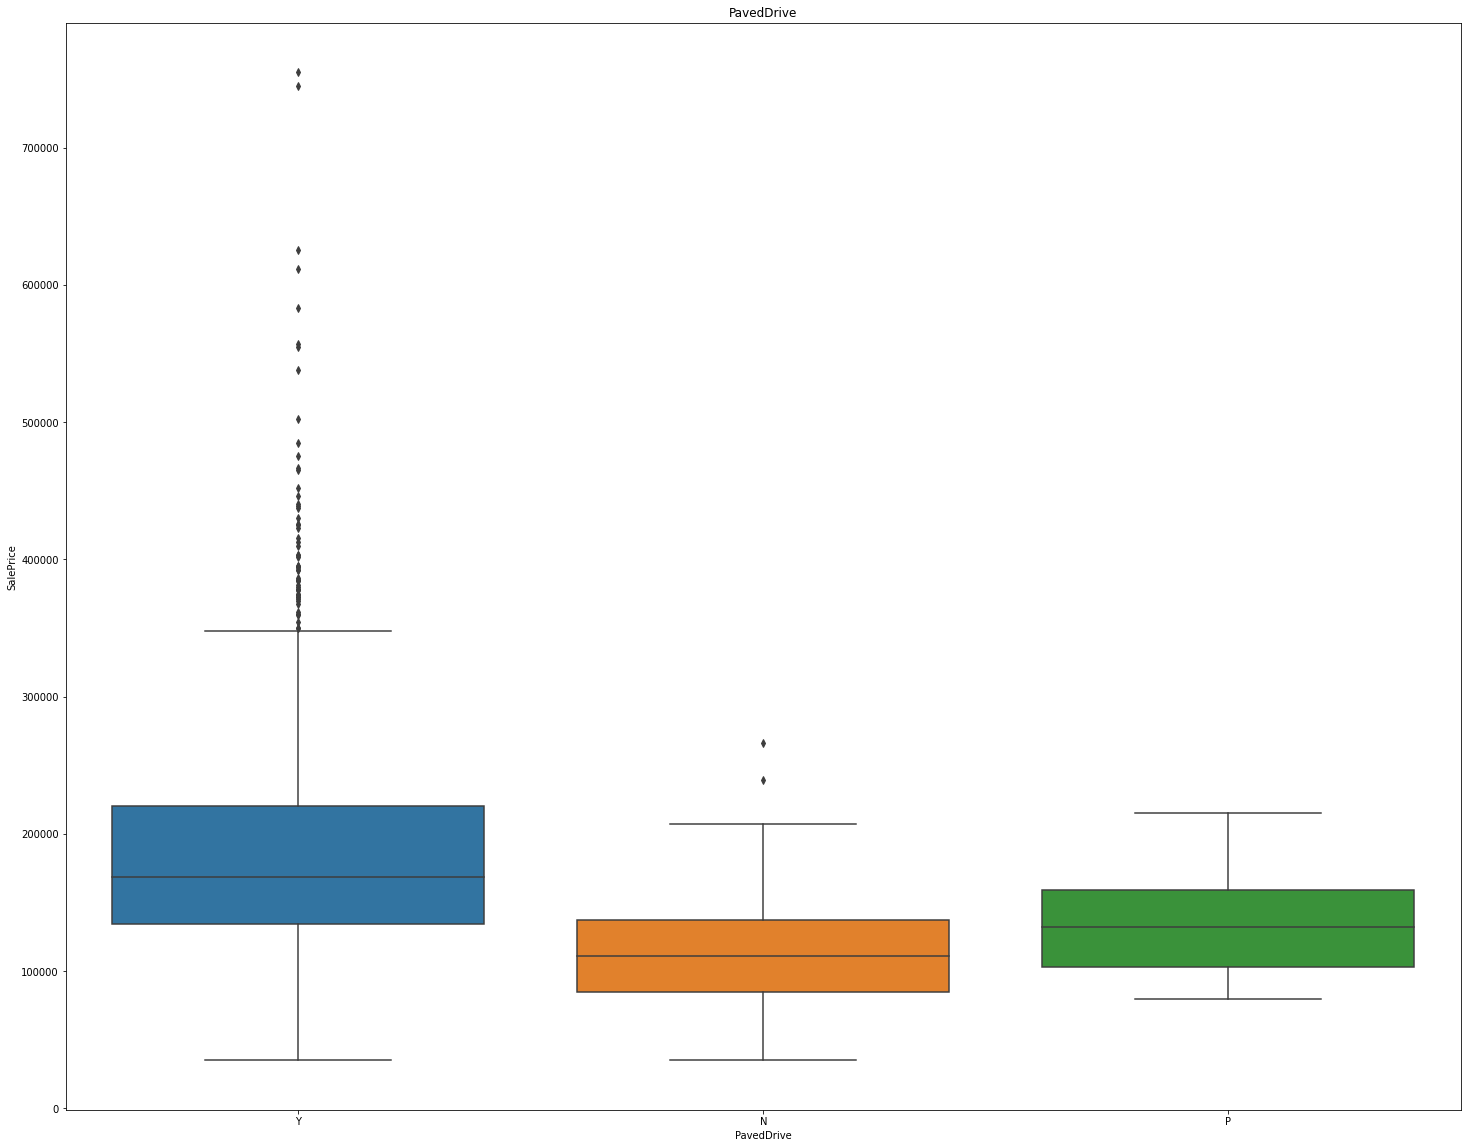

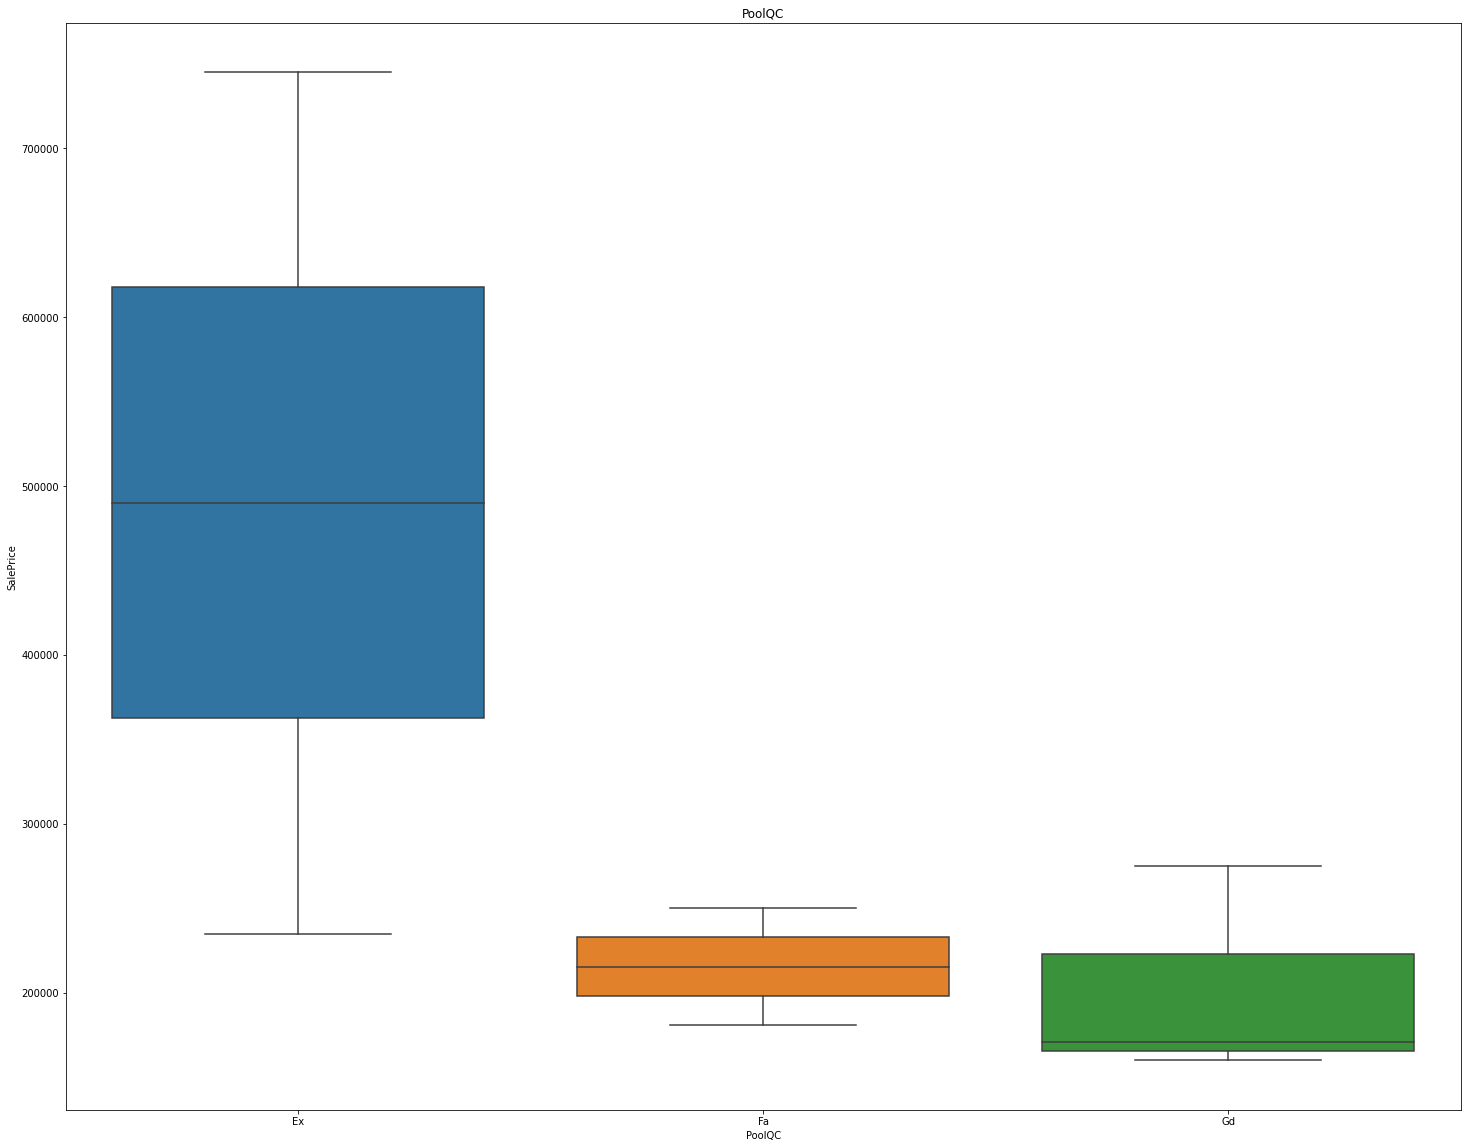

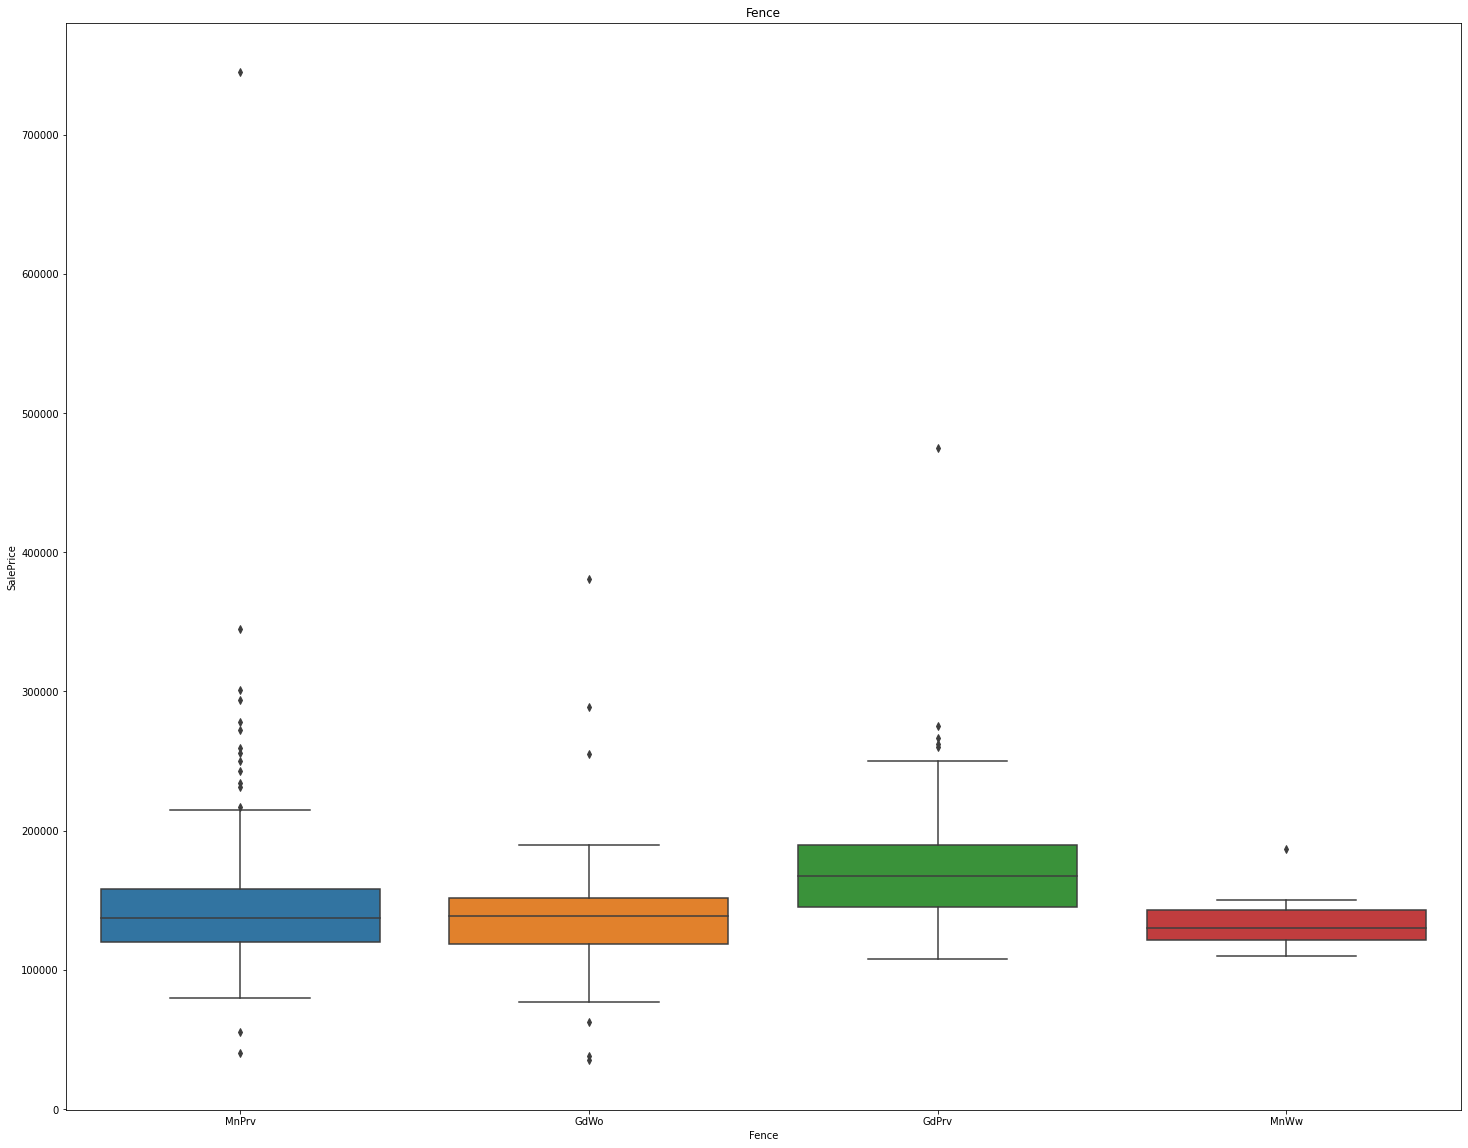

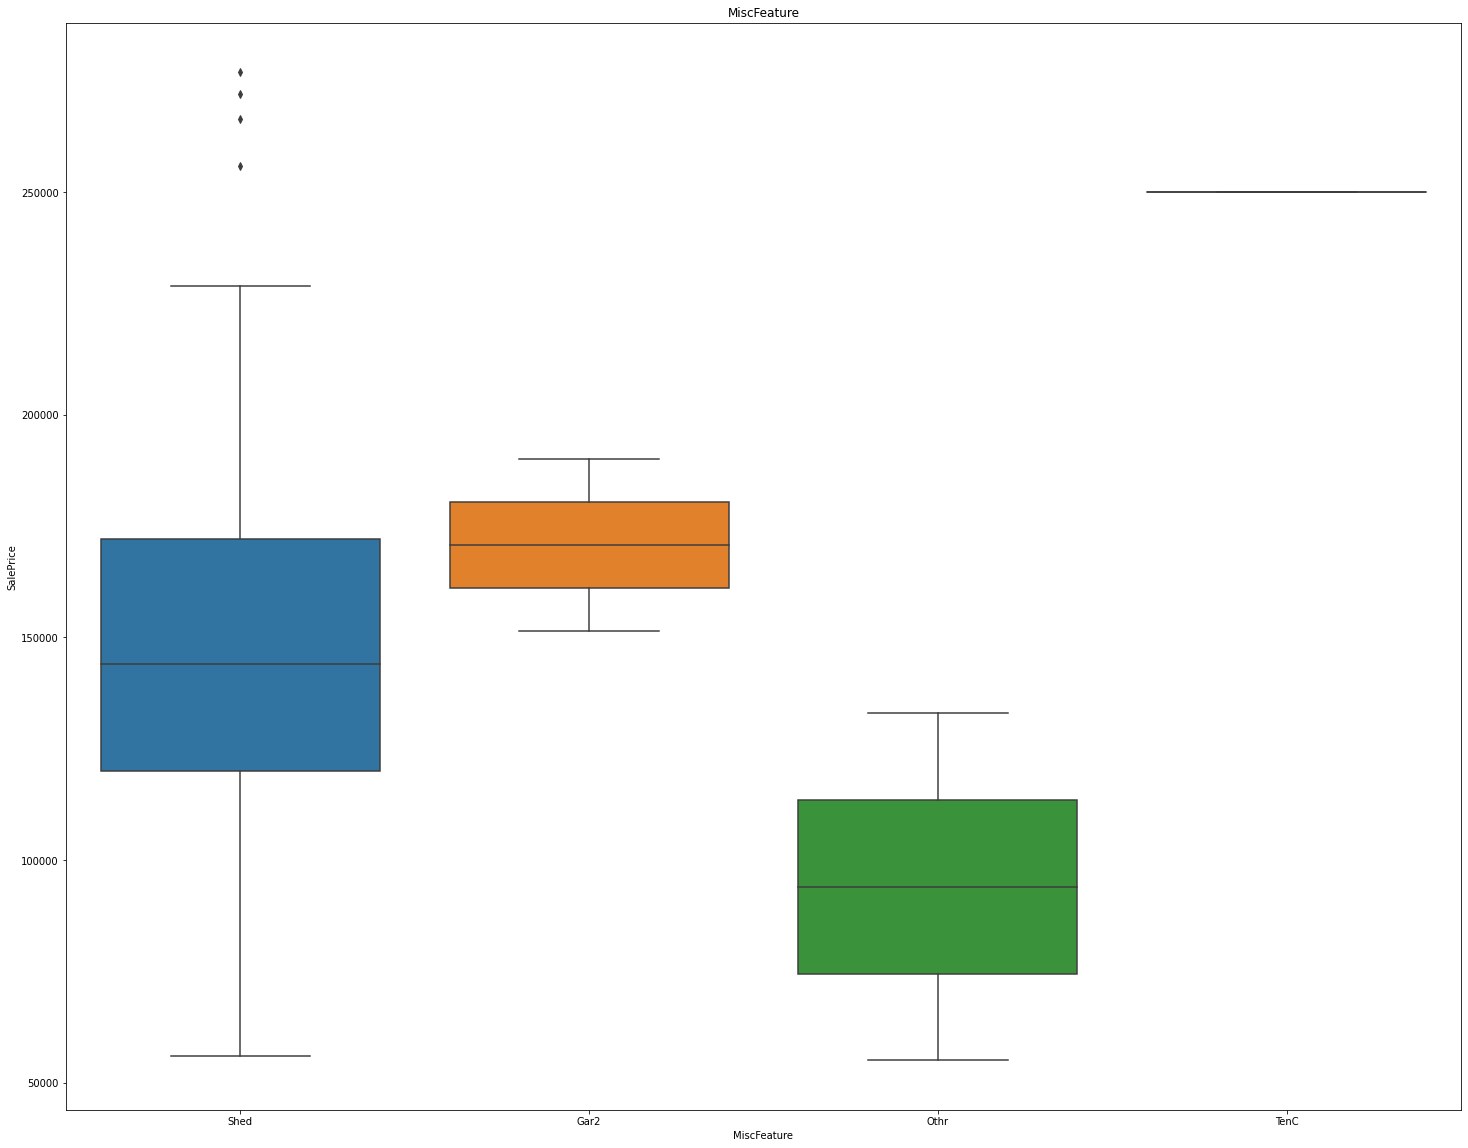

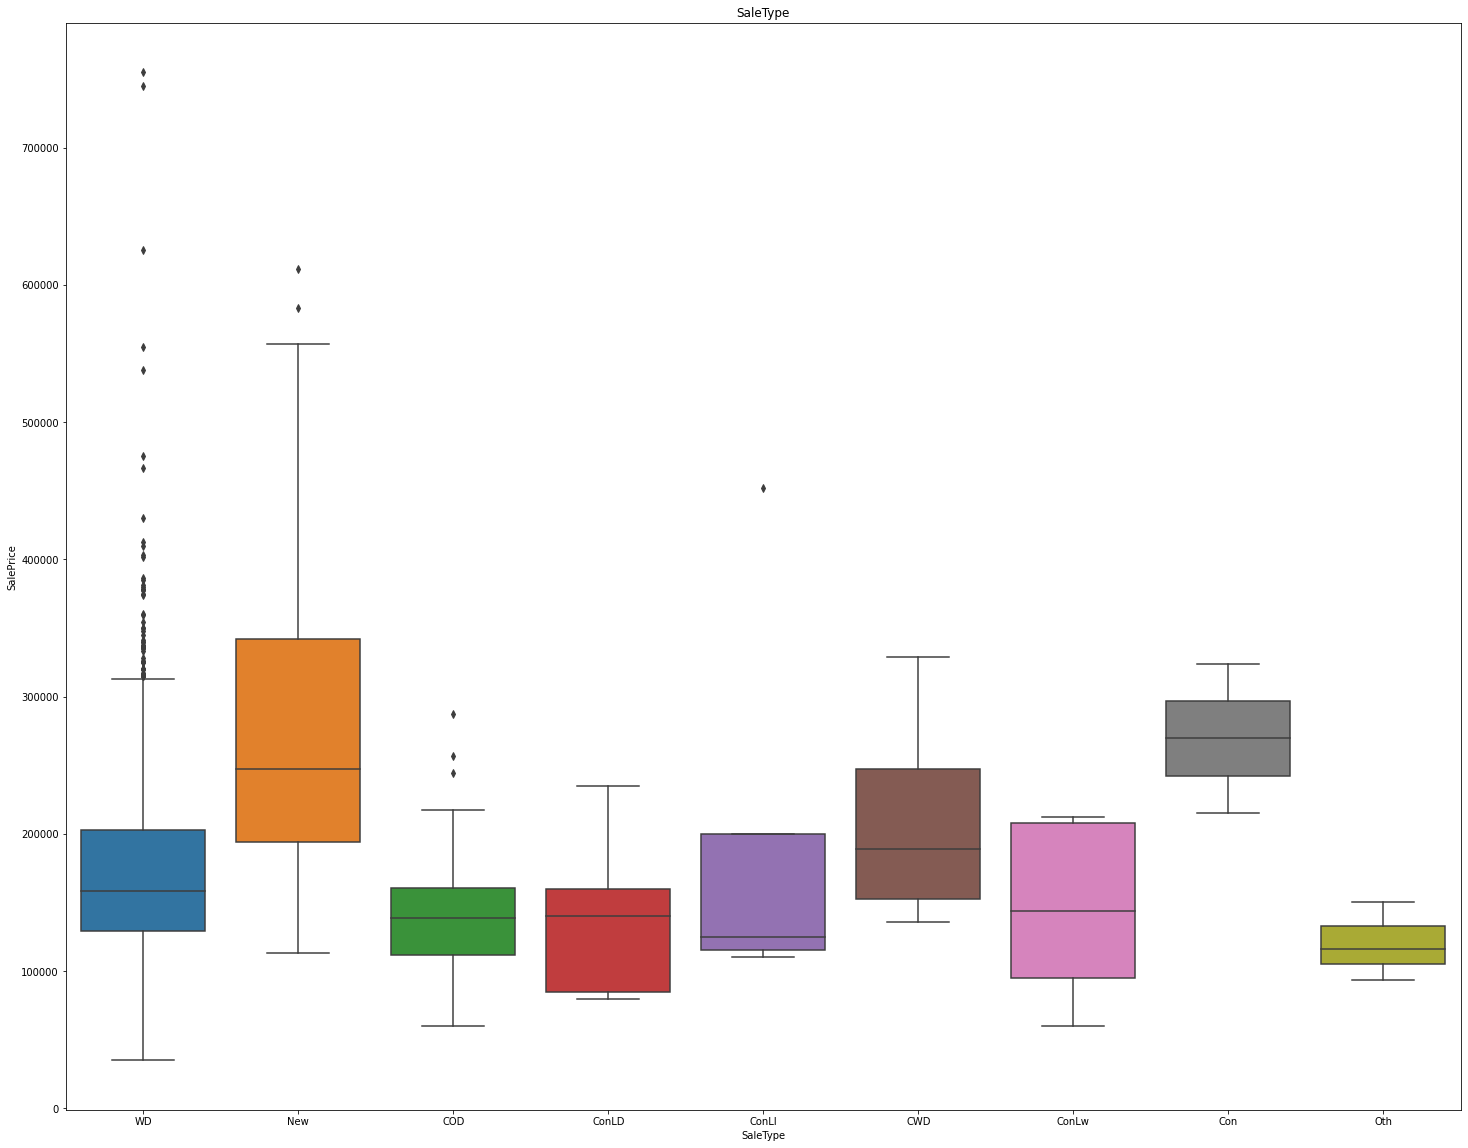

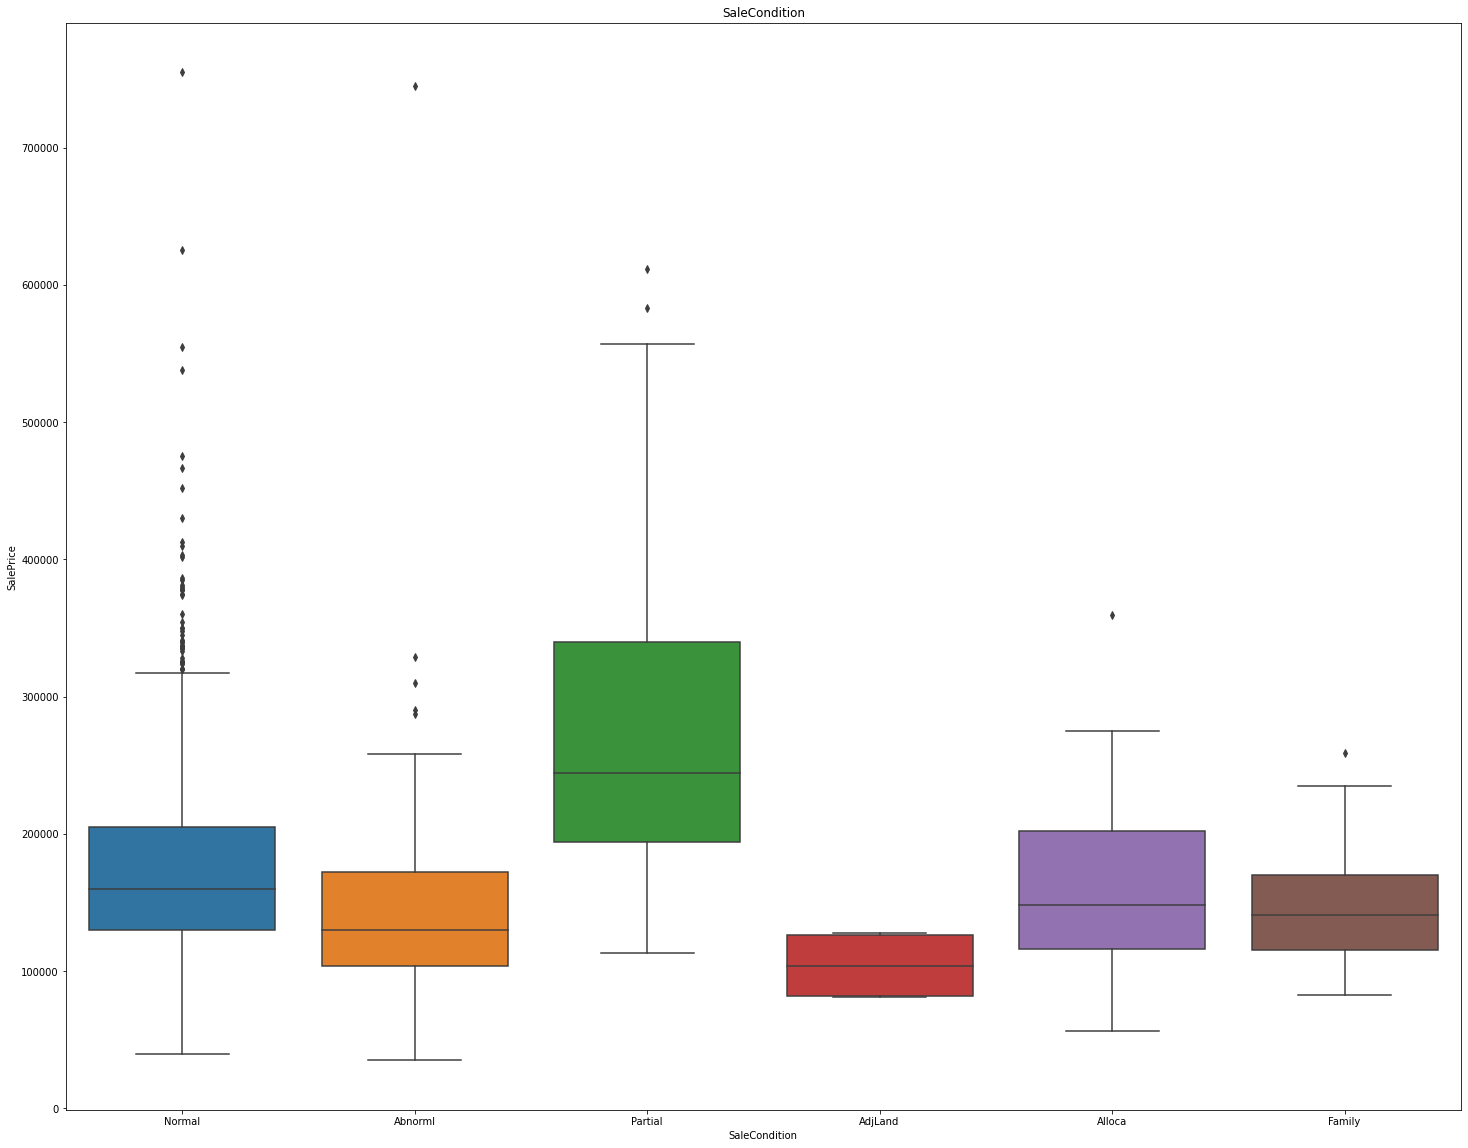

In [14]:
for column in categoric_train_data.columns[:-1]:
    plt.figure(figsize=(25,20))
    sns.boxplot(x=categoric_train_data[column], y=categoric_train_data['SalePrice'])
    plt.title(column)

In [15]:
categoric_train_data.columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition', 'SalePrice'],
      dtype='object')

Select the variables with more variation

In [16]:
categoric_selected = ['MSZoning',
                      'Neighborhood',
                      'Condition1',
                      'Condition2',
                      'HouseStyle',
                      'RoofMatl',
                      'ExterQual',
                      'BsmtQual',
                      'BsmtCond',
                      'CentralAir',
                      'KitchenQual',
                      'GarageType',
                      'SaleType']

Fill NA as a New Category

In [17]:
selected_categoric_train_data = categoric_train_data[categoric_selected]
new_selected_categoric_test_data = test_data[categoric_selected]

selected_categoric_train_data['BsmtQual'] = selected_categoric_train_data.BsmtQual.fillna('Wo')
selected_categoric_train_data['BsmtCond'] = selected_categoric_train_data.BsmtCond.fillna('Wo')
selected_categoric_train_data['GarageType'] = selected_categoric_train_data.GarageType.fillna('Wo')
selected_categoric_train_data.info()

new_selected_categoric_test_data['BsmtQual'] = new_selected_categoric_test_data.BsmtQual.fillna('Wo')
new_selected_categoric_test_data['BsmtCond'] = new_selected_categoric_test_data.BsmtCond.fillna('Wo')
new_selected_categoric_test_data['GarageType'] = new_selected_categoric_test_data.GarageType.fillna('Wo')
new_selected_categoric_test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   MSZoning      1460 non-null   object
 1   Neighborhood  1460 non-null   object
 2   Condition1    1460 non-null   object
 3   Condition2    1460 non-null   object
 4   HouseStyle    1460 non-null   object
 5   RoofMatl      1460 non-null   object
 6   ExterQual     1460 non-null   object
 7   BsmtQual      1460 non-null   object
 8   BsmtCond      1460 non-null   object
 9   CentralAir    1460 non-null   object
 10  KitchenQual   1460 non-null   object
 11  GarageType    1460 non-null   object
 12  SaleType      1460 non-null   object
dtypes: object(13)
memory usage: 148.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   MSZoning      1455 non-n

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

In [18]:
categoric_imputer = SimpleImputer(strategy='most_frequent')
selected_categoric_test_data = pd.DataFrame(categoric_imputer.fit_transform(new_selected_categoric_test_data))
selected_categoric_test_data.columns = new_selected_categoric_test_data.columns
selected_categoric_test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   MSZoning      1459 non-null   object
 1   Neighborhood  1459 non-null   object
 2   Condition1    1459 non-null   object
 3   Condition2    1459 non-null   object
 4   HouseStyle    1459 non-null   object
 5   RoofMatl      1459 non-null   object
 6   ExterQual     1459 non-null   object
 7   BsmtQual      1459 non-null   object
 8   BsmtCond      1459 non-null   object
 9   CentralAir    1459 non-null   object
 10  KitchenQual   1459 non-null   object
 11  GarageType    1459 non-null   object
 12  SaleType      1459 non-null   object
dtypes: object(13)
memory usage: 148.3+ KB


In [19]:
modified_categoric_train_data = selected_categoric_train_data.copy()
modified_categoric_test_data = selected_categoric_test_data.copy()

## Recategorization

For each selected variable, we recategorize its categories for similarity in relation with 'SalePrice'

Text(0.5, 1.0, 'MSZoning')

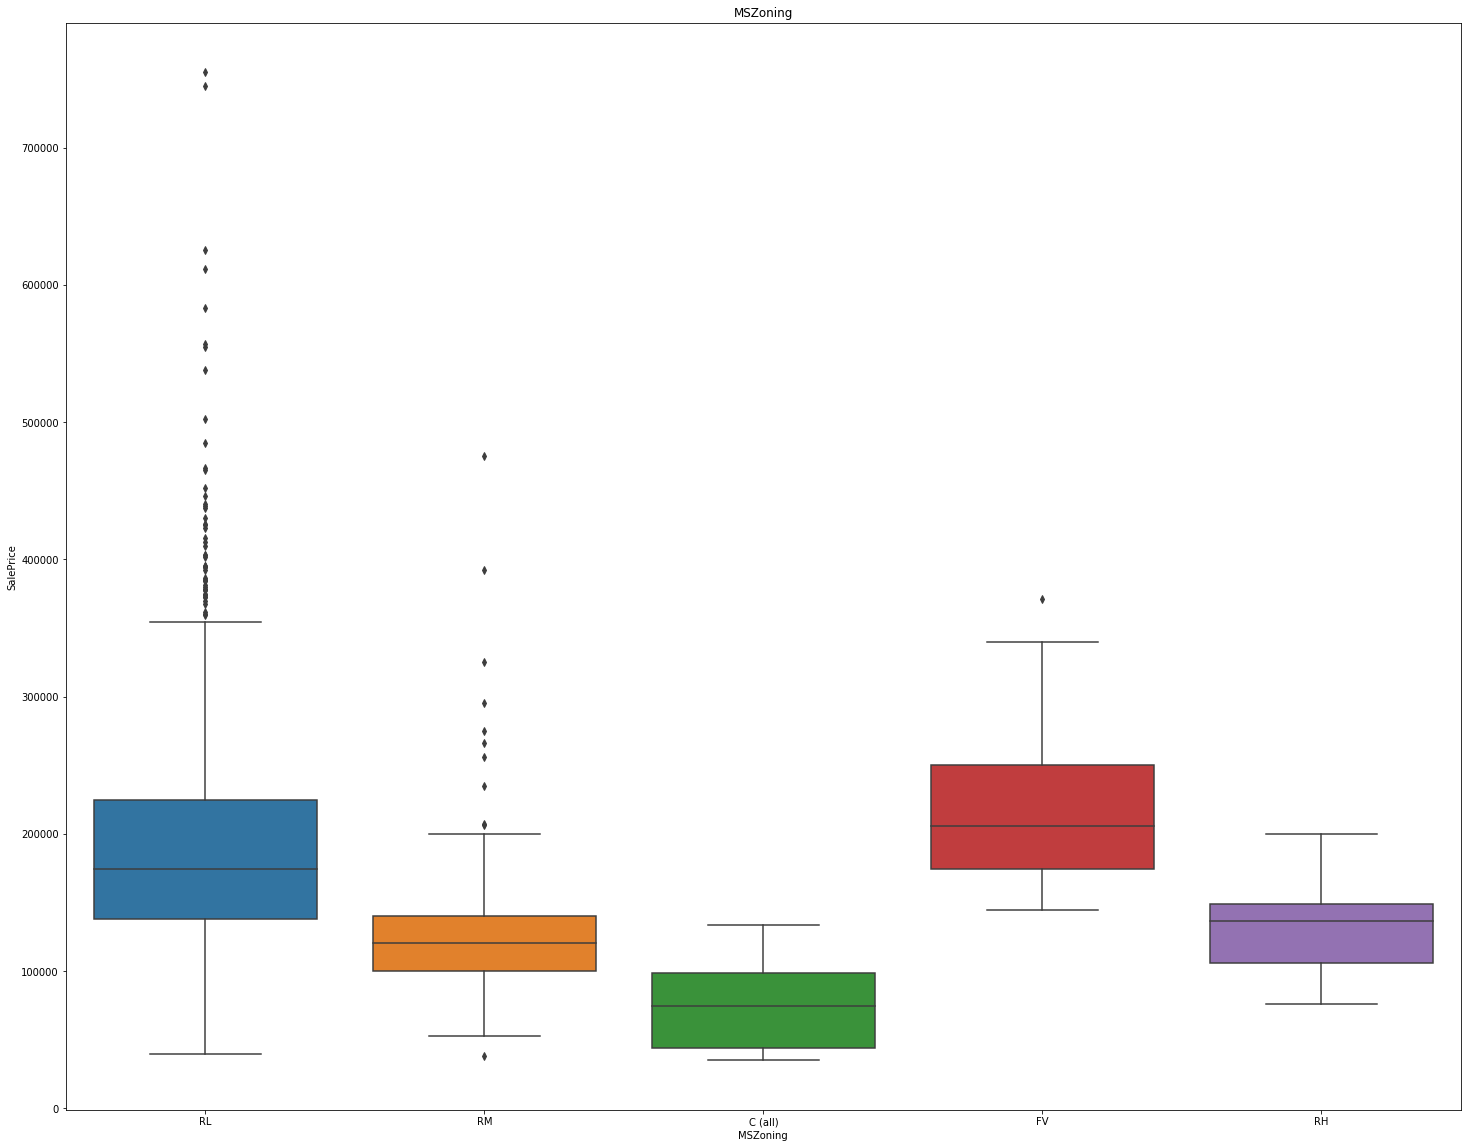

In [20]:
plt.figure(figsize=(25,20))
sns.boxplot(x=selected_categoric_train_data['MSZoning'], y=categoric_train_data['SalePrice'])
plt.title('MSZoning')

Text(0.5, 1.0, 'MSZoning')

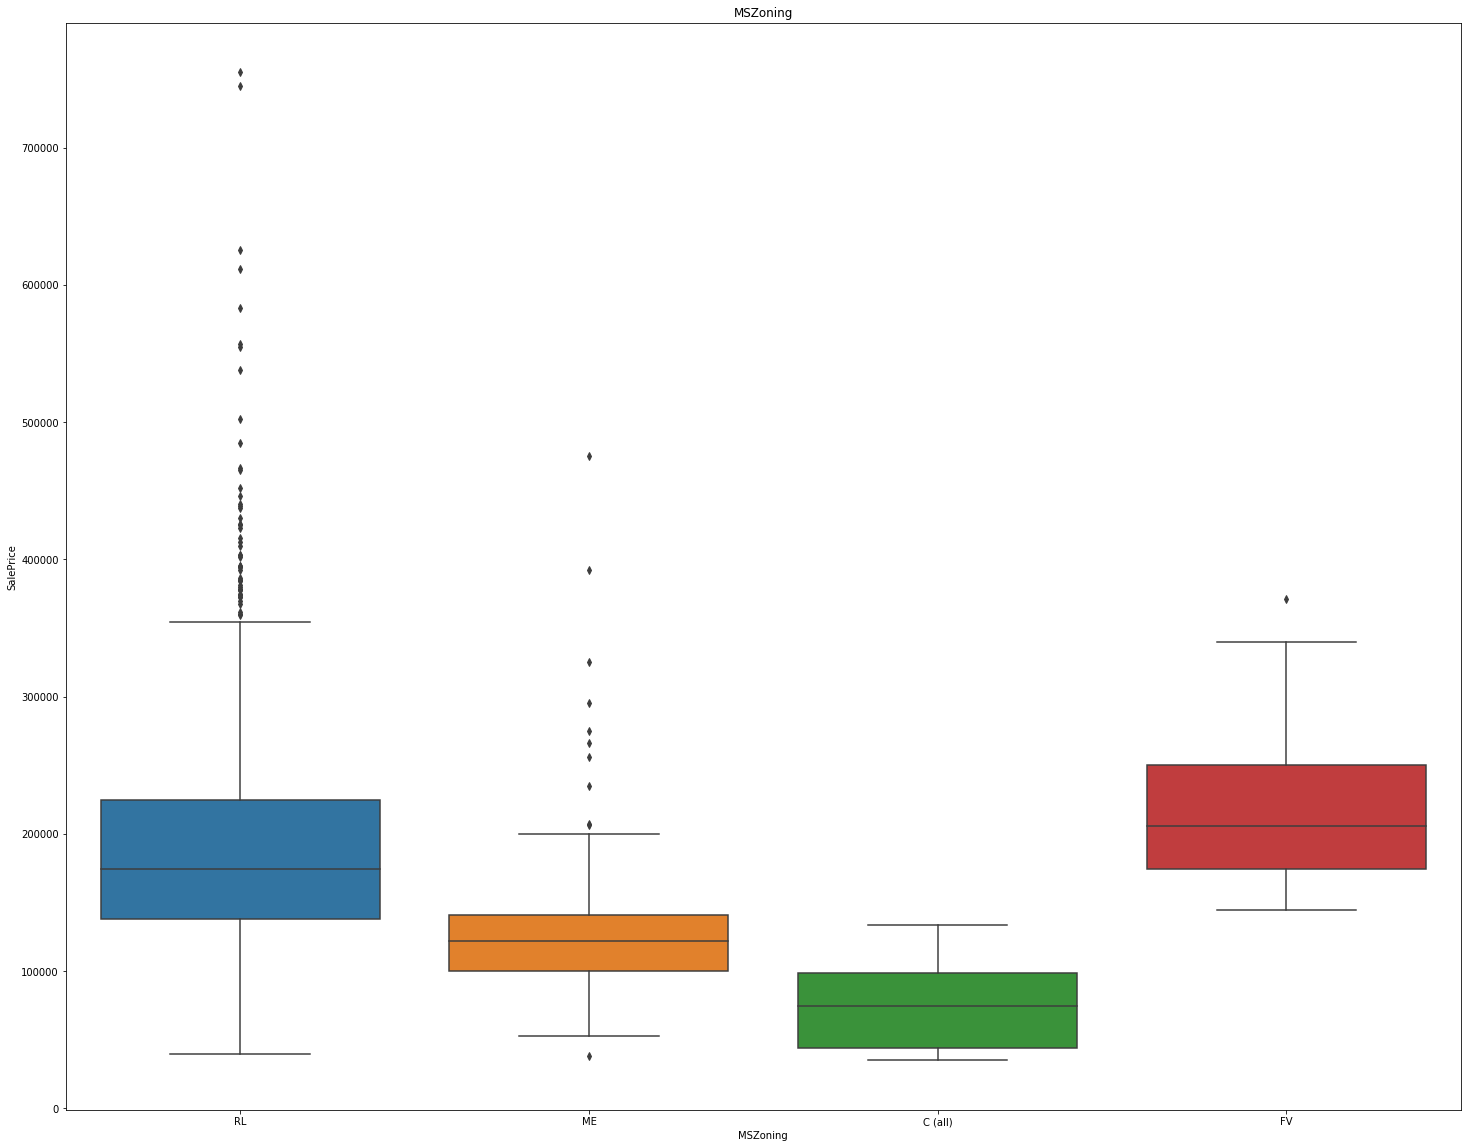

In [21]:
new_values ={'RM':'ME', 'RH':'ME'}
modified_categoric_train_data['MSZoning'] = selected_categoric_train_data.MSZoning.replace(new_values)
modified_categoric_test_data['MSZoning'] = selected_categoric_test_data.MSZoning.replace(new_values)

plt.figure(figsize=(25,20))
sns.boxplot(x=modified_categoric_train_data['MSZoning'], y=categoric_train_data['SalePrice'])
plt.title('MSZoning')

Text(0.5, 1.0, 'Neighborhood')

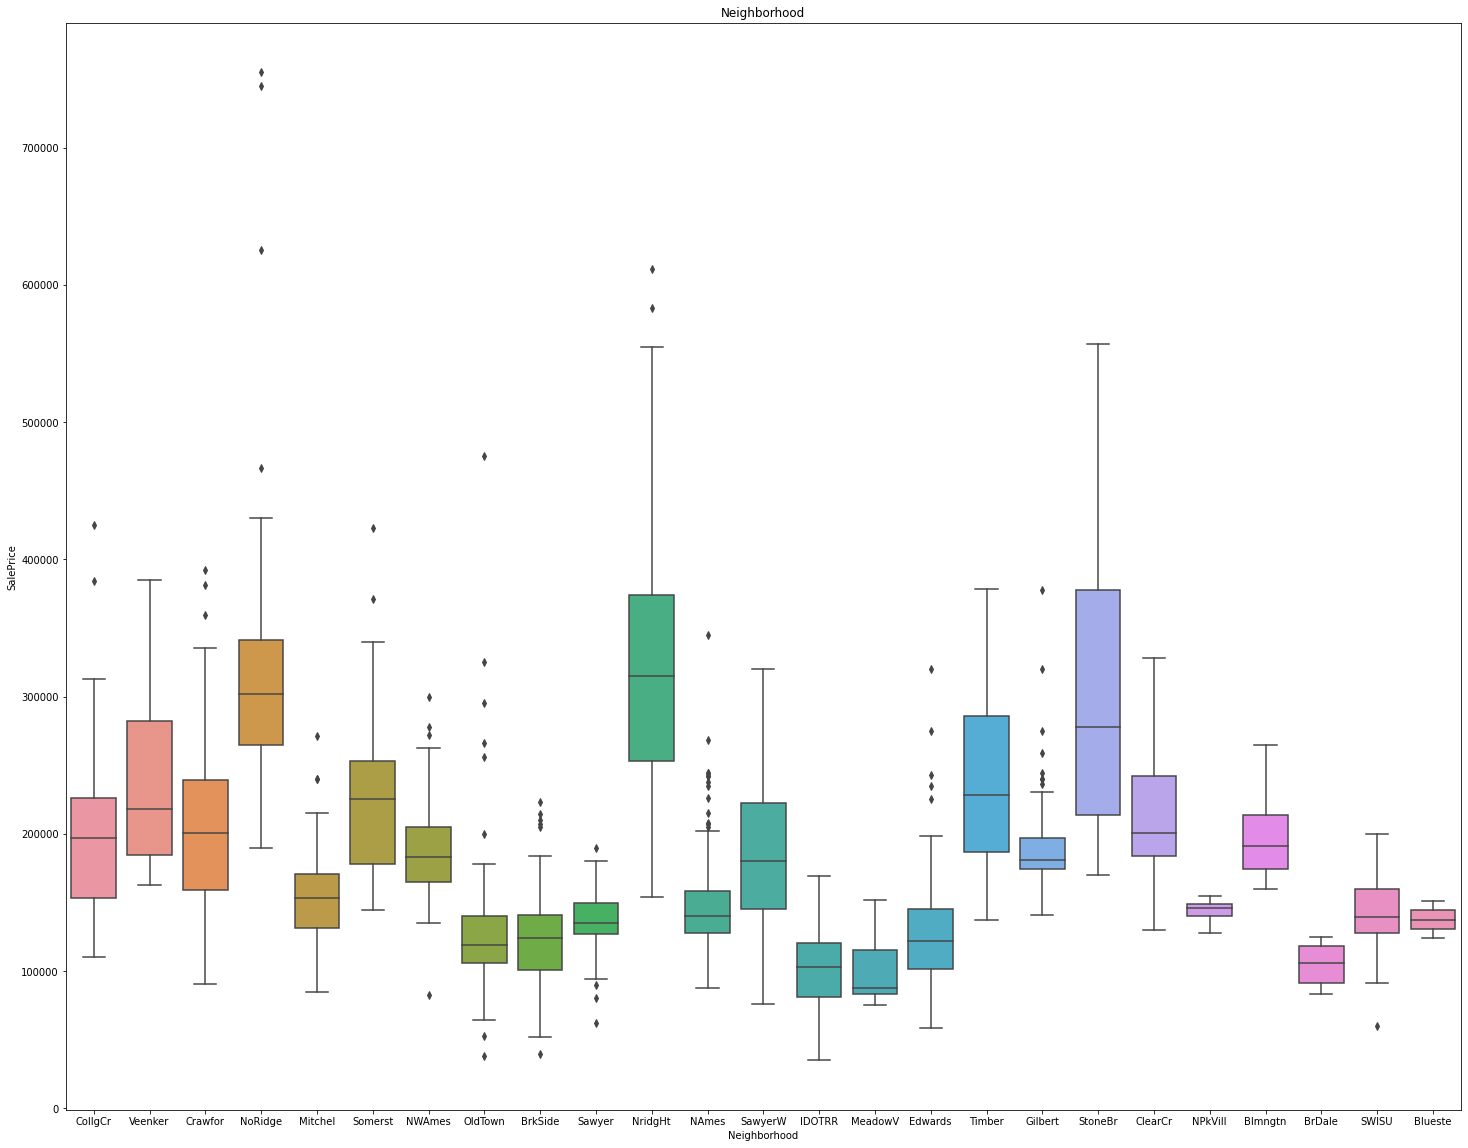

In [22]:
plt.figure(figsize=(25,20))
sns.boxplot(x=selected_categoric_train_data['Neighborhood'], y=categoric_train_data['SalePrice'])
plt.title('Neighborhood')

Text(0.5, 1.0, 'Neighborhood')

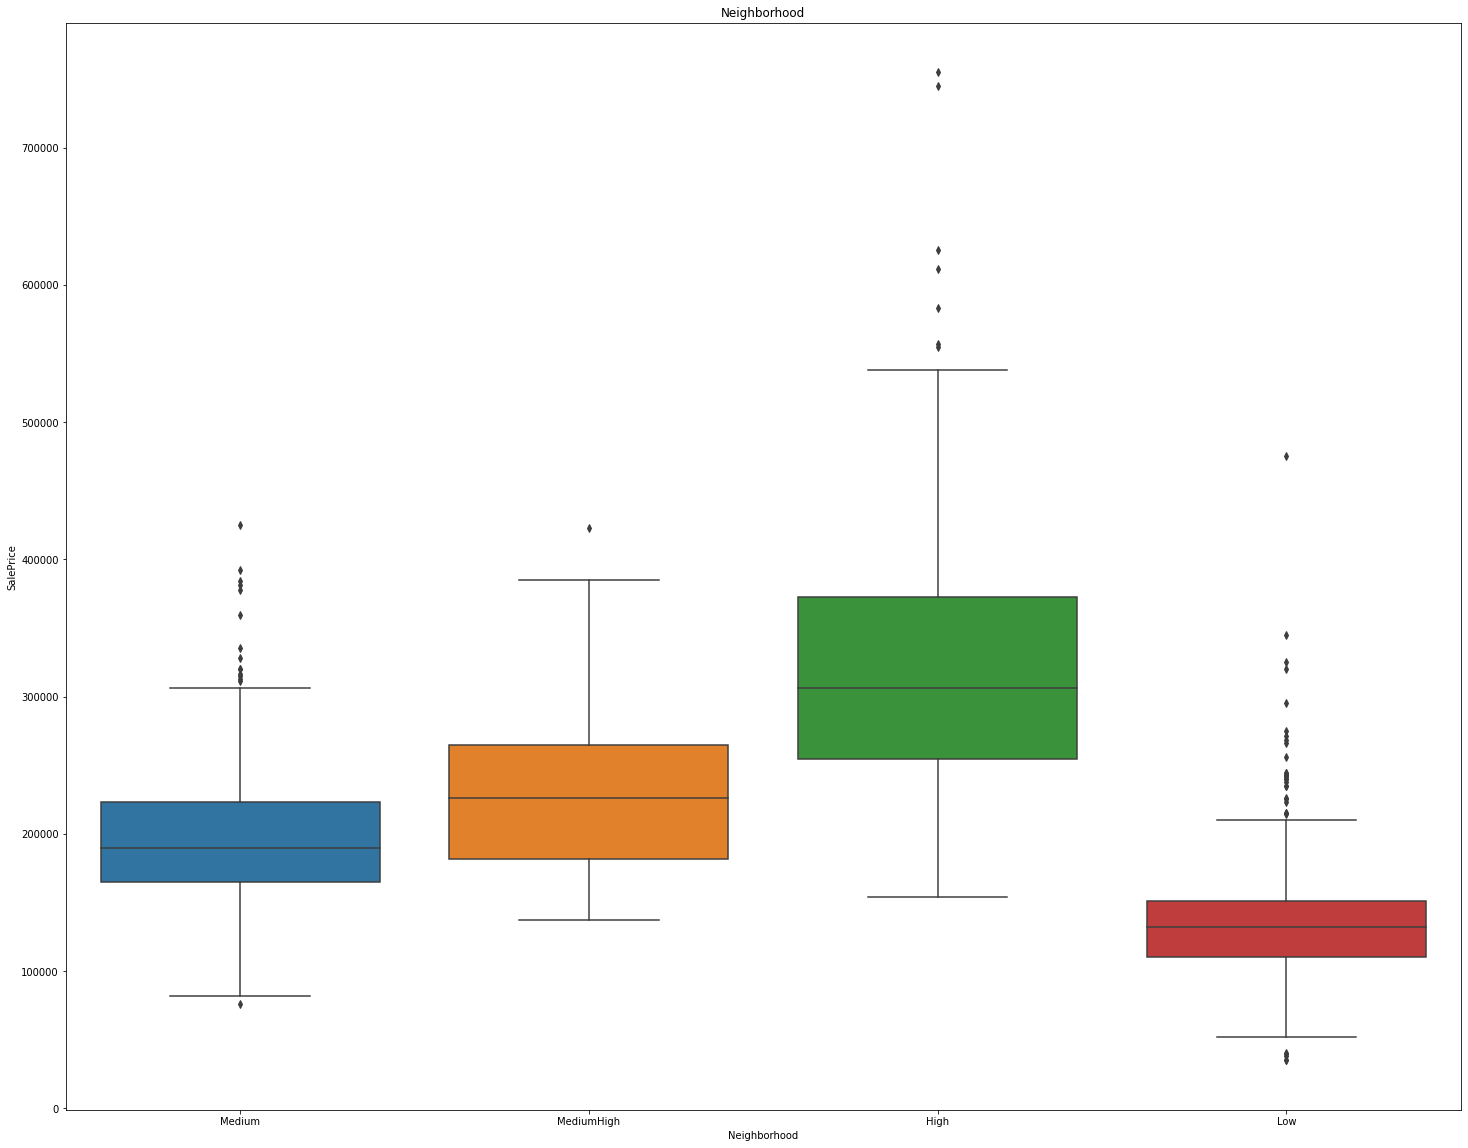

In [23]:
new_values ={'Blmngtn':'Medium',
       'Blueste':'Low',
       'BrDale':'Low',
       'BrkSide':'Low',
       'ClearCr':'Medium',
       'CollgCr':'Medium',
       'Crawfor':'Medium',
       'Edwards':'Low',
       'Gilbert':'Medium',
       'IDOTRR':'Low',
       'MeadowV':'Low',
       'Mitchel':'Low',
       'NAmes':'Low',
       'NoRidge':'High',
       'NPkVill':'Low',
       'NridgHt':'High',
       'NWAmes':'Medium',
       'OldTown':'Low',
       'SWISU':'Low',
       'Sawyer':'Low',
       'SawyerW':'Medium',
       'Somerst':'MediumHigh',
       'StoneBr':'High',
       'Timber':'MediumHigh',
       'Veenker':'MediumHigh',}
modified_categoric_train_data['Neighborhood'] = selected_categoric_train_data.Neighborhood.replace(new_values)
modified_categoric_test_data['Neighborhood'] = selected_categoric_test_data.Neighborhood.replace(new_values)

plt.figure(figsize=(25,20))
sns.boxplot(x=modified_categoric_train_data['Neighborhood'], y=categoric_train_data['SalePrice'])
plt.title('Neighborhood')

Text(0.5, 1.0, 'Condition1')

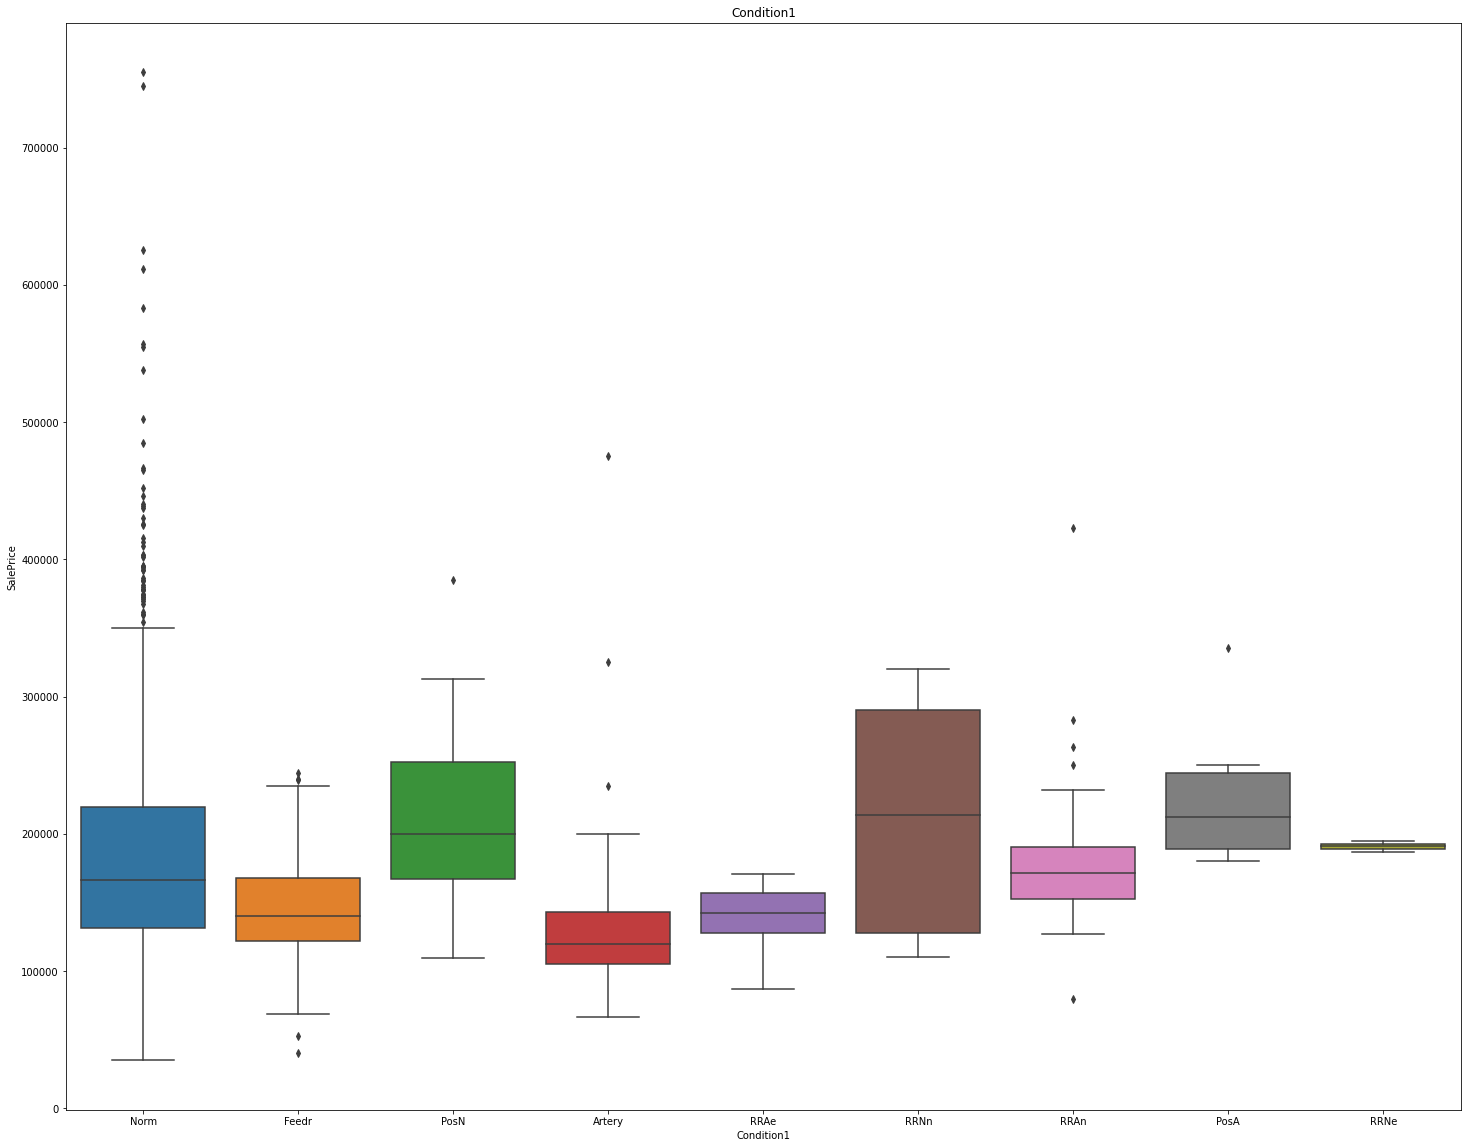

In [24]:
plt.figure(figsize=(25,20))
sns.boxplot(x=selected_categoric_train_data['Condition1'], y=categoric_train_data['SalePrice'])
plt.title('Condition1')

Text(0.5, 1.0, 'Condition1')

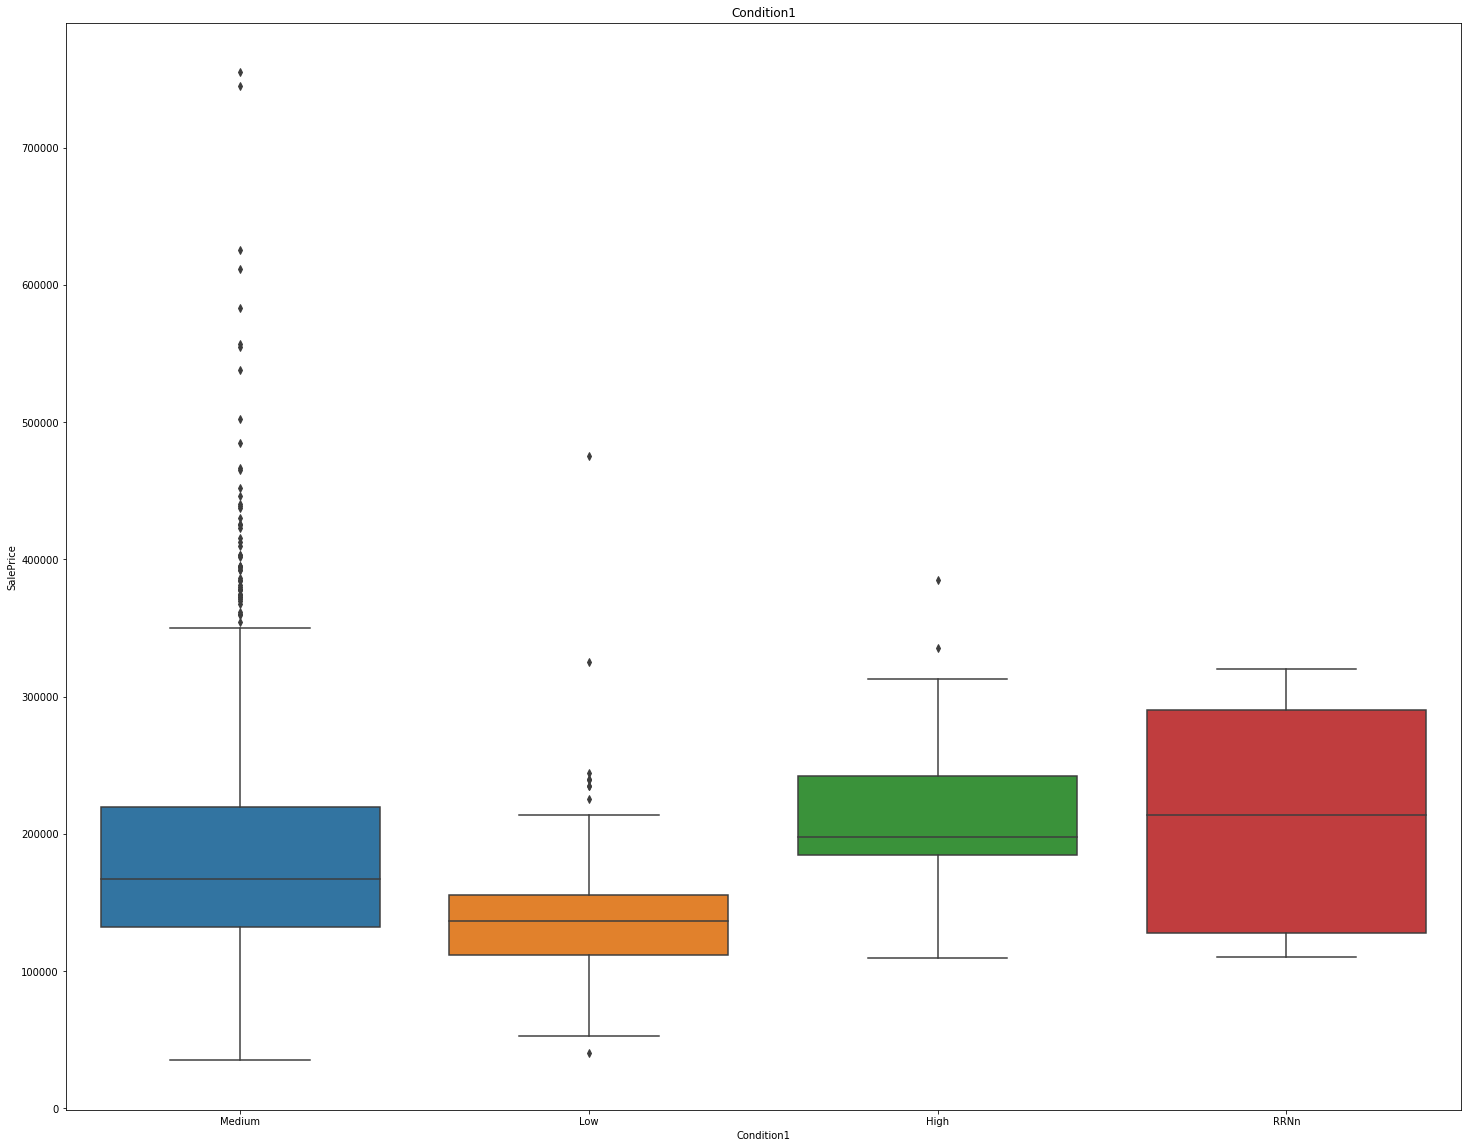

In [25]:
new_values ={
    'Artery':'Low',
    'Feedr':'Low',
    'Norm':'Medium',
    'RRAn':'Medium',
    'PosN':'High',
    'PosA':'High',
    'RRNe':'High',
    'RRAe':'Low'
}
modified_categoric_train_data['Condition1'] = selected_categoric_train_data.Condition1.replace(new_values)
modified_categoric_test_data['Condition1'] = selected_categoric_test_data.Condition1.replace(new_values)

plt.figure(figsize=(25,20))
sns.boxplot(x=modified_categoric_train_data['Condition1'], y=categoric_train_data['SalePrice'])
plt.title('Condition1')

Text(0.5, 1.0, 'Condition2')

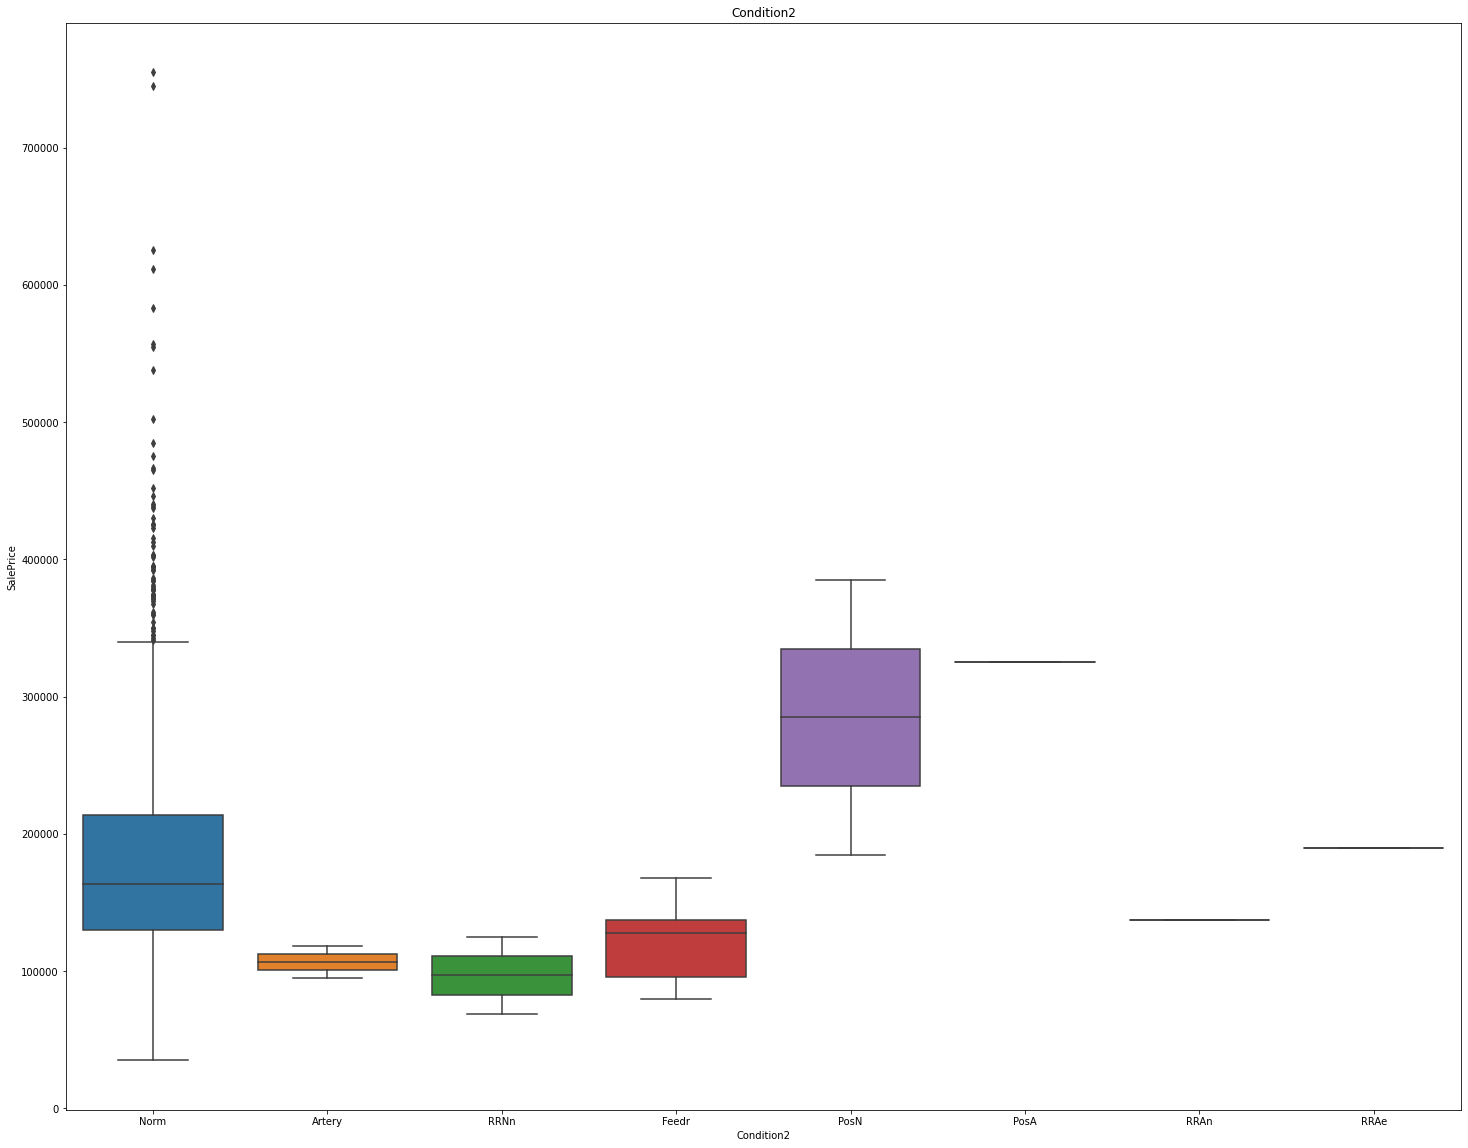

In [26]:
plt.figure(figsize=(25,20))
sns.boxplot(x=selected_categoric_train_data['Condition2'], y=categoric_train_data['SalePrice'])
plt.title('Condition2')

Text(0.5, 1.0, 'Condition2')

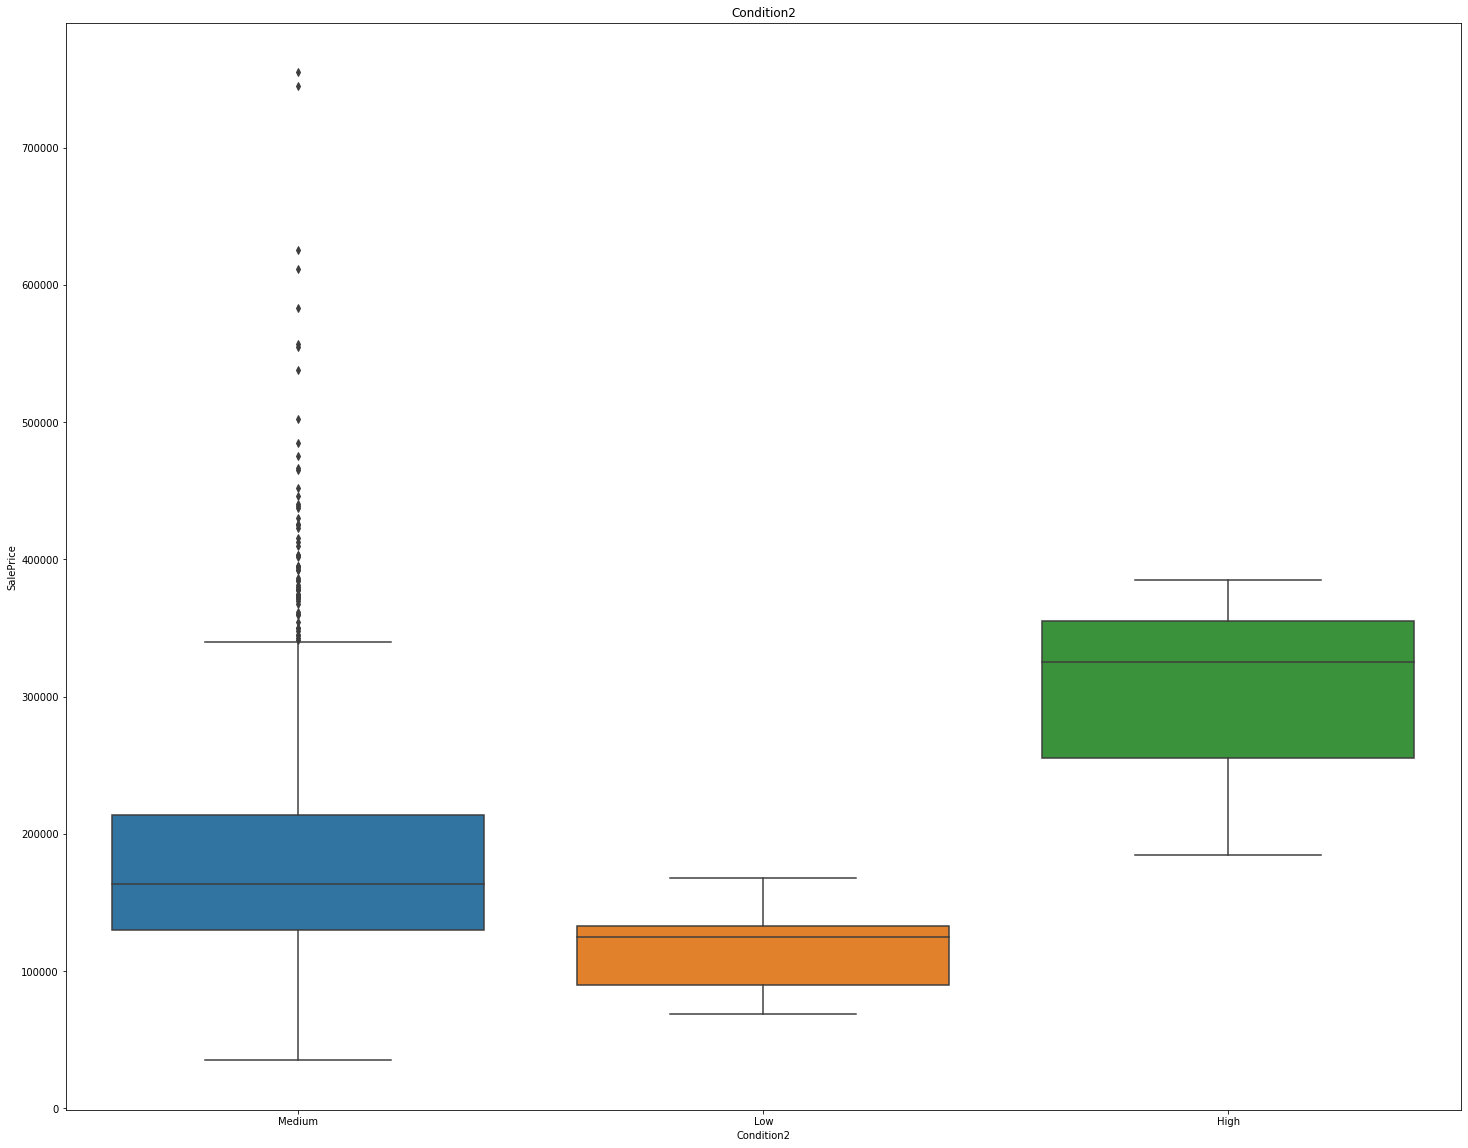

In [27]:
new_values ={
    'Artery':'Low',
    'Feedr':'Low',
    'Norm':'Medium',
    'RRNn':'Low',
    'RRAn':'Low',
    'PosN':'High',
    'PosA':'High',
    'RRNe':'High',
    'RRAe':'Medium'
}
modified_categoric_train_data['Condition2'] = selected_categoric_train_data.Condition2.replace(new_values)
modified_categoric_test_data['Condition2'] = selected_categoric_test_data.Condition2.replace(new_values)


plt.figure(figsize=(25,20))
sns.boxplot(x=modified_categoric_train_data['Condition2'], y=categoric_train_data['SalePrice'])
plt.title('Condition2')

Text(0.5, 1.0, 'HouseStyle')

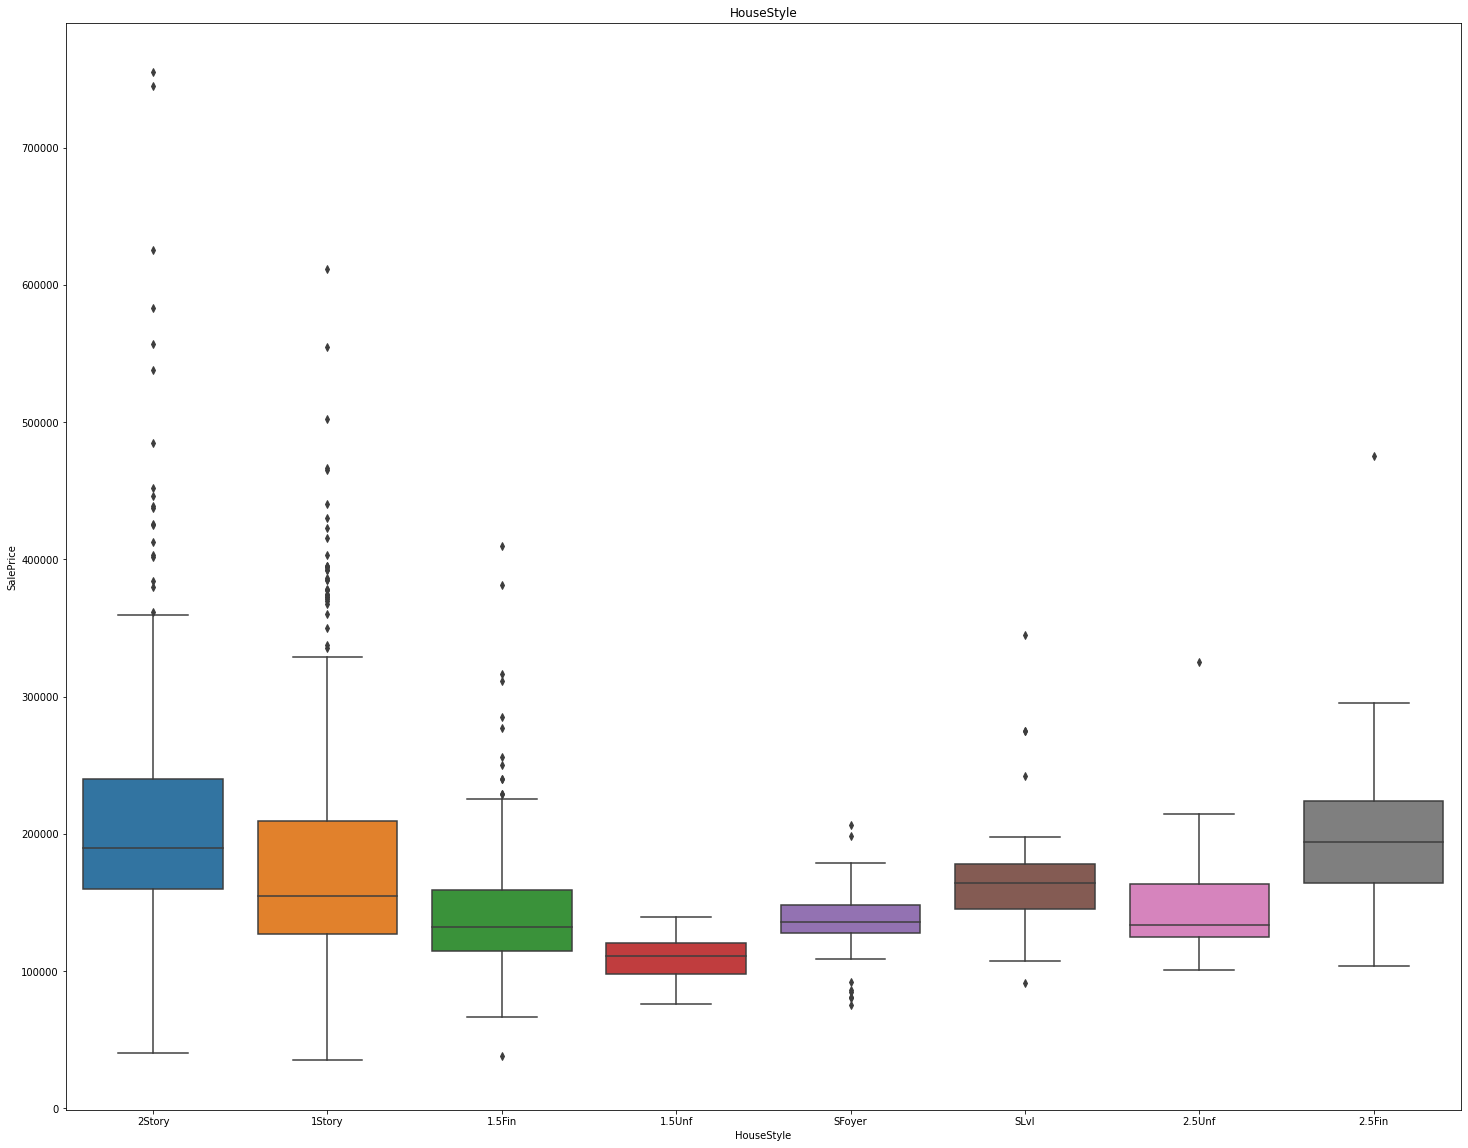

In [28]:
plt.figure(figsize=(25,20))
sns.boxplot(x=selected_categoric_train_data['HouseStyle'], y=categoric_train_data['SalePrice'])
plt.title('HouseStyle')

Text(0.5, 1.0, 'HouseStyle')

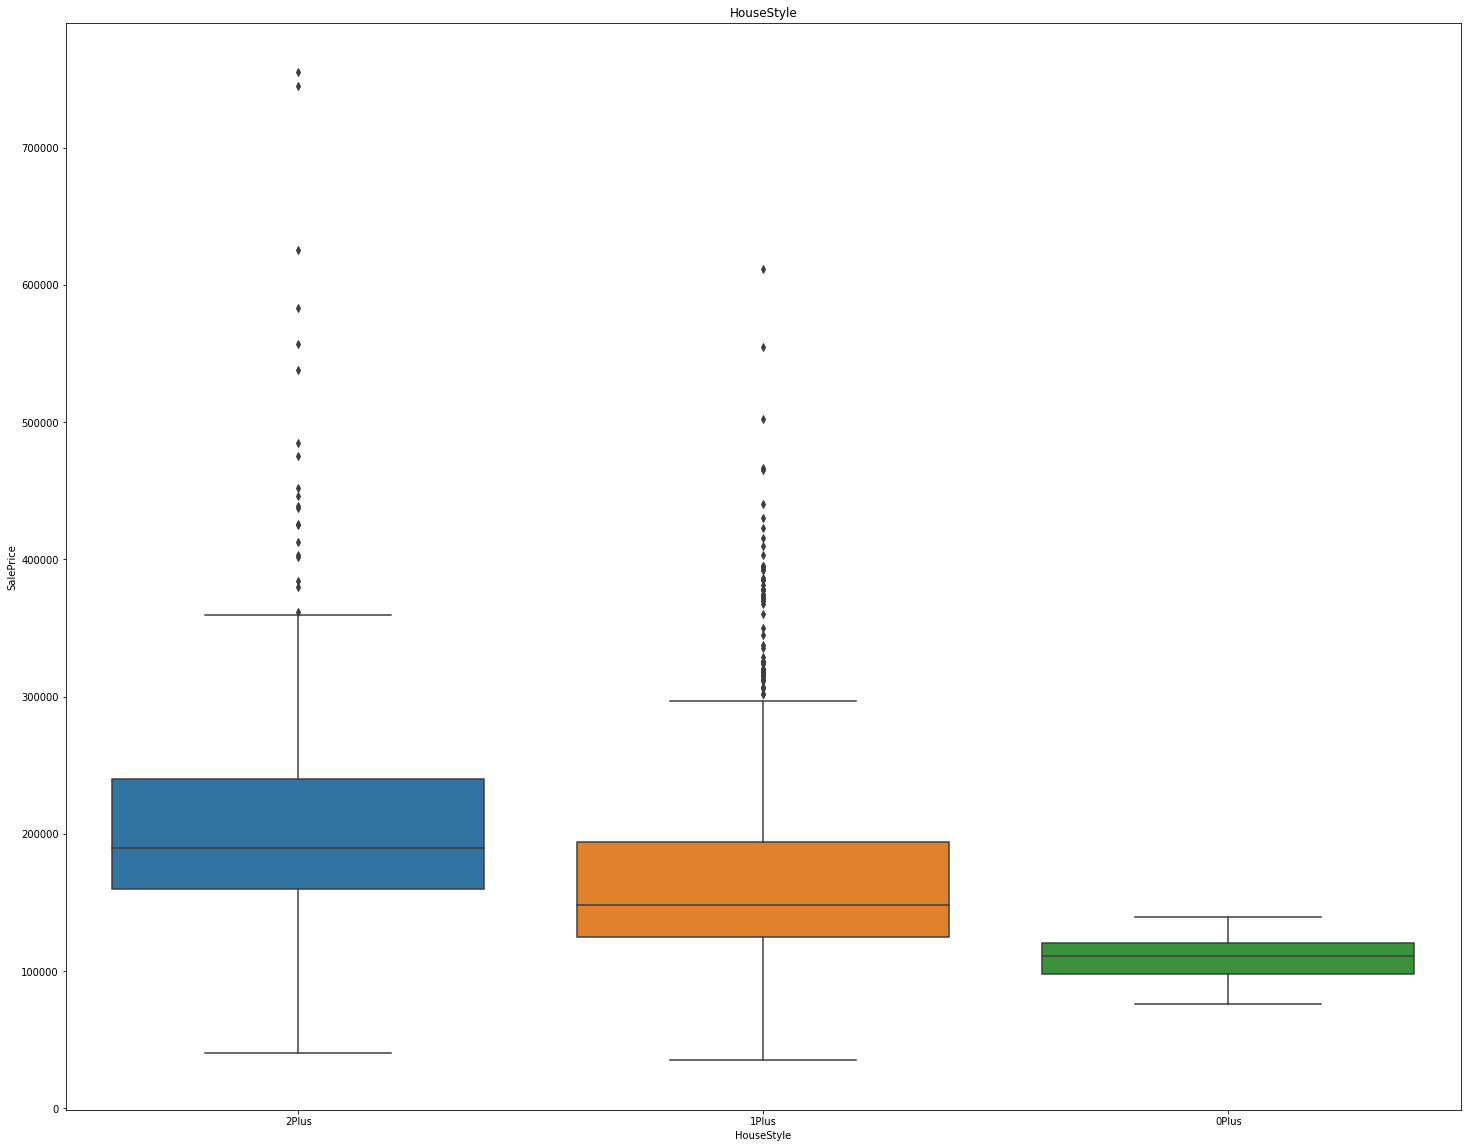

In [29]:
new_values ={
    '1Story':'1Plus',
    '1.5Fin':'1Plus',
    '1.5Unf':'0Plus',
    '2Story':'2Plus',
    '2.5Fin':'2Plus',
    '2.5Unf':'1Plus',
    'SFoyer':'1Plus',
    'SLvl':'1Plus'
}
modified_categoric_train_data['HouseStyle'] = selected_categoric_train_data.HouseStyle.replace(new_values)
modified_categoric_test_data['HouseStyle'] = selected_categoric_test_data.HouseStyle.replace(new_values)


plt.figure(figsize=(25,20))
sns.boxplot(x=modified_categoric_train_data['HouseStyle'], y=categoric_train_data['SalePrice'])
plt.title('HouseStyle')

Text(0.5, 1.0, 'RoofMatl')

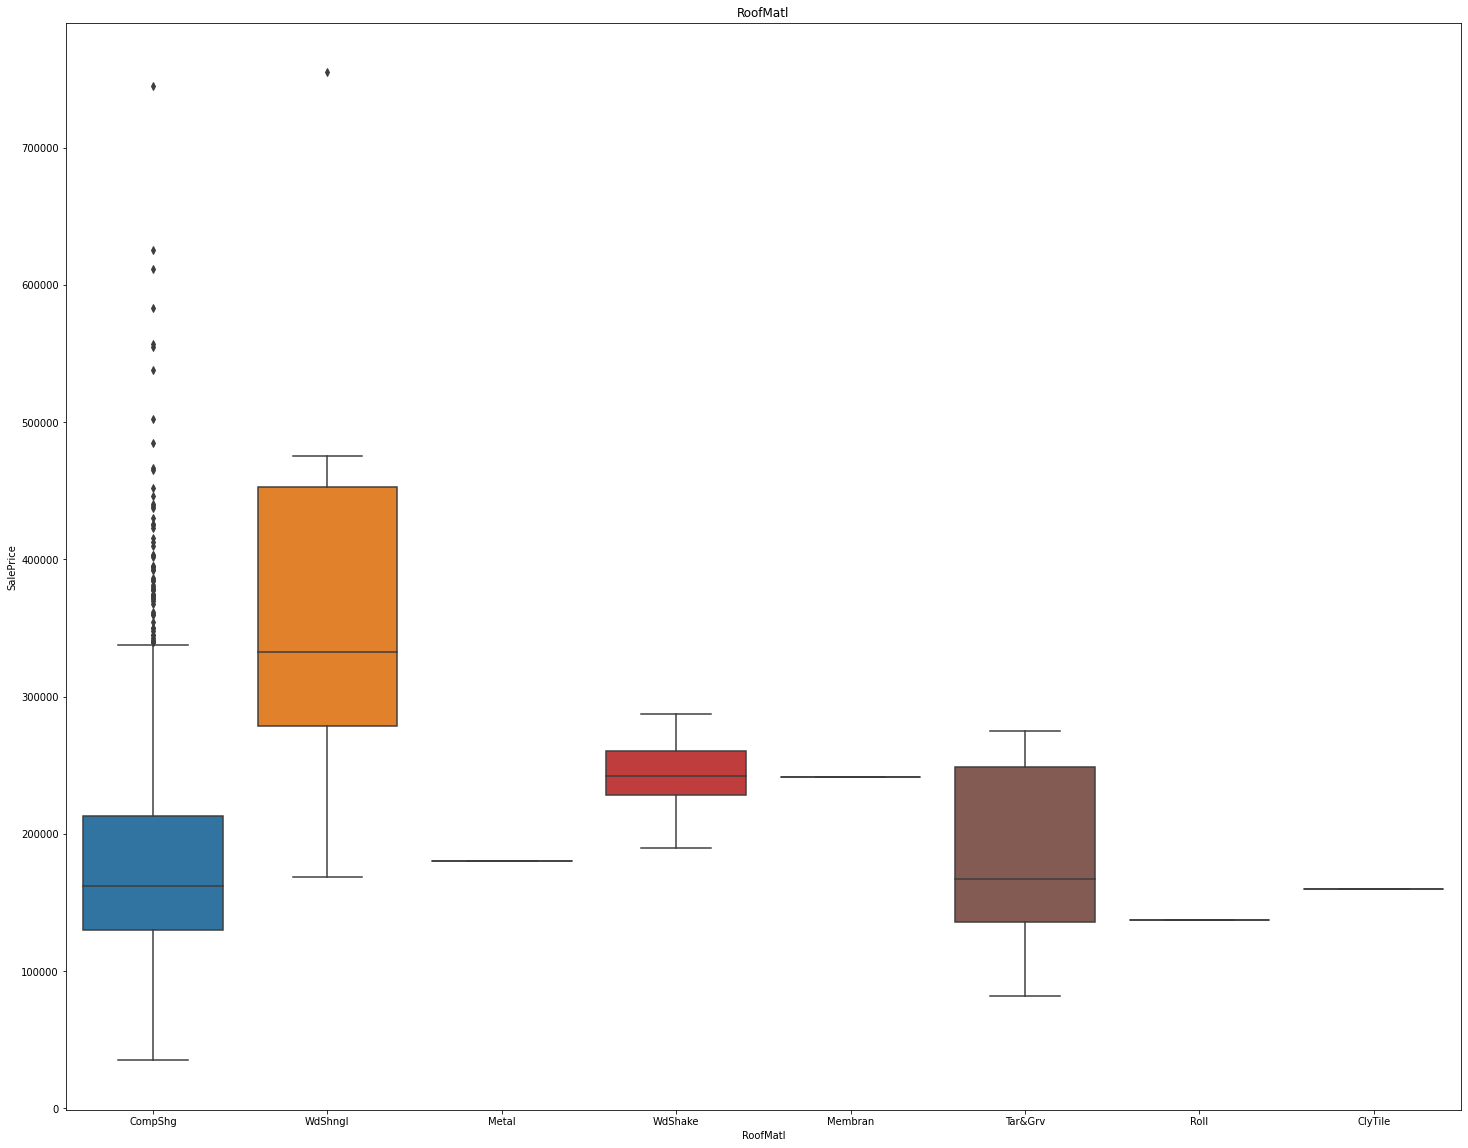

In [30]:
plt.figure(figsize=(25,20))
sns.boxplot(x=selected_categoric_train_data['RoofMatl'], y=categoric_train_data['SalePrice'])
plt.title('RoofMatl')

Text(0.5, 1.0, 'RoofMatl')

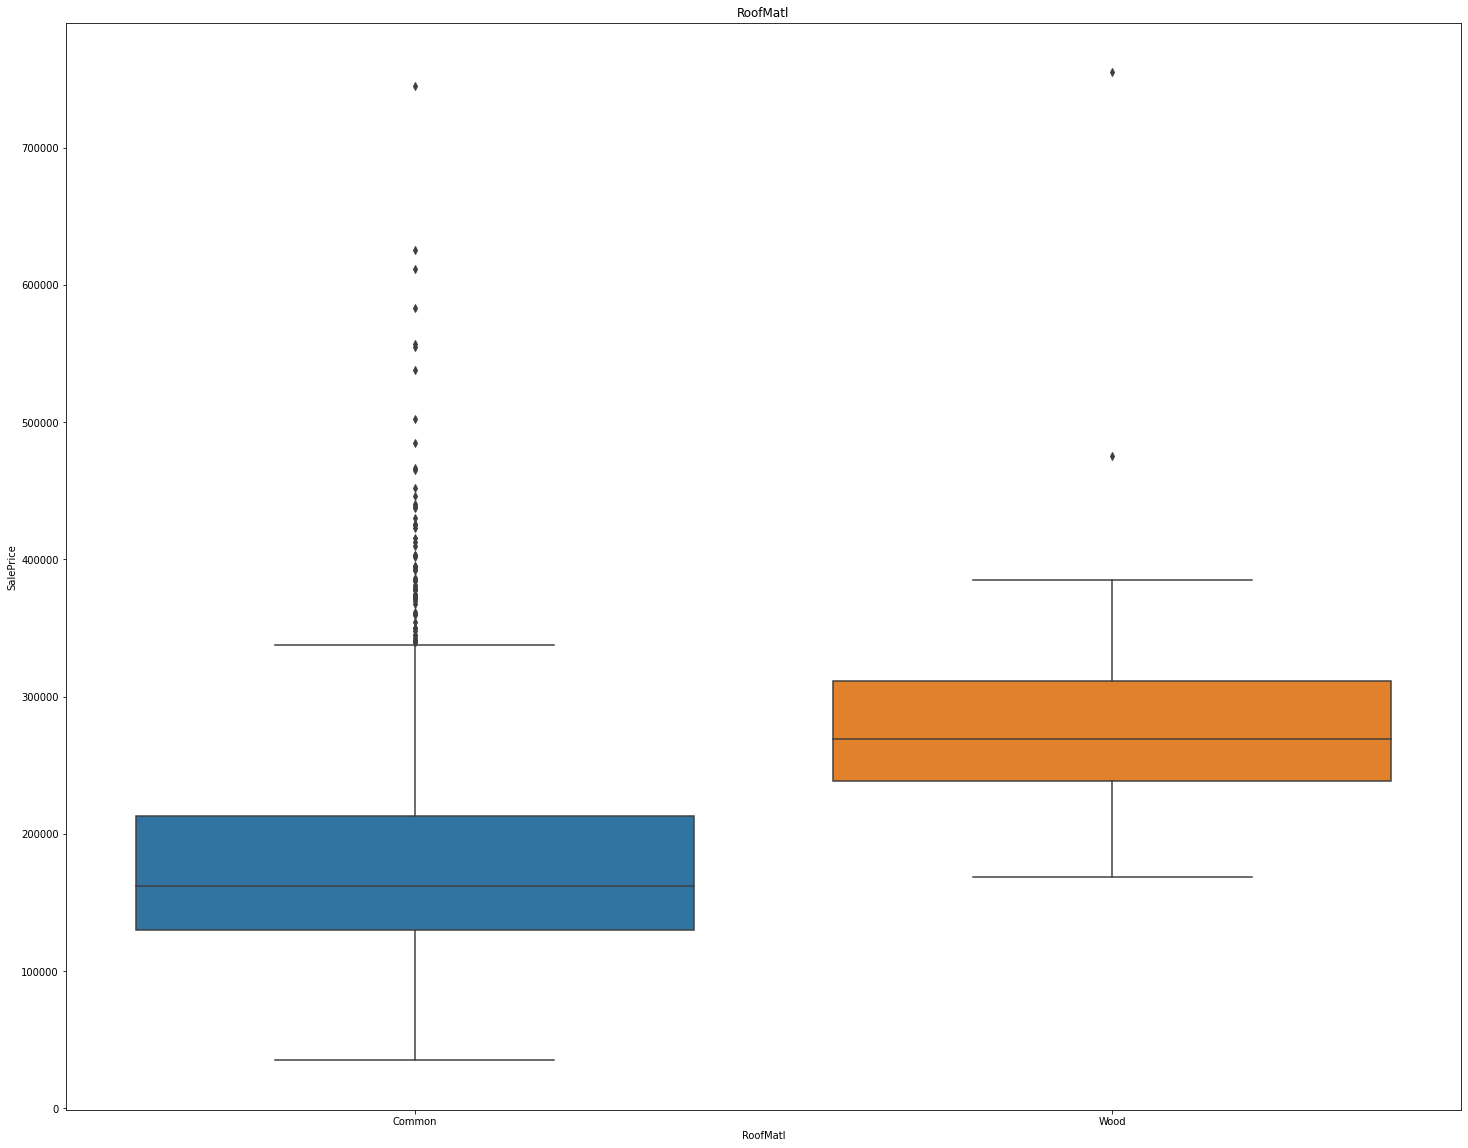

In [31]:
new_values ={
    'ClyTile':'Common',
    'CompShg':'Common',
    'Membran':'Wood',
    'Metal':'Common',
    'Roll':'Common',
    'Tar&Grv':'Common',
    'WdShake':'Wood',
    'WdShngl':'Wood',
}
modified_categoric_train_data['RoofMatl'] = selected_categoric_train_data.RoofMatl.replace(new_values)
modified_categoric_test_data['RoofMatl'] = selected_categoric_test_data.RoofMatl.replace(new_values)


plt.figure(figsize=(25,20))
sns.boxplot(x=modified_categoric_train_data['RoofMatl'], y=categoric_train_data['SalePrice'])
plt.title('RoofMatl')

Text(0.5, 1.0, 'ExterQual')

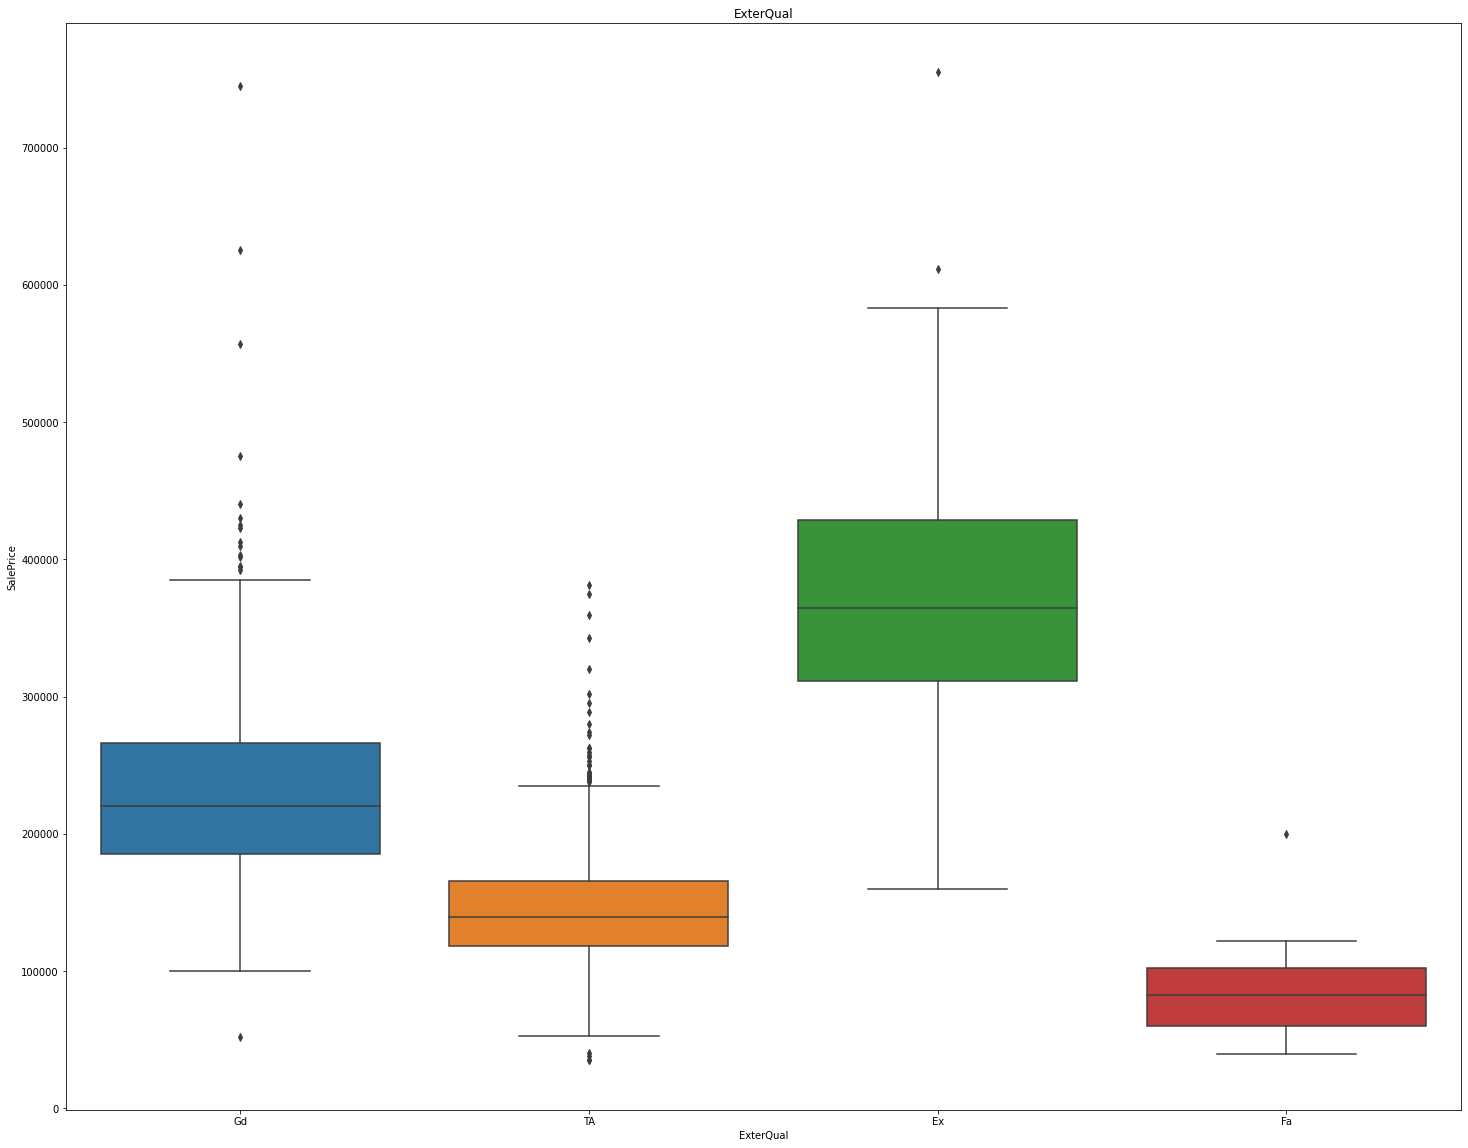

In [32]:
plt.figure(figsize=(25,20))
sns.boxplot(x=selected_categoric_train_data['ExterQual'], y=categoric_train_data['SalePrice'])
plt.title('ExterQual')

Text(0.5, 1.0, 'ExterQual')

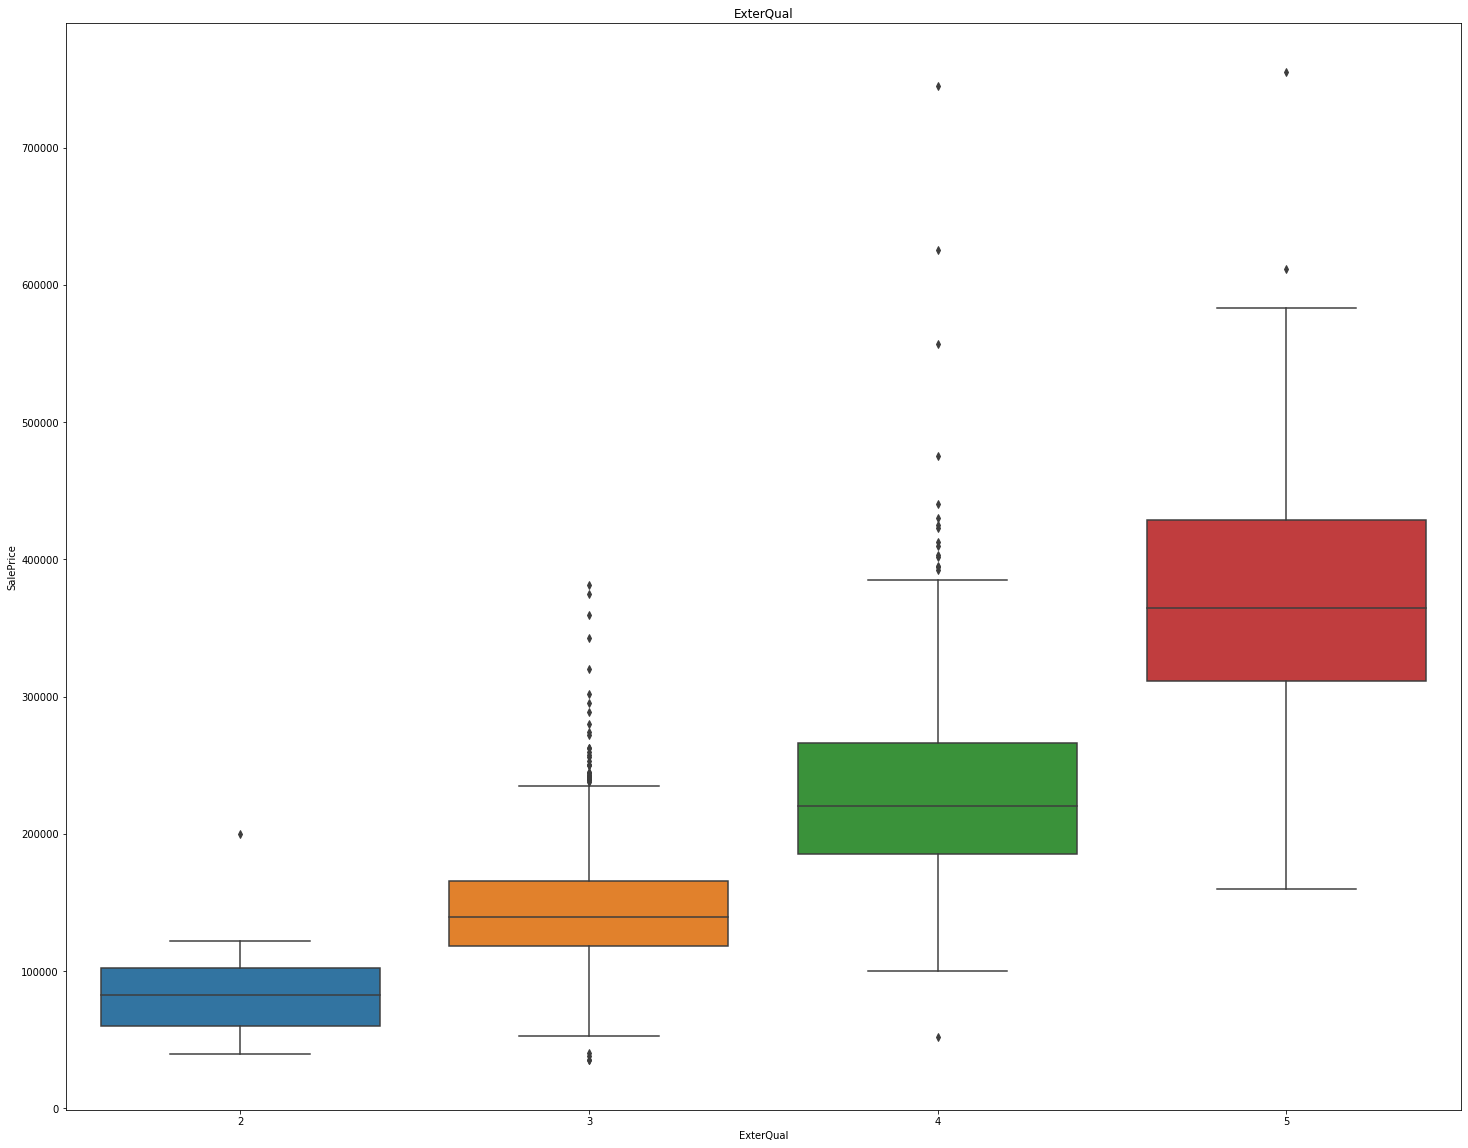

In [33]:
new_values ={
    'Ex':5,
    'Gd':4,
    'TA':3,
    'Fa':2,
    'Po':1
}
modified_categoric_train_data['ExterQual'] = selected_categoric_train_data.ExterQual.replace(new_values)
modified_categoric_test_data['ExterQual'] = selected_categoric_test_data.ExterQual.replace(new_values)


plt.figure(figsize=(25,20))
sns.boxplot(x=modified_categoric_train_data['ExterQual'], y=categoric_train_data['SalePrice'])
plt.title('ExterQual')

Text(0.5, 1.0, 'BsmtQual')

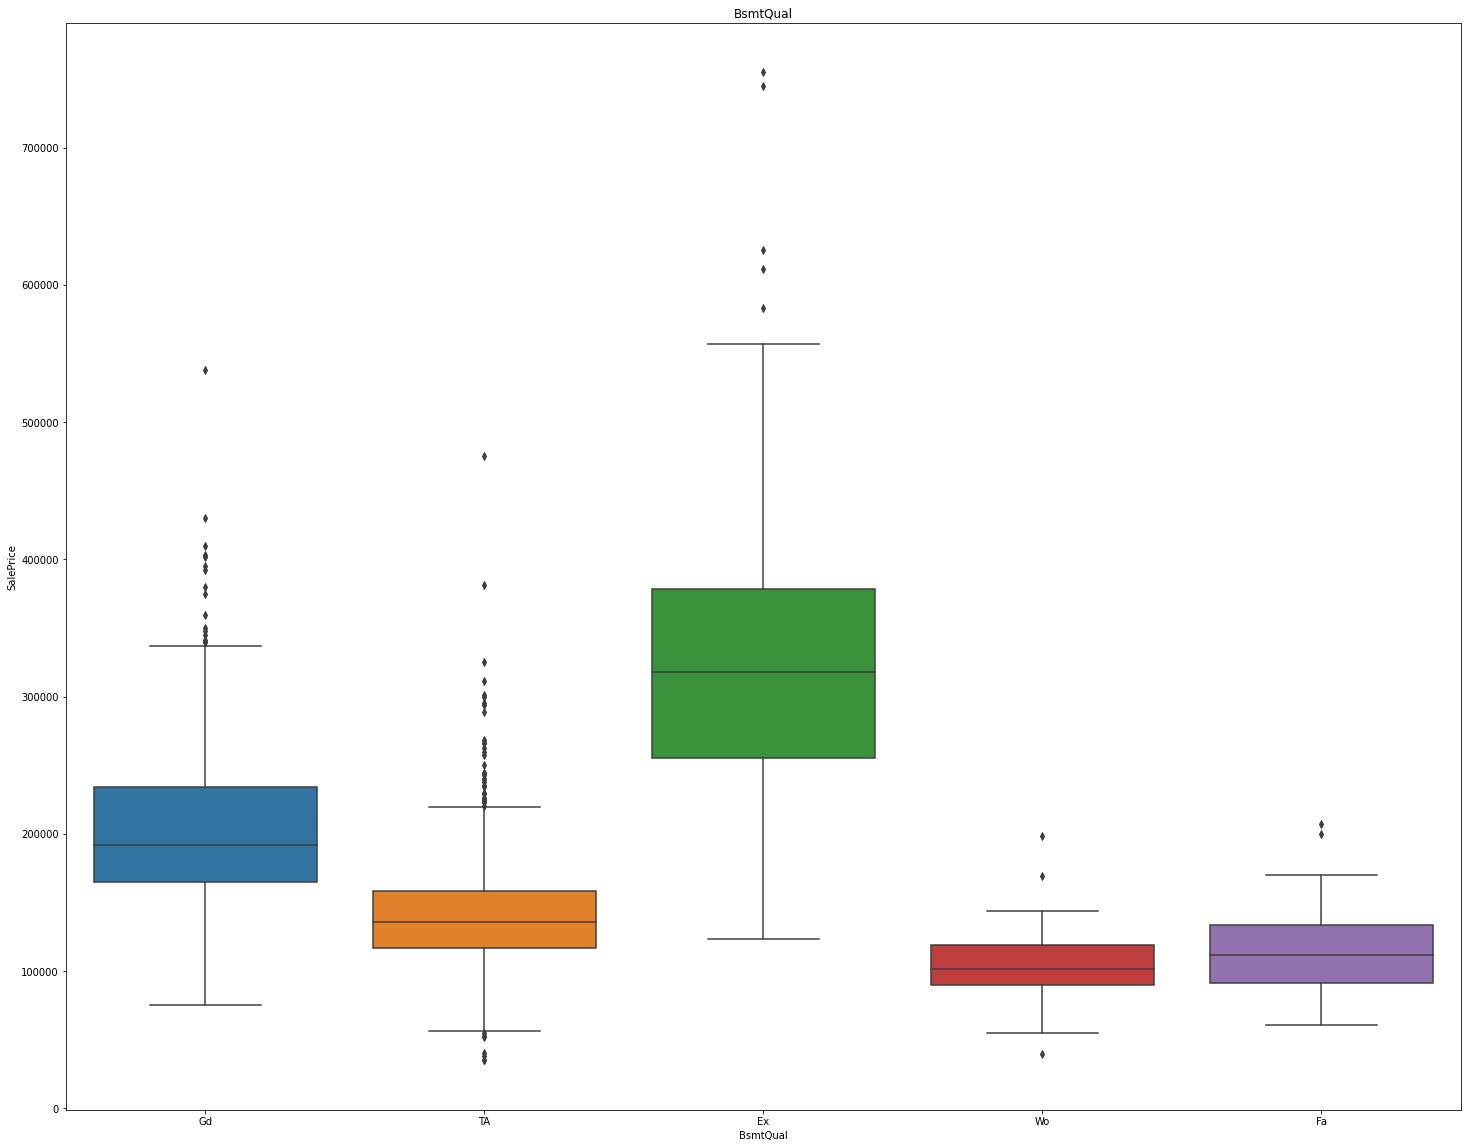

In [34]:
plt.figure(figsize=(25,20))
sns.boxplot(x=selected_categoric_train_data['BsmtQual'], y=categoric_train_data['SalePrice'])
plt.title('BsmtQual')

Text(0.5, 1.0, 'BsmtQual')

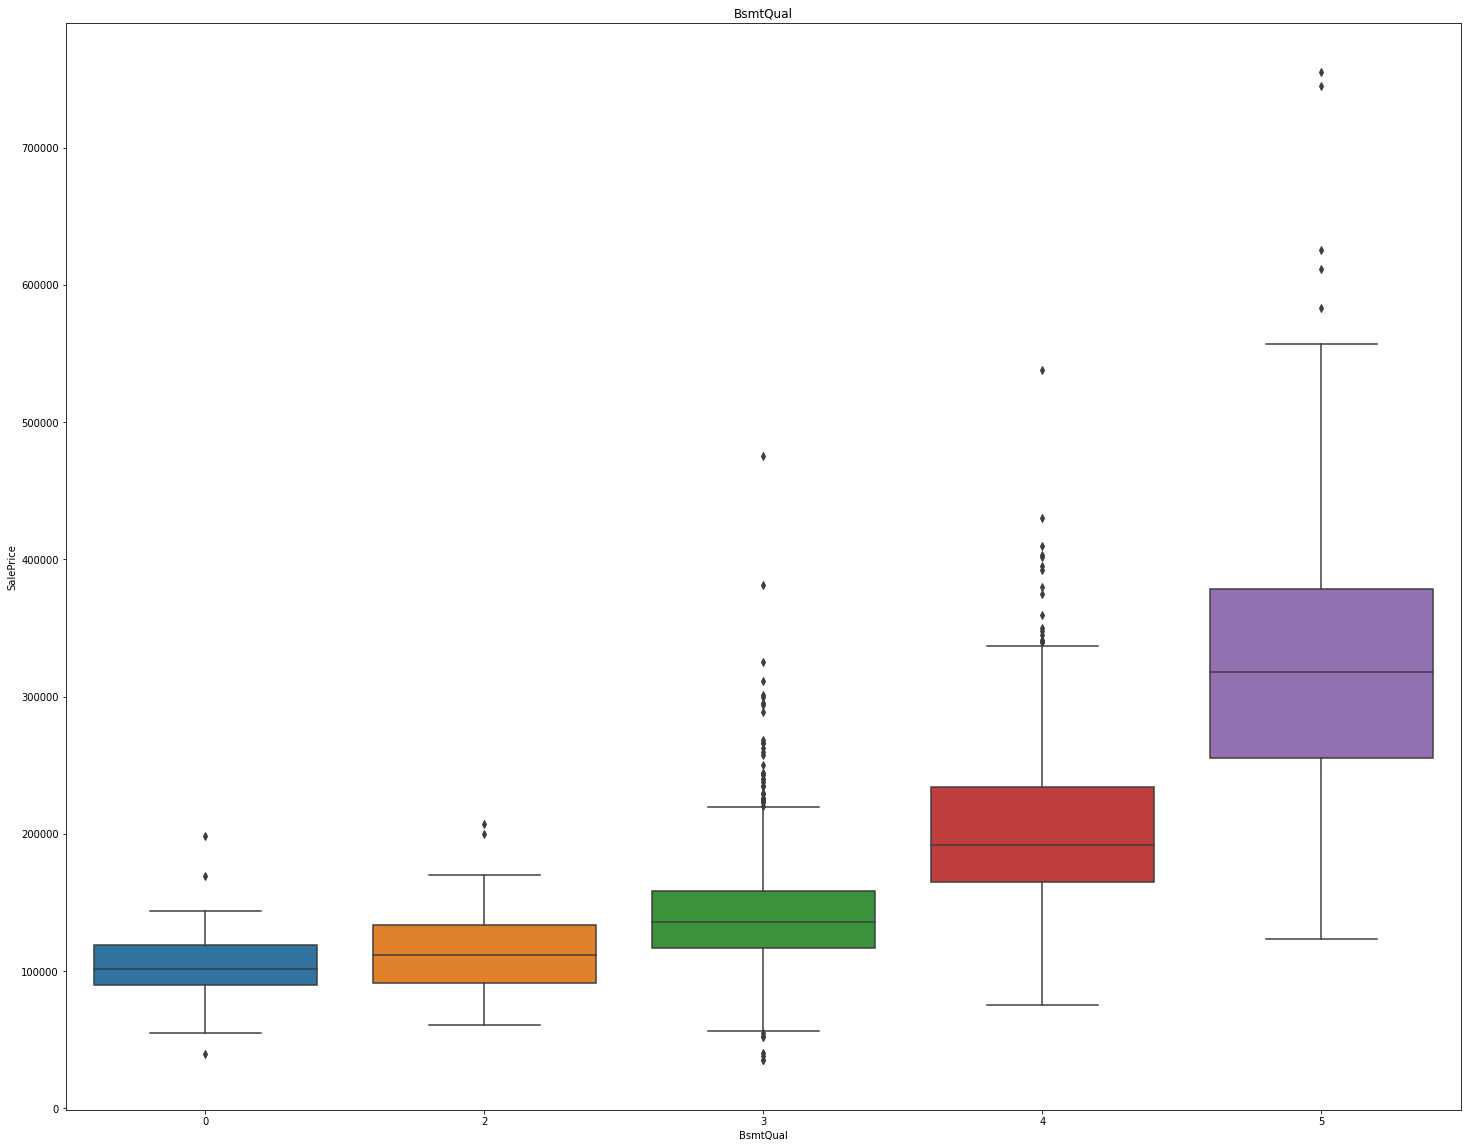

In [35]:
new_values ={
    'Ex':5,
    'Gd':4,
    'TA':3,
    'Fa':2,
    'Po':1,
    'Wo':0
}
modified_categoric_train_data['BsmtQual'] = selected_categoric_train_data.BsmtQual.replace(new_values)
modified_categoric_test_data['BsmtQual'] = selected_categoric_test_data.BsmtQual.replace(new_values)


plt.figure(figsize=(25,20))
sns.boxplot(x=modified_categoric_train_data['BsmtQual'], y=categoric_train_data['SalePrice'])
plt.title('BsmtQual')

Text(0.5, 1.0, 'BsmtCond')

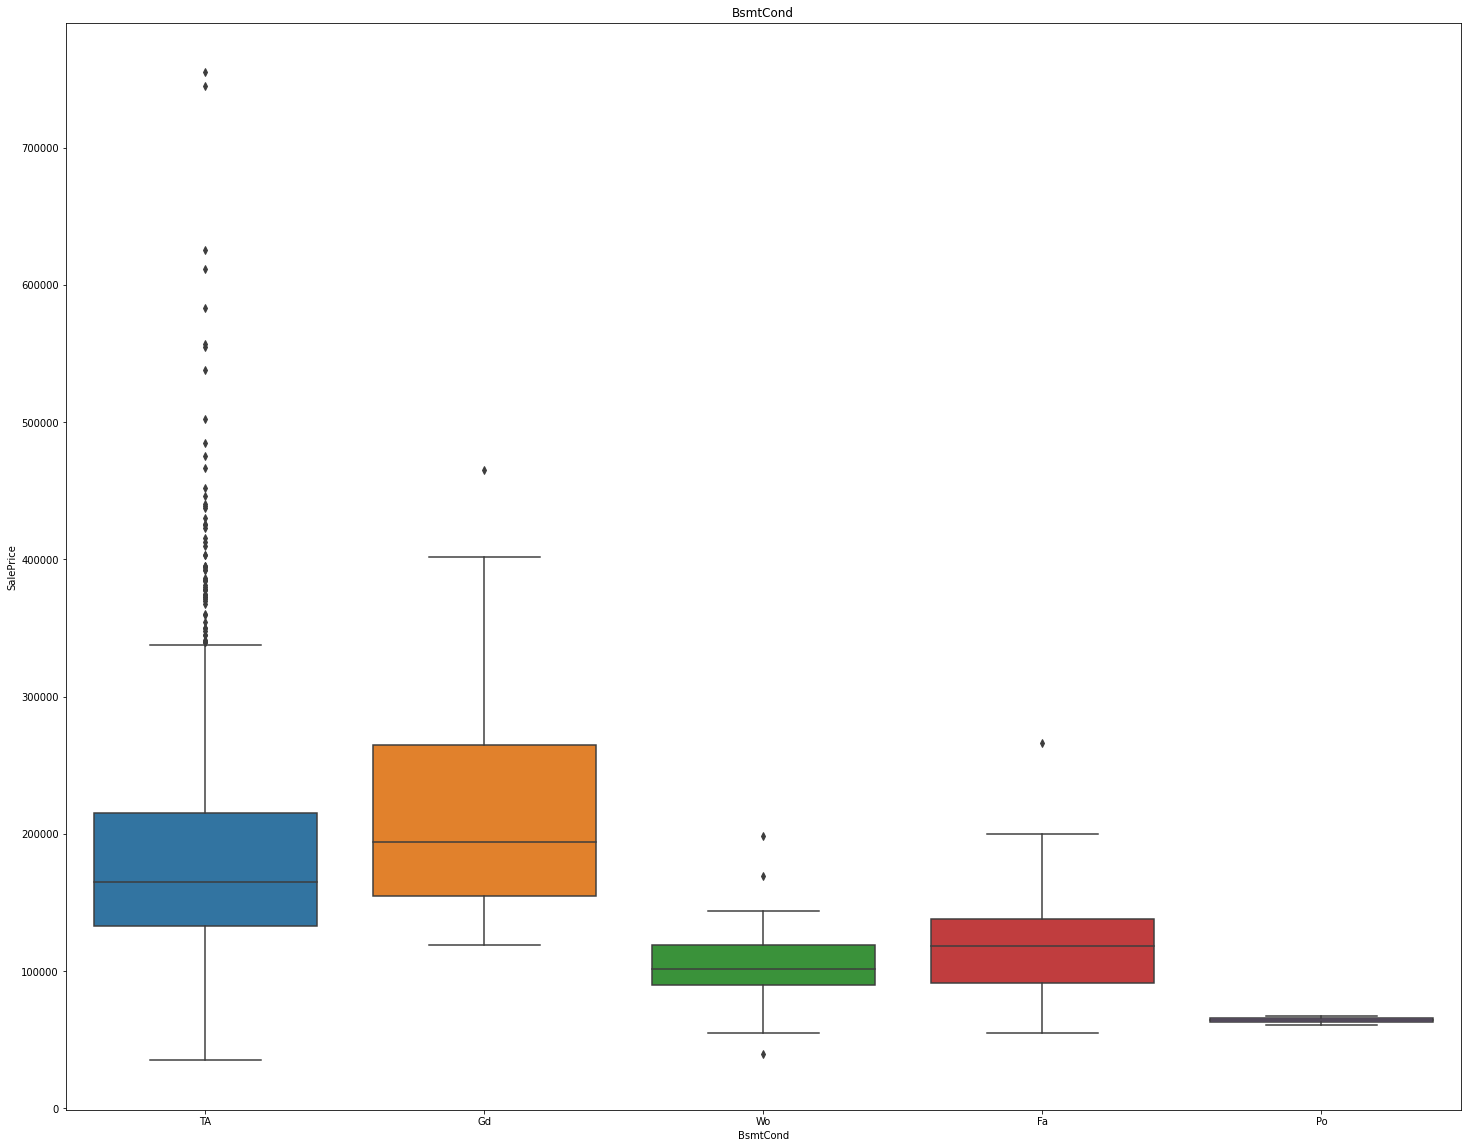

In [36]:
plt.figure(figsize=(25,20))
sns.boxplot(x=selected_categoric_train_data['BsmtCond'], y=categoric_train_data['SalePrice'])
plt.title('BsmtCond')

Text(0.5, 1.0, 'BsmtCond')

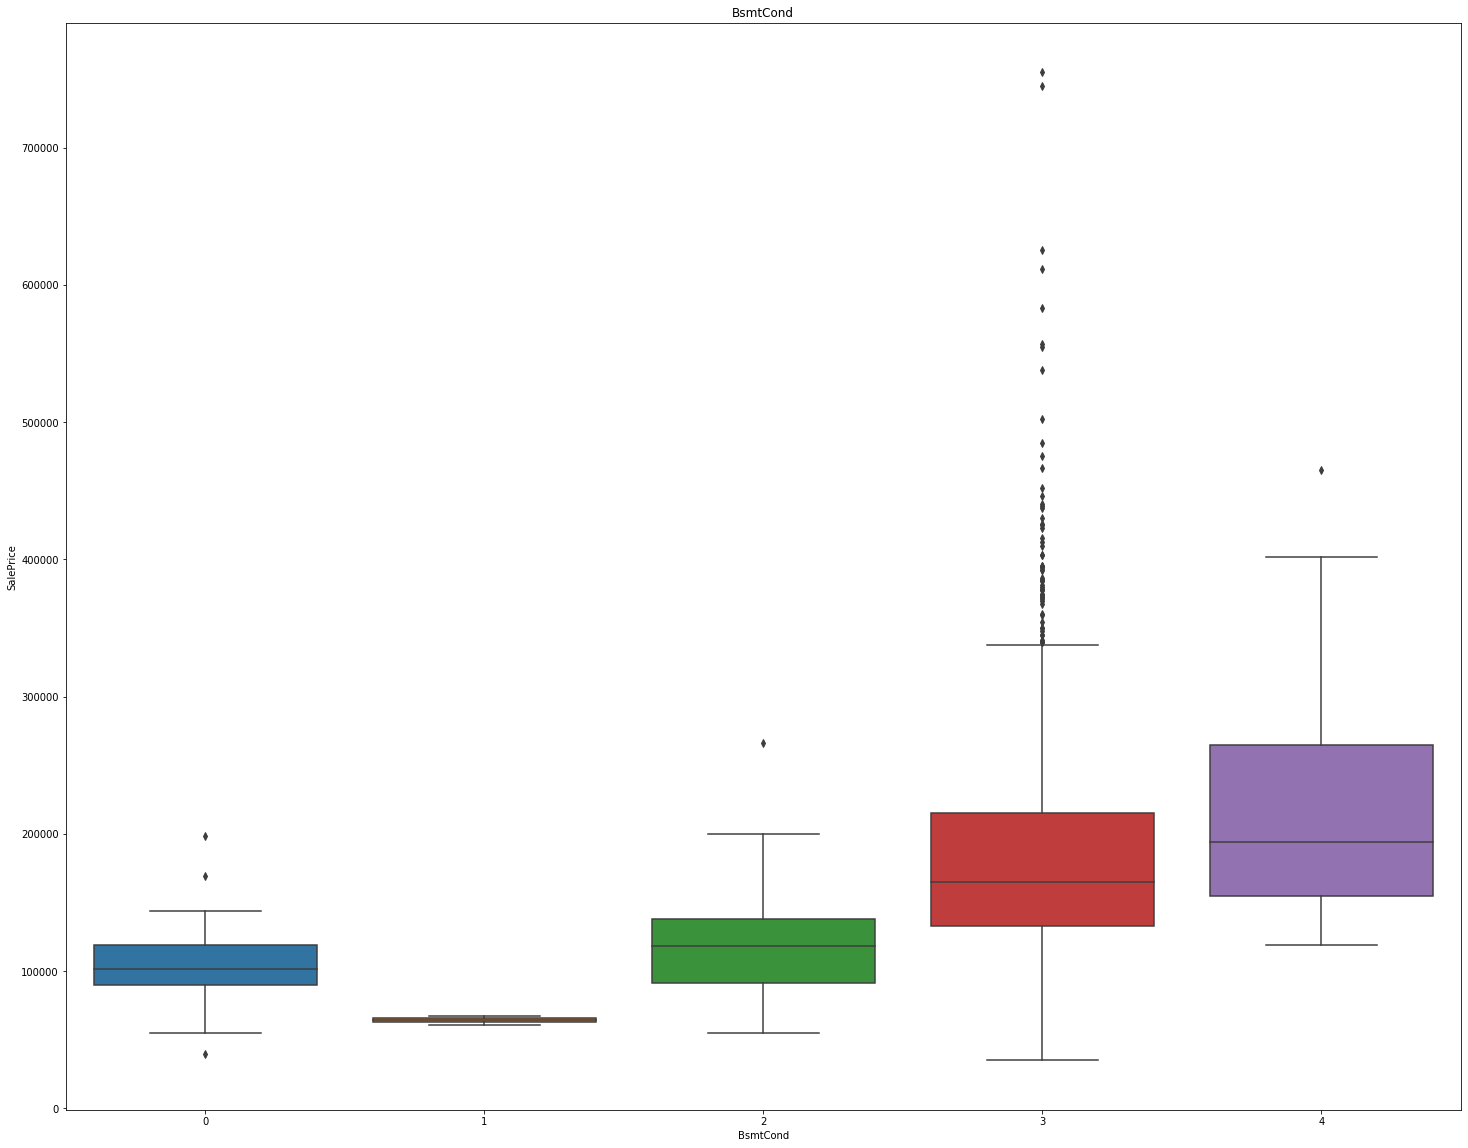

In [37]:
new_values ={
    'Ex':5,
    'Gd':4,
    'TA':3,
    'Fa':2,
    'Po':1,
    'Wo':0
}
modified_categoric_train_data['BsmtCond'] = selected_categoric_train_data.BsmtCond.replace(new_values)
modified_categoric_test_data['BsmtCond'] = selected_categoric_test_data.BsmtCond.replace(new_values)


plt.figure(figsize=(25,20))
sns.boxplot(x=modified_categoric_train_data['BsmtCond'], y=categoric_train_data['SalePrice'])
plt.title('BsmtCond')

Text(0.5, 1.0, 'CentralAir')

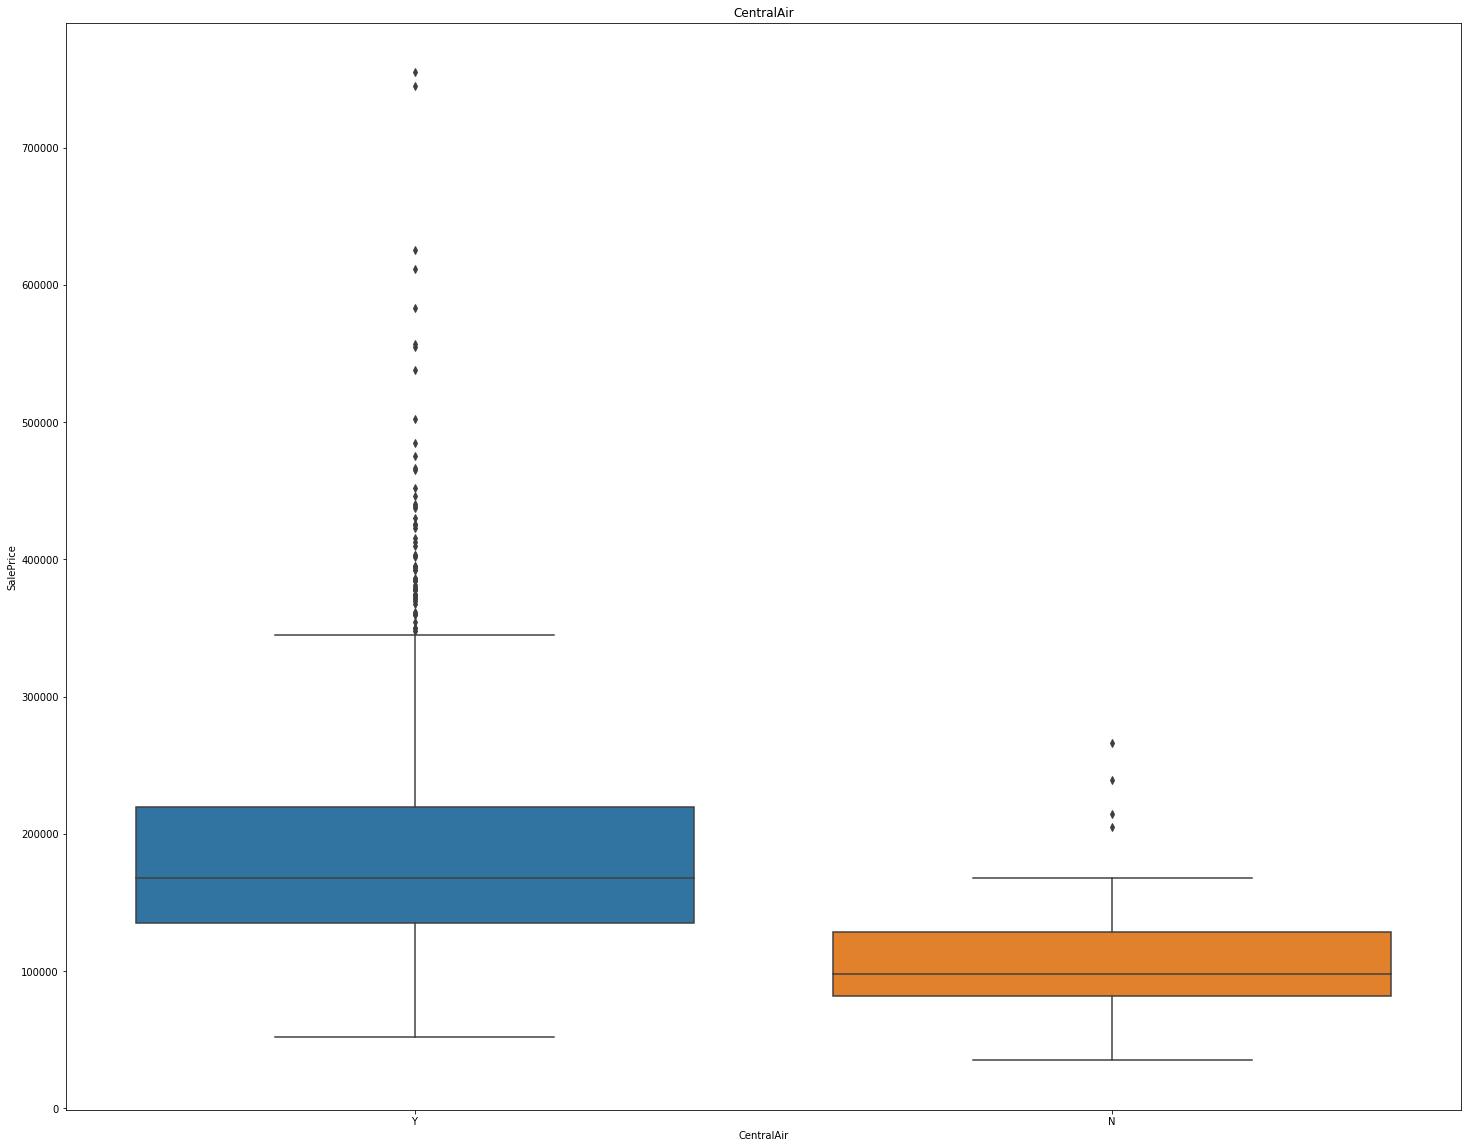

In [38]:
plt.figure(figsize=(25,20))
sns.boxplot(x=selected_categoric_train_data['CentralAir'], y=categoric_train_data['SalePrice'])
plt.title('CentralAir')

Text(0.5, 1.0, 'CentralAir')

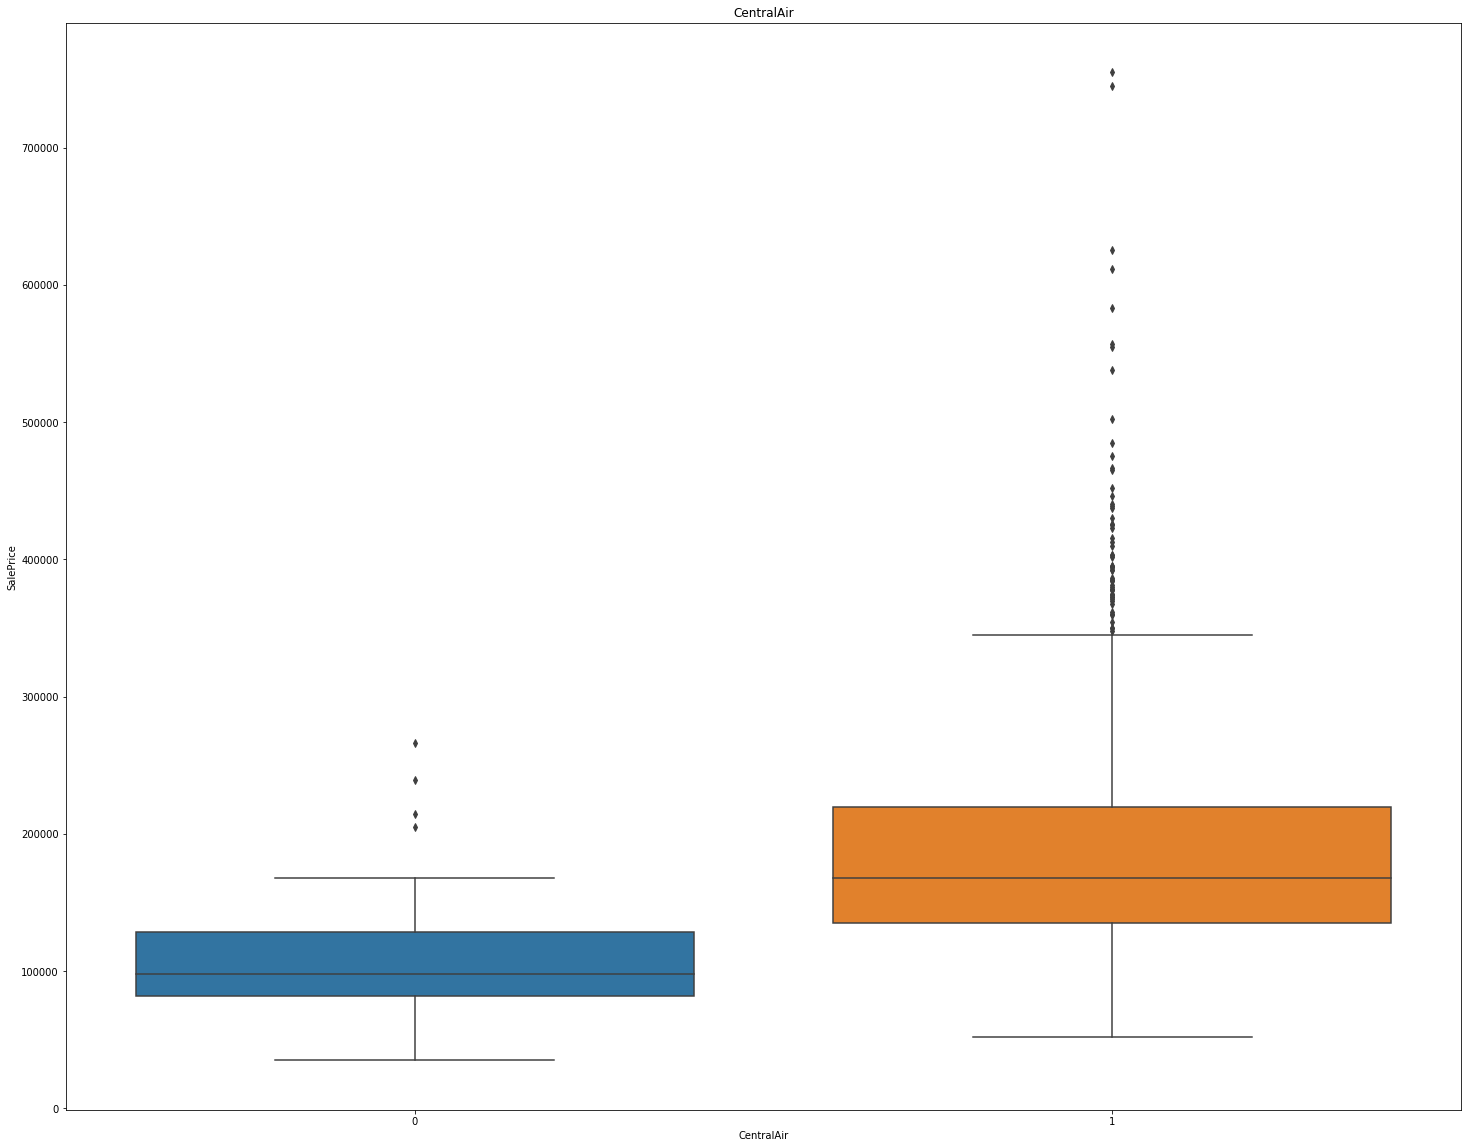

In [39]:
new_values ={
    'Y':1,
    'N':0
}
modified_categoric_train_data['CentralAir'] = selected_categoric_train_data.CentralAir.replace(new_values)
modified_categoric_test_data['CentralAir'] = selected_categoric_test_data.CentralAir.replace(new_values)


plt.figure(figsize=(25,20))
sns.boxplot(x=modified_categoric_train_data['CentralAir'], y=categoric_train_data['SalePrice'])
plt.title('CentralAir')

Text(0.5, 1.0, 'KitchenQual')

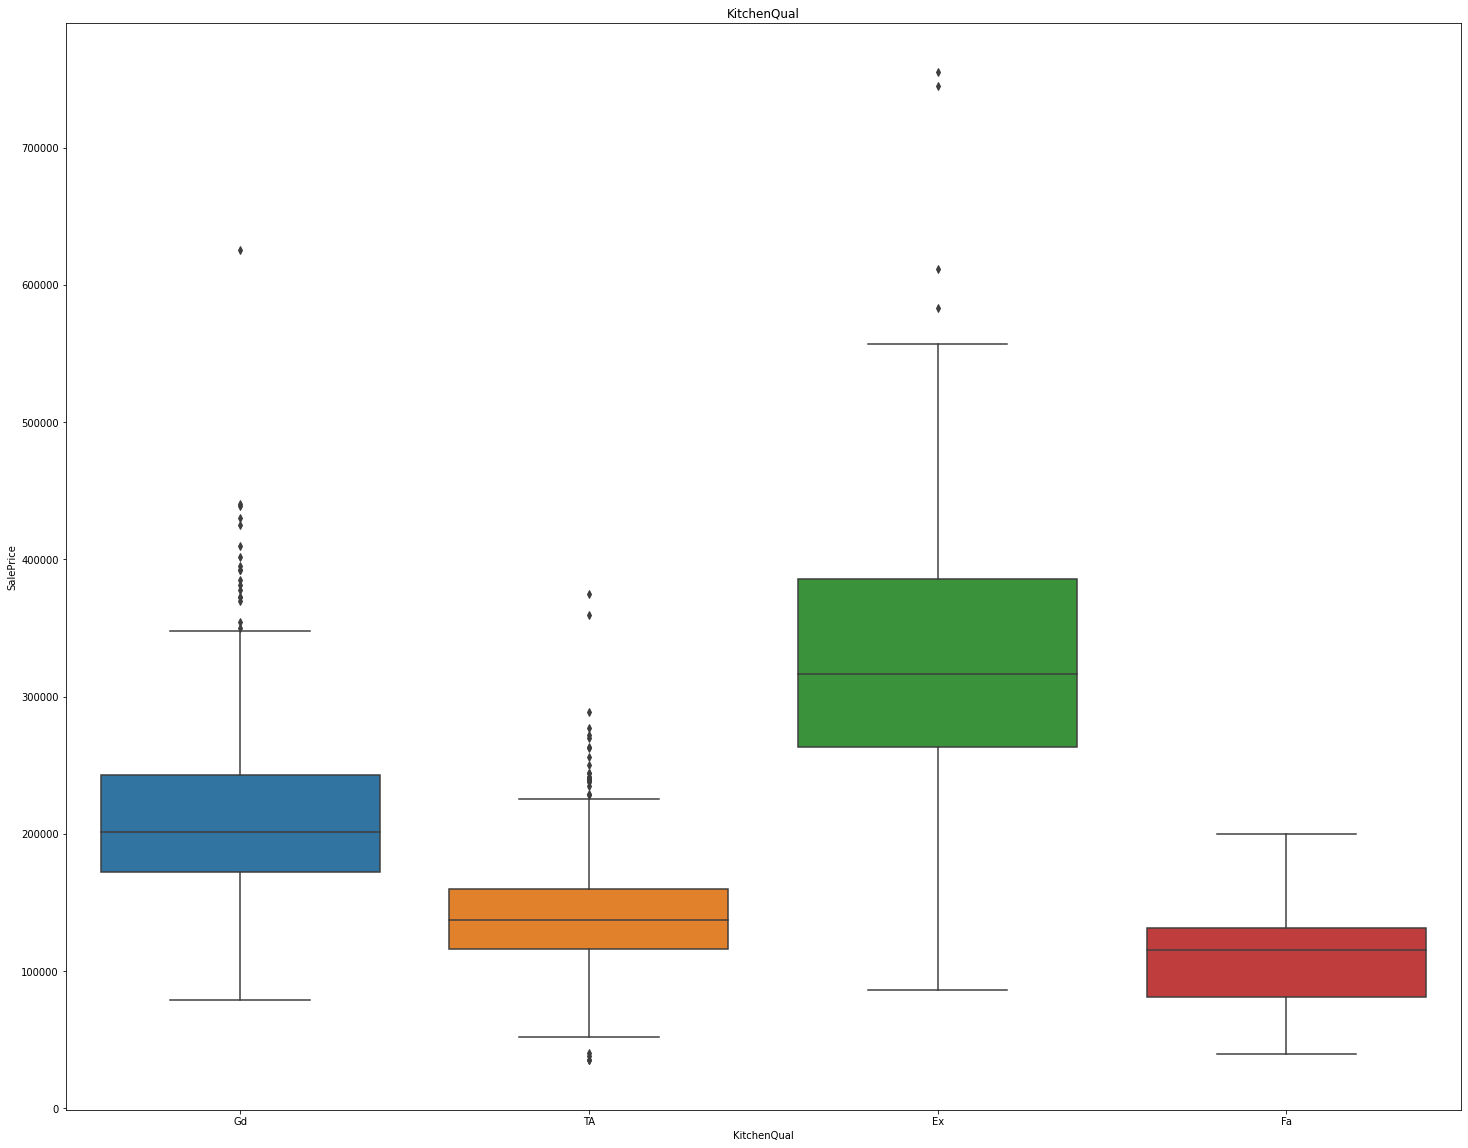

In [40]:
plt.figure(figsize=(25,20))
sns.boxplot(x=selected_categoric_train_data['KitchenQual'], y=categoric_train_data['SalePrice'])
plt.title('KitchenQual')

Text(0.5, 1.0, 'KitchenQual')

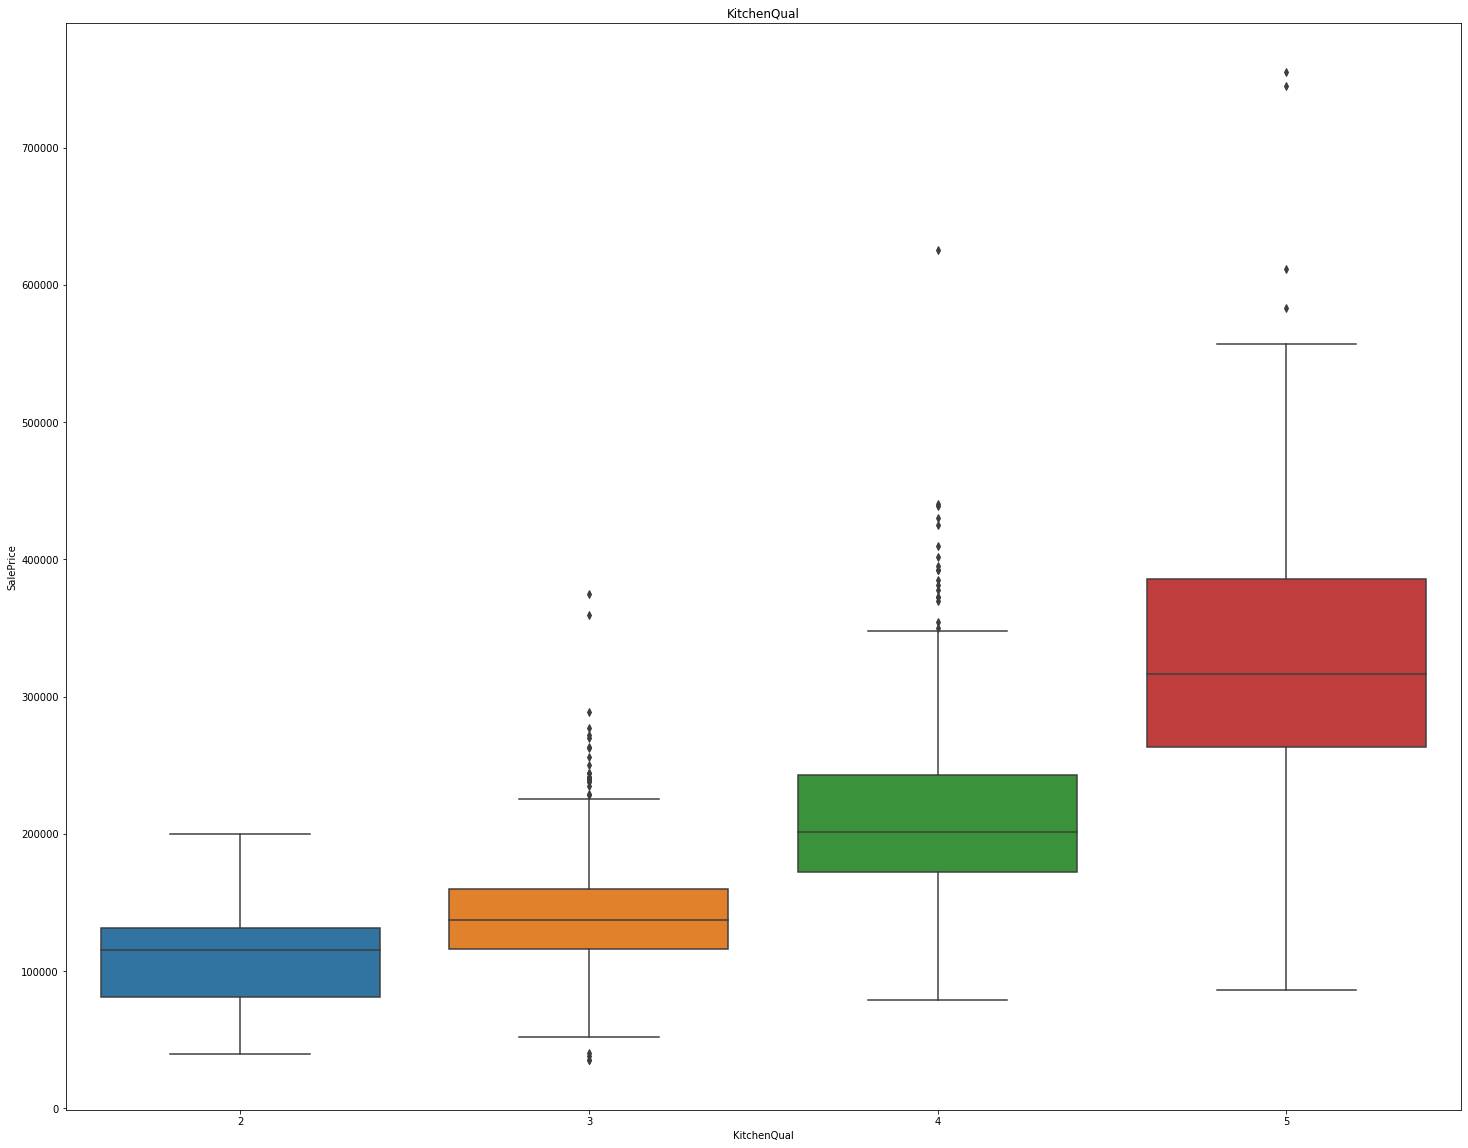

In [41]:
new_values ={
    'Ex':5,
    'Gd':4,
    'TA':3,
    'Fa':2,
    'Po':1,
    'Wo':0
}
modified_categoric_train_data['KitchenQual'] = selected_categoric_train_data.KitchenQual.replace(new_values)
modified_categoric_test_data['KitchenQual'] = selected_categoric_test_data.KitchenQual.replace(new_values)


plt.figure(figsize=(25,20))
sns.boxplot(x=modified_categoric_train_data['KitchenQual'], y=categoric_train_data['SalePrice'])
plt.title('KitchenQual')

Text(0.5, 1.0, 'GarageType')

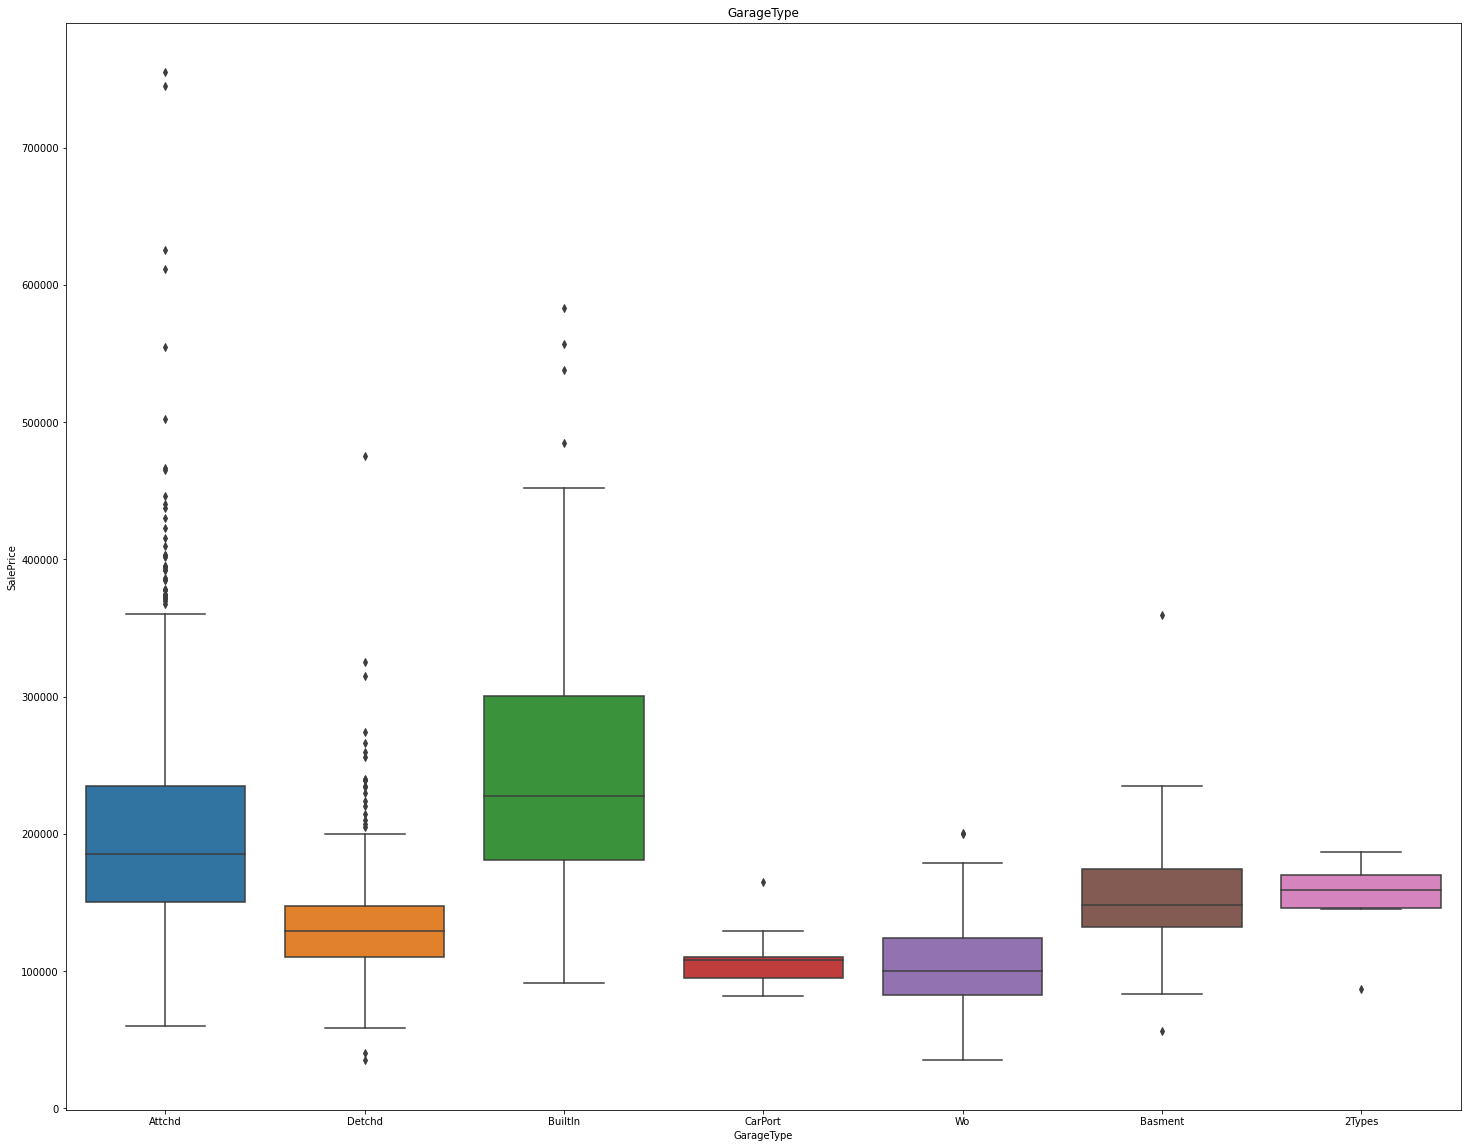

In [42]:
plt.figure(figsize=(25,20))
sns.boxplot(x=selected_categoric_train_data['GarageType'], y=categoric_train_data['SalePrice'])
plt.title('GarageType')

Text(0.5, 1.0, 'GarageType')

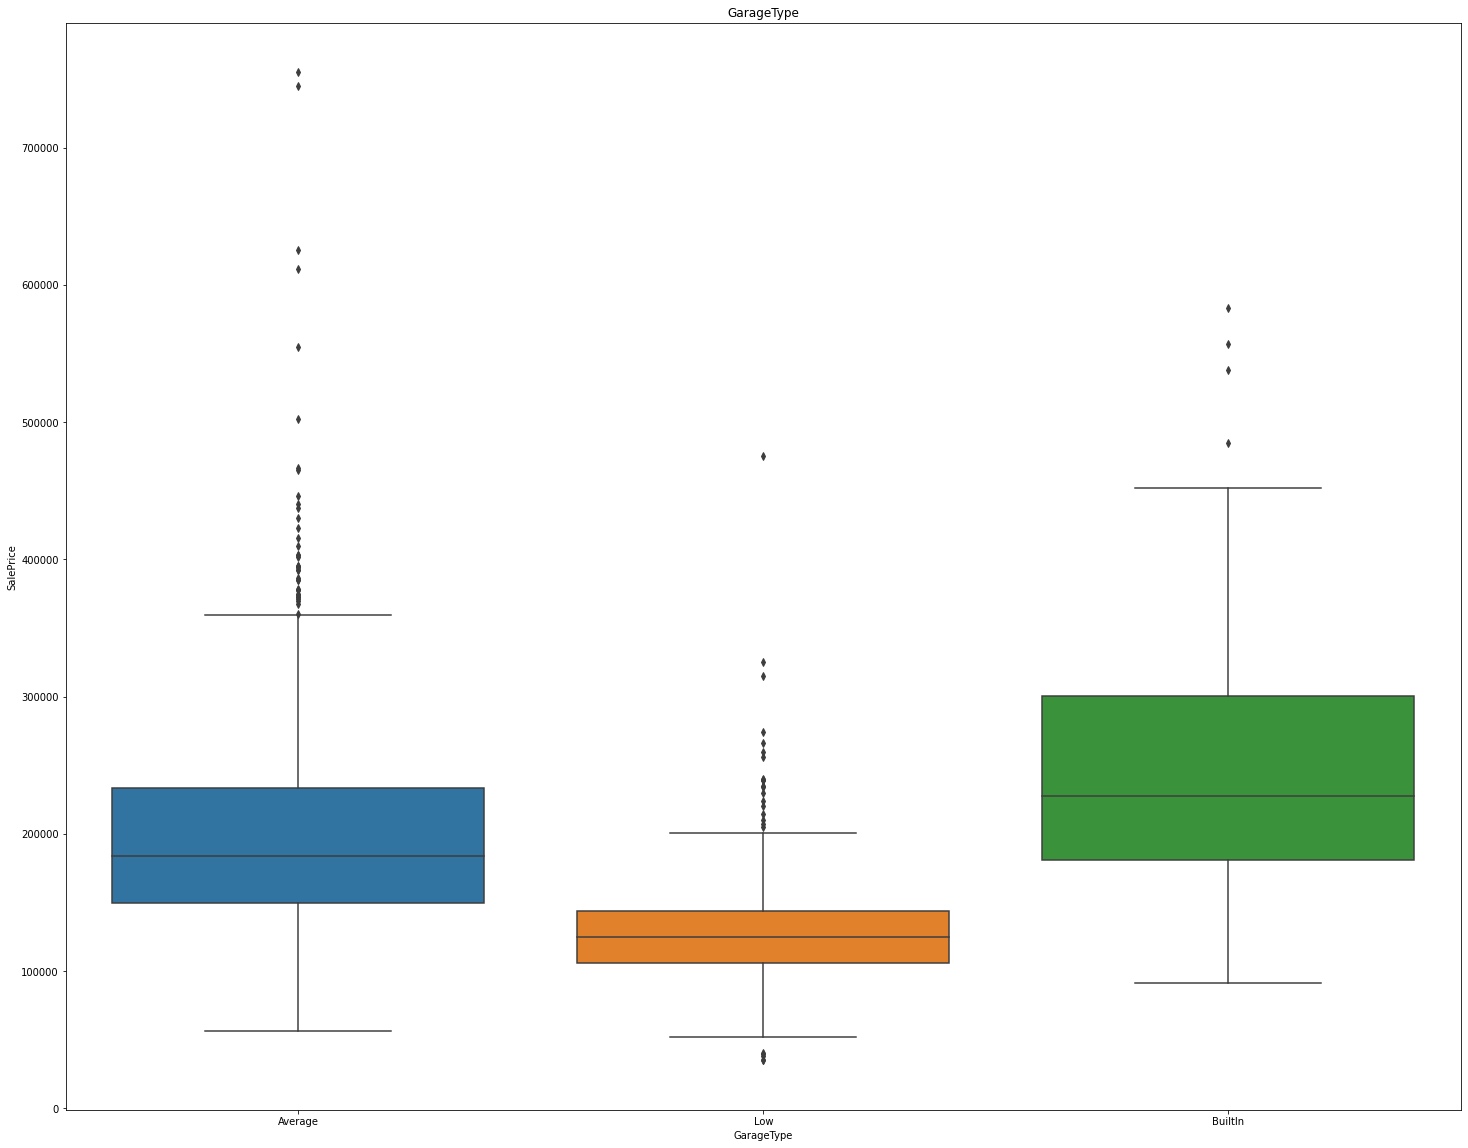

In [43]:
new_values ={
    '2Types':'Average',
    'Attchd':'Average',
    'Basment':'Average',
    'BuiltIn':'BuiltIn',
    'CarPort':'Low',
    'Detchd':'Low',
    'Wo':'Low'
}
modified_categoric_train_data['GarageType'] = selected_categoric_train_data.GarageType.replace(new_values)
modified_categoric_test_data['GarageType'] = selected_categoric_test_data.GarageType.replace(new_values)


plt.figure(figsize=(25,20))
sns.boxplot(x=modified_categoric_train_data['GarageType'], y=categoric_train_data['SalePrice'])
plt.title('GarageType')

Text(0.5, 1.0, 'SaleType')

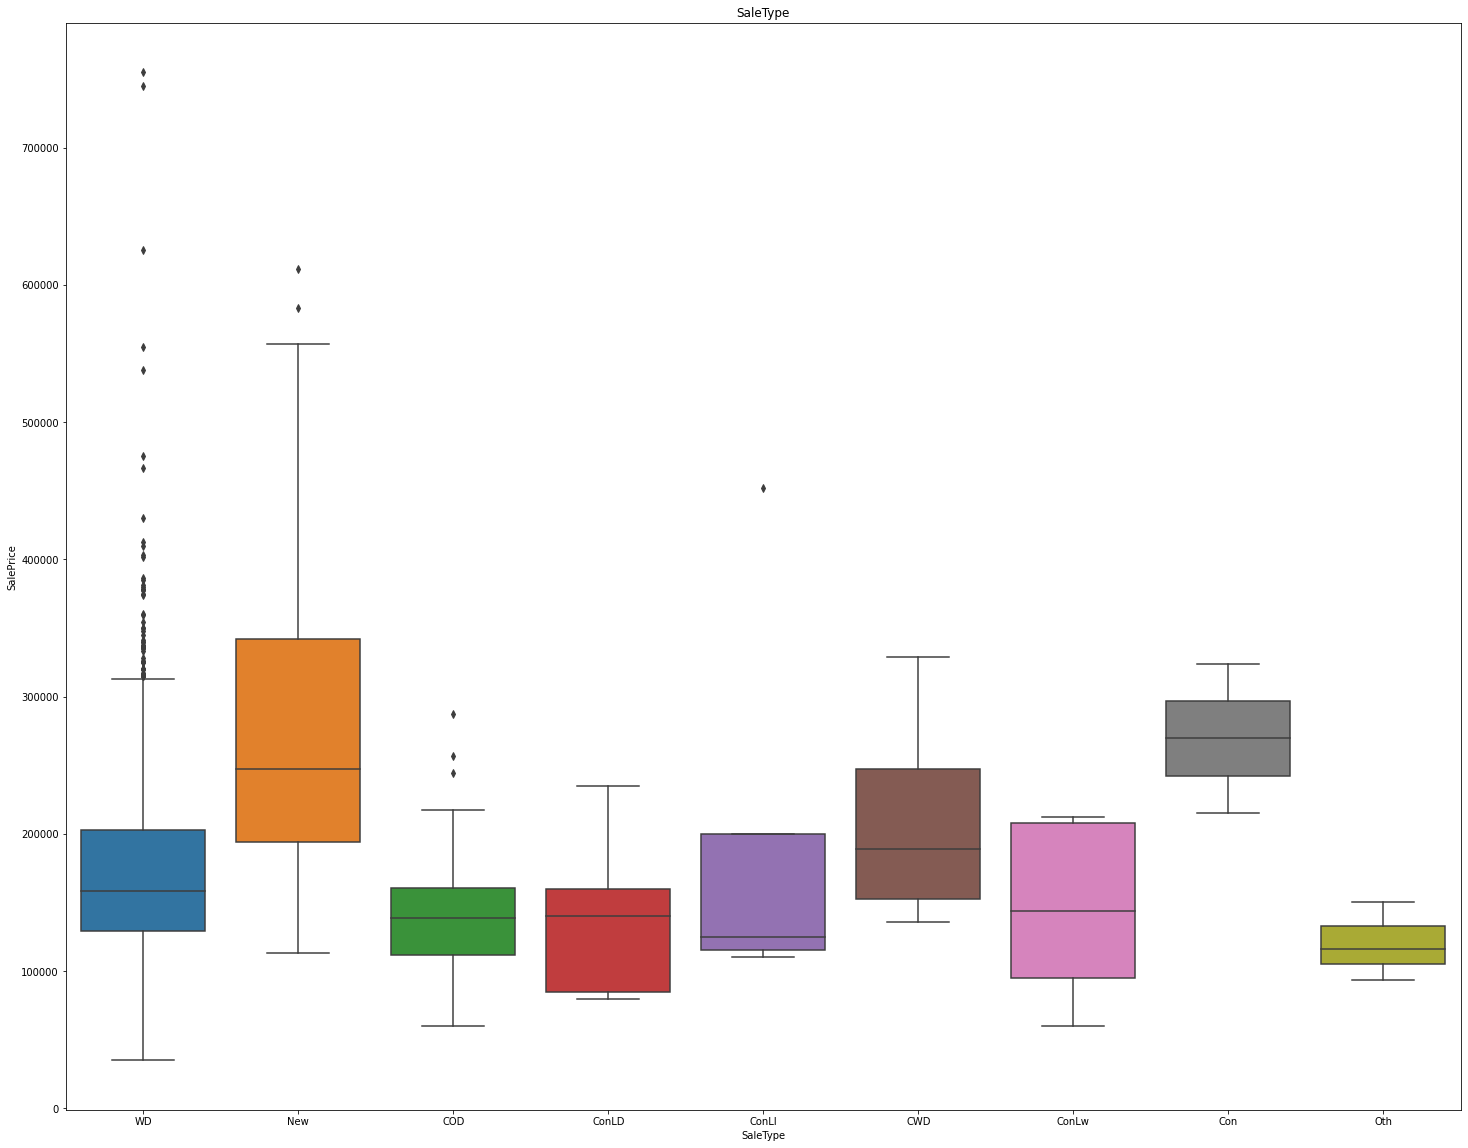

In [44]:
plt.figure(figsize=(25,20))
sns.boxplot(x=selected_categoric_train_data['SaleType'], y=categoric_train_data['SalePrice'])
plt.title('SaleType')

Text(0.5, 1.0, 'SaleType')

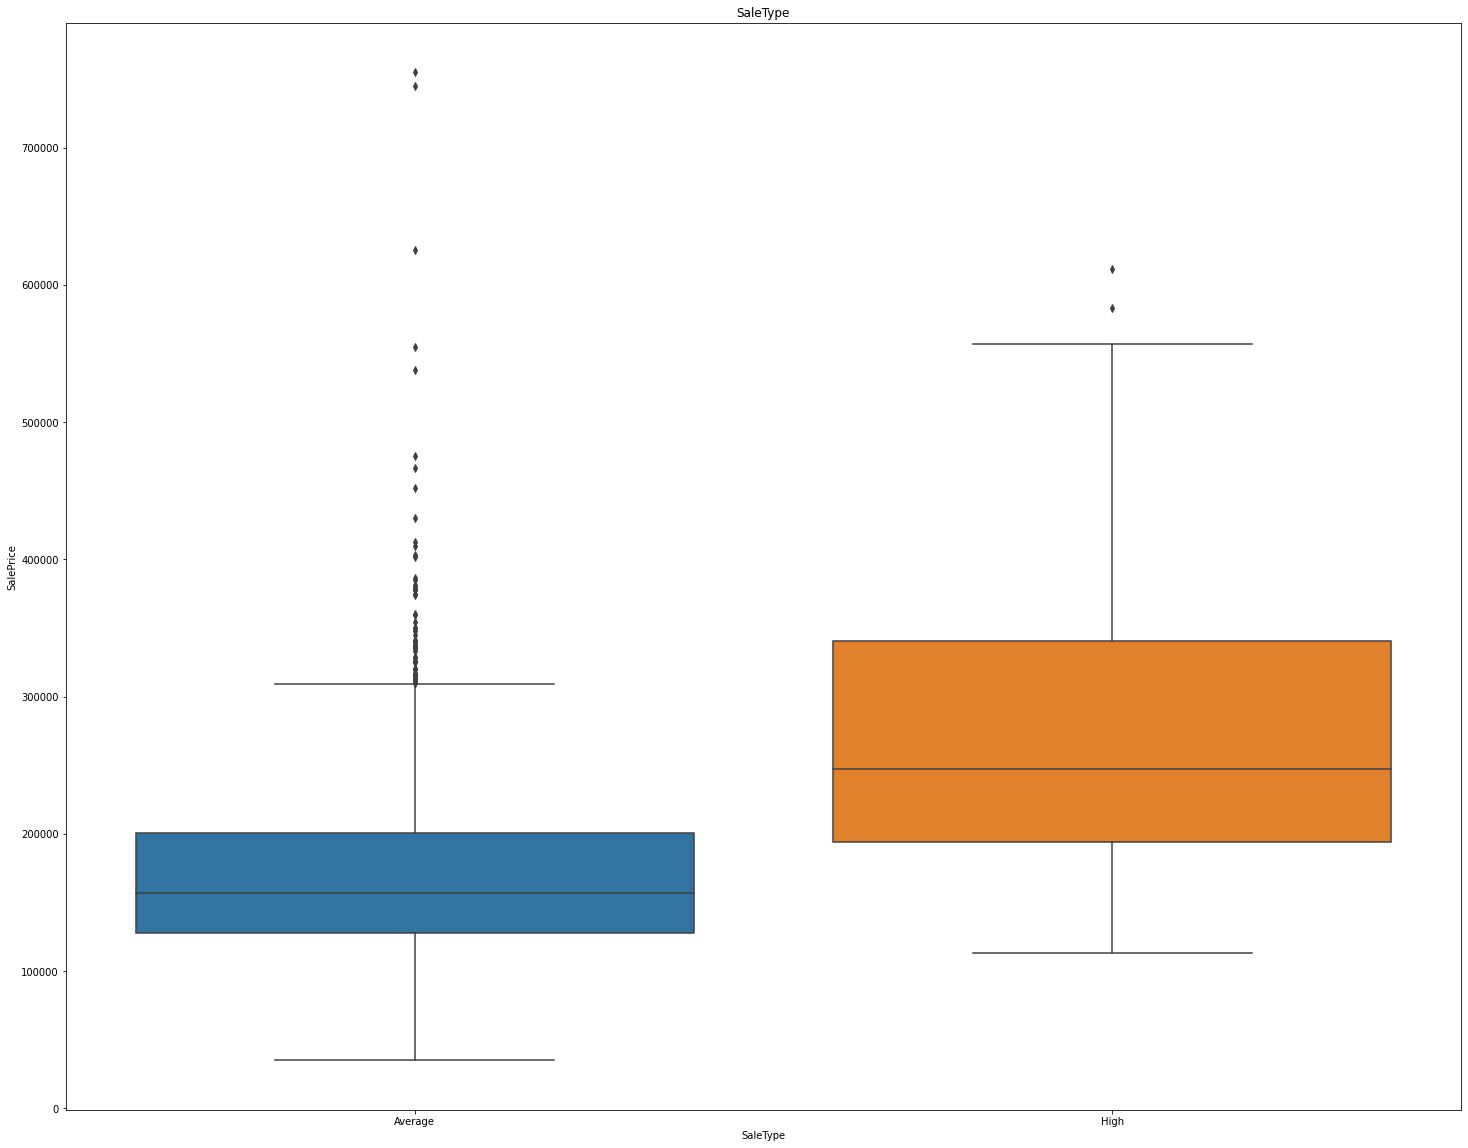

In [45]:
new_values ={
    'WD':'Average',
    'CWD':'Average',
    'VWD':'Average',
    'New':'High',
    'COD':'Average',
    'Con':'High',
    'ConLw':'Average',
    'ConLI':'Average',
    'ConLD':'Average',
    'Oth':'Average'
}
modified_categoric_train_data['SaleType'] = selected_categoric_train_data.SaleType.replace(new_values)
modified_categoric_test_data['SaleType'] = selected_categoric_test_data.SaleType.replace(new_values)

plt.figure(figsize=(25,20))
sns.boxplot(x=modified_categoric_train_data['SaleType'], y=categoric_train_data['SalePrice'])
plt.title('SaleType')

# Encode all categoric variables 

In [46]:
ordinal_categoric_train_data = modified_categoric_train_data.select_dtypes(include=['int64', 'float64'])
cardinal_categoric_train_data = modified_categoric_train_data.select_dtypes(include=['object'])
ordinal_categoric_test_data = modified_categoric_test_data.select_dtypes(include=['int64', 'float64'])
cardinal_categoric_test_data = modified_categoric_test_data.select_dtypes(include=['object'])
cardinal_categoric_train_data.info()
cardinal_categoric_test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   MSZoning      1460 non-null   object
 1   Neighborhood  1460 non-null   object
 2   Condition1    1460 non-null   object
 3   Condition2    1460 non-null   object
 4   HouseStyle    1460 non-null   object
 5   RoofMatl      1460 non-null   object
 6   GarageType    1460 non-null   object
 7   SaleType      1460 non-null   object
dtypes: object(8)
memory usage: 91.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   MSZoning      1459 non-null   object
 1   Neighborhood  1459 non-null   object
 2   Condition1    1459 non-null   object
 3   Condition2    1459 non-null   object
 4   HouseStyle    1459 non-null   object
 5   RoofMatl      1459 non-null 

In [47]:
encoder = OneHotEncoder(handle_unknown='error', sparse=False)
encoded_cardinal_categoric_train_data = pd.DataFrame(encoder.fit_transform(cardinal_categoric_train_data))
encoded_cardinal_categoric_train_data.index = cardinal_categoric_train_data.index
encoded_cardinal_categoric_train_data.info()
encoded_cardinal_categoric_test_data = pd.DataFrame(encoder.fit_transform(cardinal_categoric_test_data))
encoded_cardinal_categoric_test_data.index = cardinal_categoric_test_data.index
encoded_cardinal_categoric_test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 25 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       1460 non-null   float64
 1   1       1460 non-null   float64
 2   2       1460 non-null   float64
 3   3       1460 non-null   float64
 4   4       1460 non-null   float64
 5   5       1460 non-null   float64
 6   6       1460 non-null   float64
 7   7       1460 non-null   float64
 8   8       1460 non-null   float64
 9   9       1460 non-null   float64
 10  10      1460 non-null   float64
 11  11      1460 non-null   float64
 12  12      1460 non-null   float64
 13  13      1460 non-null   float64
 14  14      1460 non-null   float64
 15  15      1460 non-null   float64
 16  16      1460 non-null   float64
 17  17      1460 non-null   float64
 18  18      1460 non-null   float64
 19  19      1460 non-null   float64
 20  20      1460 non-null   float64
 21  21      1460 non-null   float64
 22  

In [48]:
encoded_cardinal_categoric_train_data.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
4,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0


In [49]:
encoded_cardinal_categoric_test_data.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0


# Joining Categoric and Numeric variables

In [50]:
preprocesed_categoric_train_data = pd.concat([encoded_cardinal_categoric_train_data, ordinal_categoric_train_data], axis=1)
preprocesed_categoric_train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 30 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   0            1460 non-null   float64
 1   1            1460 non-null   float64
 2   2            1460 non-null   float64
 3   3            1460 non-null   float64
 4   4            1460 non-null   float64
 5   5            1460 non-null   float64
 6   6            1460 non-null   float64
 7   7            1460 non-null   float64
 8   8            1460 non-null   float64
 9   9            1460 non-null   float64
 10  10           1460 non-null   float64
 11  11           1460 non-null   float64
 12  12           1460 non-null   float64
 13  13           1460 non-null   float64
 14  14           1460 non-null   float64
 15  15           1460 non-null   float64
 16  16           1460 non-null   float64
 17  17           1460 non-null   float64
 18  18           1460 non-null   float64
 19  19    

In [51]:
preprocesed_categoric_test_data = pd.concat([encoded_cardinal_categoric_test_data, ordinal_categoric_test_data], axis=1)
preprocesed_categoric_test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 30 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   0            1459 non-null   float64
 1   1            1459 non-null   float64
 2   2            1459 non-null   float64
 3   3            1459 non-null   float64
 4   4            1459 non-null   float64
 5   5            1459 non-null   float64
 6   6            1459 non-null   float64
 7   7            1459 non-null   float64
 8   8            1459 non-null   float64
 9   9            1459 non-null   float64
 10  10           1459 non-null   float64
 11  11           1459 non-null   float64
 12  12           1459 non-null   float64
 13  13           1459 non-null   float64
 14  14           1459 non-null   float64
 15  15           1459 non-null   float64
 16  16           1459 non-null   float64
 17  17           1459 non-null   float64
 18  18           1459 non-null   float64
 19  19    

In [52]:
preprocesed_categoric_train_data.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,ExterQual,BsmtQual,BsmtCond,CentralAir,KitchenQual
0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,4,4,3,1,4
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,3,4,3,1,3
2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,4,4,3,1,4
3,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,3,3,4,1,4
4,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,4,4,3,1,4


In [53]:
preprocesed_categoric_test_data.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,ExterQual,BsmtQual,BsmtCond,CentralAir,KitchenQual
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,3,3,3,1,3
1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,3,3,3,1,4
2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,3,4,3,1,3
3,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,3,3,3,1,4
4,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,4,4,3,1,4


In [54]:
X_train = pd.concat([imputed_numeric_train_data,preprocesed_categoric_train_data], axis=1)
X_test = pd.concat([imputed_numeric_test_data,preprocesed_categoric_test_data], axis=1)
y = train_data['SalePrice']
preprocesed_train_data = pd.concat([X_train, y], axis=1)
train_ids = train_data['Id']
test_ids = test_data['Id']
X_train.info()
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 41 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   OverallQual   1460 non-null   float64
 1   GrLivArea     1460 non-null   float64
 2   GarageCars    1460 non-null   float64
 3   TotalBsmtSF   1460 non-null   float64
 4   YearBuilt     1460 non-null   float64
 5   YearRemodAdd  1460 non-null   float64
 6   MasVnrArea    1460 non-null   float64
 7   Fireplaces    1460 non-null   float64
 8   WoodDeckSF    1460 non-null   float64
 9   LotArea       1460 non-null   float64
 10  BsmtFullBath  1460 non-null   float64
 11  0             1460 non-null   float64
 12  1             1460 non-null   float64
 13  2             1460 non-null   float64
 14  3             1460 non-null   float64
 15  4             1460 non-null   float64
 16  5             1460 non-null   float64
 17  6             1460 non-null   float64
 18  7             1460 non-null 

# Selecting and using a model

Split variables into train and validation

In [55]:
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X_train, y, 
                                                                train_size=0.8, test_size=0.2,
                                                                random_state=0)

In this case we will use a Random Forest Regresor to estimate the SalePrice

First, we try with different estimator amounts

In [56]:
rmse_results = pd.Series(name='rmse', index=range(25,1001,25), dtype='float64')
for estimators in range(25,1001,25):
    model_1 = RandomForestRegressor(n_estimators=estimators, random_state=0)
    model_1.fit(X_train_full, y_train)
    preds = model_1.predict(X_valid_full)
    mse = mean_squared_error(y_valid, preds)
    rmse_results.loc[estimators] = sqrt(mse)

<AxesSubplot:ylabel='rmse'>

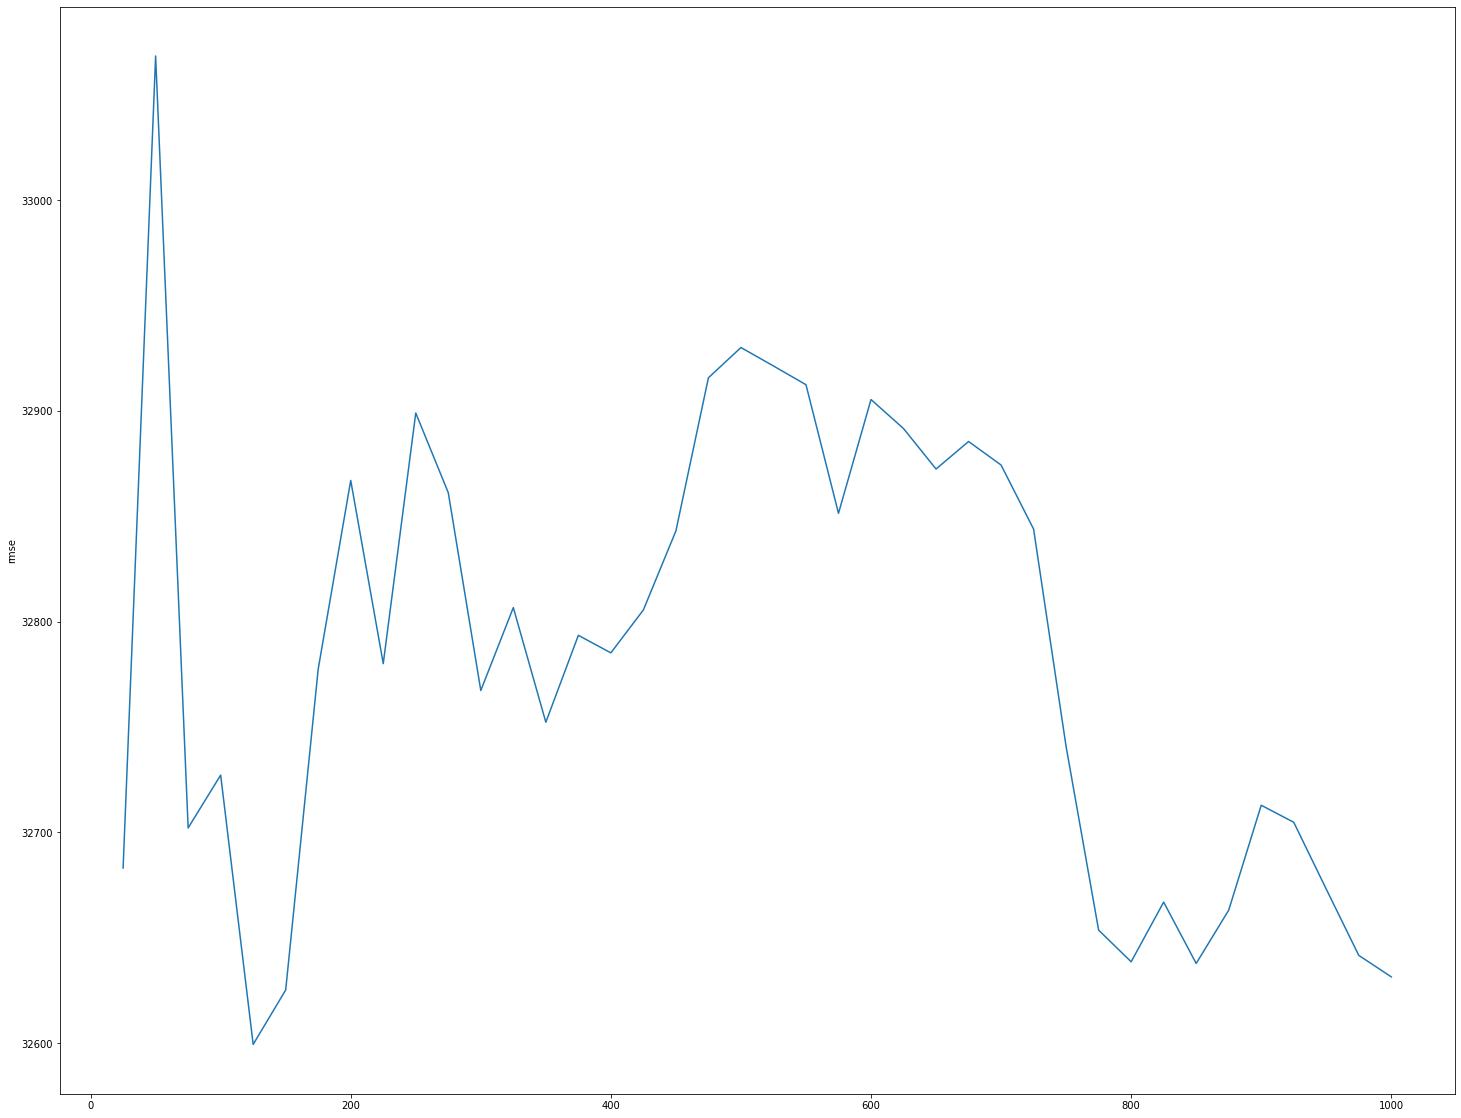

In [60]:
plt.figure(figsize=(25,20))
sns.lineplot(data=rmse_results)

Let's select 125 estimators

In [58]:
model_1 = RandomForestRegressor(n_estimators=125, random_state=0)
model_1.fit(X_train, y)
preds = model_1.predict(X_train)
mse = mean_squared_error(y, preds)
sqrt(mse)

10983.745463489746

Obtain predictions

In [59]:
submission = pd.DataFrame()
submission['Id'] = test_ids.astype(int)
predictions = model_1.predict(X_test)
output = pd.DataFrame({'Id': test_ids,
                       'SalePrice': predictions})
output.to_csv('submission.csv', index=False)